In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from itertools import count
from random import shuffle
import time
from copy import deepcopy

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/covid19-global-forecasting-week-3/submission.csv
/kaggle/input/covid19-global-forecasting-week-3/test.csv
/kaggle/input/covid19-global-forecasting-week-3/train.csv


In [2]:
def dateToInt(date):
    days = [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31]
    month, day = tuple(int(i) for i in date.split('-')[1:])
    return sum(days[:month]) + day - 22
dateToInt("2020-01-22")
dateToInt("2020-04-04")

73

In [3]:
def findDuplicates(l):
    duplicates = list()
    idxs = list()
    seen = dict()
    for i, element in enumerate(l):
        if element in seen:
            idx = seen[element]
            duplicates.append(i)
            idxs.append(idx)
        seen.update({element: i})
    return duplicates, idxs
findDuplicates([1, 2, 3, 4, 1, 2, 3, 4])

([4, 5, 6, 7], [0, 1, 2, 3])

In [4]:
# Installs adabound
import sys
from subprocess import call
call([sys.executable, '-m', 'pip', 'install', 'adabound'])

0

In [5]:
testname = "/kaggle/input/covid19-global-forecasting-week-3/test.csv"
ptest = pd.read_csv(testname)
testnames = [p[1] if type(p[1]) is str else p[2] for p in ptest.to_numpy()]
ptest

ForecastId Province_State Country_Region        Date
0               1            NaN    Afghanistan  2020-03-26
1               2            NaN    Afghanistan  2020-03-27
2               3            NaN    Afghanistan  2020-03-28
3               4            NaN    Afghanistan  2020-03-29
4               5            NaN    Afghanistan  2020-03-30
...           ...            ...            ...         ...
13153       13154            NaN       Zimbabwe  2020-05-03
13154       13155            NaN       Zimbabwe  2020-05-04
13155       13156            NaN       Zimbabwe  2020-05-05
13156       13157            NaN       Zimbabwe  2020-05-06
13157       13158            NaN       Zimbabwe  2020-05-07

[13158 rows x 4 columns]

In [6]:
trainname = "/kaggle/input/covid19-global-forecasting-week-3/train.csv"
ptrain = pd.read_csv(trainname)
nptrain = ptrain.to_numpy()
names = set()
provinces = set()
pdatas = dict()
for data in nptrain:
    name = data[2]
    names.add(name)
for name in names:
    pdatas.update({name: ptrain[ptrain["Country_Region"] == name].to_numpy()})
for name, data in list(pdatas.items()):
    for d in data:
        state = d[1]
        if type(state) is float or state in provinces:
            continue
        try:
            if name not in ("Canada",) and name not in testnames:
                del pdatas[name]
                names.remove(name)
        except:
            pass
        names.add(state)
        provinces.add(state)
        pdatas.update({state: ptrain[ptrain["Province_State"] == state].to_numpy()})
counter = 0
stuff = [0 for i in range(72)]
for i in pdatas["Illinois"]:
    stuff[counter % 72] += i[-2]
    counter += 1
# pdatas["California"]


In [7]:
oldxbycountry = dict()
oldybycountry = dict()
xbycountry = dict()
ybycountry = dict()
shufflexbycountry = dict()
shuffleybycountry = dict()

for name in names:
    data = pdatas[name]
    countryx = [dateToInt(p[3]) for p in data]
    countryy = [p[4:] for p in data]
    oldxbycountry.update({name: countryx})
    oldybycountry.update({name: countryy})
l = len(oldxbycountry["Italy"])
for name in names:
    scheme = list(range(l))
    shuffle(scheme)
    newx = list(0 for i in range(l))
    newy = list([0, 0] for i in range(l))
    shufflex = list(0 for i in range(l))
    shuffley = list([0,0] for i in range(l))
    for i, x, y in zip(count(), oldxbycountry[name], oldybycountry[name]):
        newx[i%l] = x
        newy[i%l][0] += y[0]
        newy[i%l][1] += y[1]
        shufflex[scheme[i%l]] = x
        shuffley[scheme[i%l]][0] += y[0]
        shuffley[scheme[i%l]][1] += y[1]
    xbycountry.update({name: np.array(newx)})
    ybycountry.update({name: np.array(newy)})
    shufflexbycountry.update({name: np.array(shufflex)})
    shuffleybycountry.update({name: np.array(shuffley)})
len(ybycountry["California"])
xbycountry["California"]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75])

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import adabound

In [9]:
def train(model, criterion, optimizer, x, y, limit):
    beg = time.time()
    try:
        for epoch in count():
            model.train()
            optimizer.zero_grad()
            y_pred = model(x)
            loss = criterion(y_pred, y)
            if epoch % 5000 == 0:
                print("Epoch:", epoch + 0*120000, "\tLoss:", loss.item())
            loss.backward()
            optimizer.step()
            seconds = time.time() - beg
            if seconds > limit:
                break
    except KeyboardInterrupt:
        pass
    return model, criterion, optimizer


In [10]:
class Model(nn.Module):
    def __init__(self, deg=1):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(deg, 2)
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(2, 2)
    def forward(self, x):
        return self.fc2(self.sigmoid(self.fc1(x/70)))

loosex = torch.FloatTensor([[pow(i, p) for p in (2,1)] for i in shufflexbycountry["Canada"]])
loosey = torch.FloatTensor([[float(i[0]/1e4), float(i[1]/2e2)] for i in shuffleybycountry["Canada"]])

m = Model(2)
loosemodel = train(
    m,
    nn.MSELoss(),
    adabound.AdaBound(m.parameters(), lr=1e-3, final_lr=.1),
    loosex,
    loosey,
    10
)[0]


Epoch: 0 	Loss: 0.20377402007579803
Epoch: 5000 	Loss: 0.01593201421201229
Epoch: 10000 	Loss: 0.007198798935860395


In [11]:
models = dict()
cnames = names
# cnames = ("California", "Vietnam")

for cname in cnames:
    if cname == "Canada":
        continue
    cases = max(i[0] for i in ybycountry[cname])
    small = cases < 30000
    rllysmall = cases < 5000
    xsmall = cases < 100
    print(small, rllysmall, xsmall)
    
    casenorm = 100 if xsmall else cases + .0001
    fatnorm = max(i[1] for i in ybycountry[cname]) + .001

    powers = (2,1) if small else (1,)

    beg = time.time()
    
#     train_limit = 100 if xsmall else 45 if rllysmall else 60 if small else 100
    train_limit = 100 if rllysmall else 30 if small else 60
#     train_limit = 3

    model = deepcopy(loosemodel) if rllysmall else Model(2 if small else 1)
    criterion = nn.MSELoss()
    sgd = lambda model: torch.optim.SGD(model.parameters(), lr=.1)
#     ada = lambda model: adabound.AdaBound(model.parameters(), lr=1e-2, final_lr=.1)
    adam = lambda model: torch.optim.Adam(model.parameters())

    x = torch.FloatTensor([[pow(i, p) for p in powers] for i in shufflexbycountry[cname]])
    y = torch.FloatTensor([[float(i[0]/casenorm), float(i[1]/fatnorm)] for i in shuffleybycountry[cname]])

    # Around 120000 epochs
    newmodel = train(
        model,
        criterion,
        adam(model),
        x,
        y,
        train_limit
    )[0]
    
    models.update({cname: (newmodel, powers, casenorm, fatnorm)})

    seconds = time.time() - beg
    print(cname, "trained in", seconds // 60, "minutes", seconds % 60, "seconds")


True True True
Epoch: 0 	Loss: 0.10245878994464874
Epoch: 5000 	Loss: 0.004678484983742237
Epoch: 10000 	Loss: 0.003226175904273987
Epoch: 15000 	Loss: 0.002423409139737487
Epoch: 20000 	Loss: 0.002304240595549345
Epoch: 25000 	Loss: 0.002242749324068427
Epoch: 30000 	Loss: 0.0022015615832060575
Epoch: 35000 	Loss: 0.0021709557622671127
Epoch: 40000 	Loss: 0.002146919956430793
Epoch: 45000 	Loss: 0.002127069514244795
Epoch: 50000 	Loss: 0.0021100081503391266
Epoch: 55000 	Loss: 0.0020947777666151524
Epoch: 60000 	Loss: 0.0020806430839002132
Epoch: 65000 	Loss: 0.002066268352791667
Epoch: 70000 	Loss: 0.0020507387816905975
Epoch: 75000 	Loss: 0.00203487160615623
Epoch: 80000 	Loss: 0.00200495682656765
Epoch: 85000 	Loss: 0.001960905035957694
Epoch: 90000 	Loss: 0.001885254168882966
Epoch: 95000 	Loss: 0.0017635920085012913
Epoch: 100000 	Loss: 0.0016035853186622262
Epoch: 105000 	Loss: 0.0014327047392725945
Epoch: 110000 	Loss: 0.0012687547132372856
Epoch: 115000 	Loss: 0.00111935171298

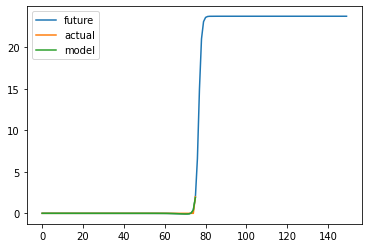

Bermuda average accuracy: 99.2%


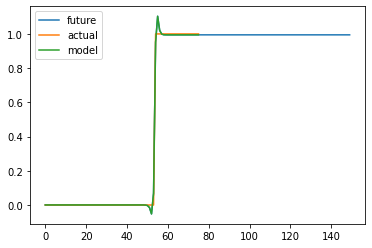

Cayman Islands average accuracy: 99.4%


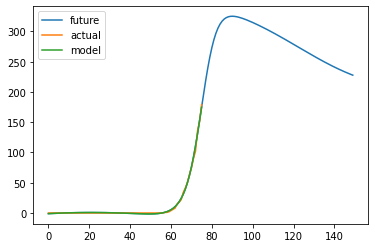

Pennsylvania average accuracy: 99.4%


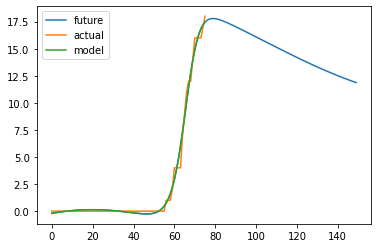

Burkina Faso average accuracy: 98.7%


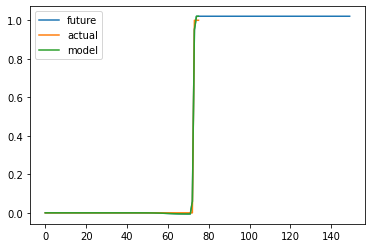

Liechtenstein average accuracy: 99.7%


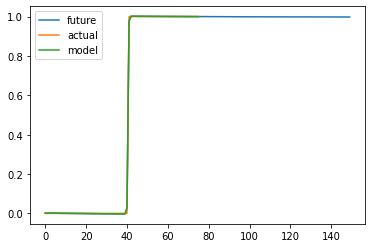

Inner Mongolia average accuracy: 99.8%


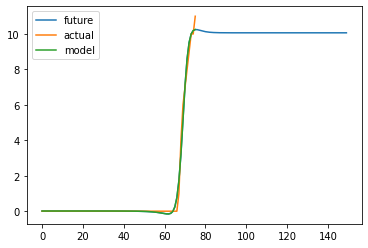

Bolivia average accuracy: 99.2%


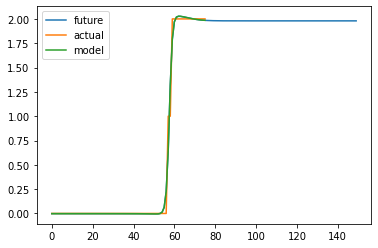

Costa Rica average accuracy: 99.0%


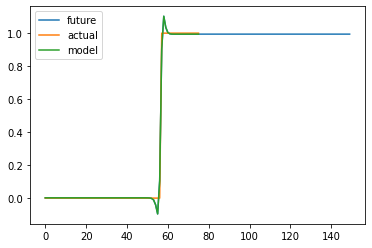

Curacao average accuracy: 99.1%


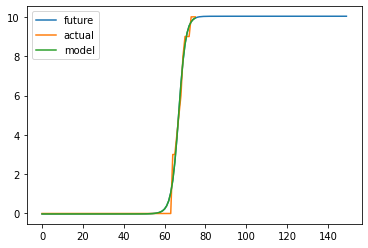

Idaho average accuracy: 98.9%


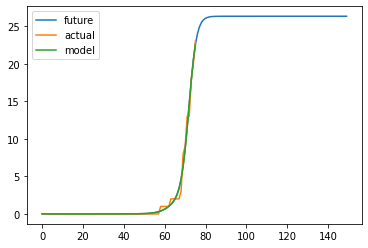

Alberta average accuracy: 99.2%


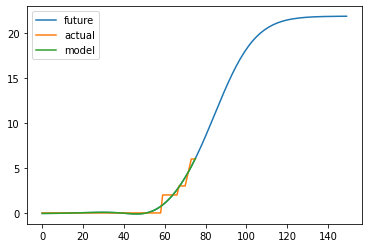

Singapore average accuracy: 97.2%


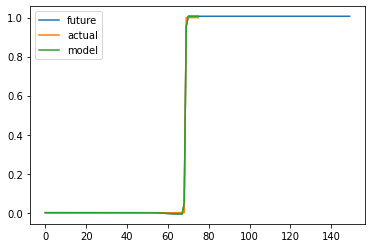

Tanzania average accuracy: 99.7%


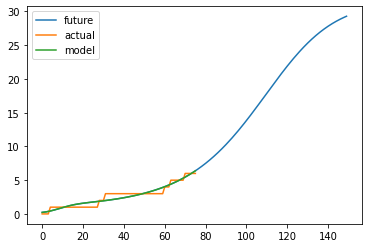

Shanghai average accuracy: 93.0%


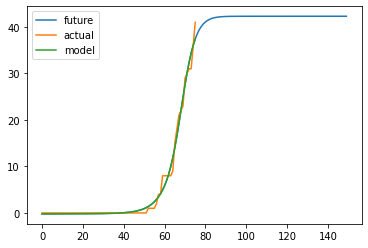

Luxembourg average accuracy: 98.6%


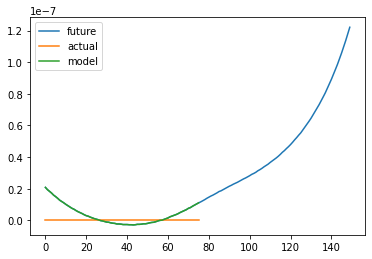

Saint Barthelemy average accuracy: 1e+02%


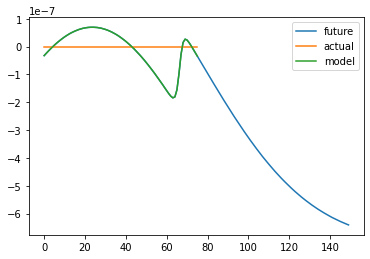

British Virgin Islands average accuracy: 1e+02%


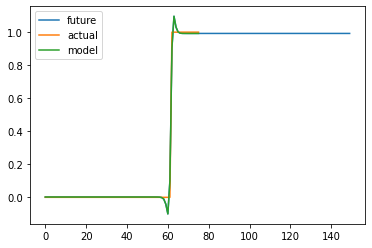

Cabo Verde average accuracy: 99.1%


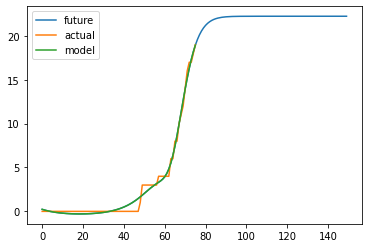

Lebanon average accuracy: 98.1%


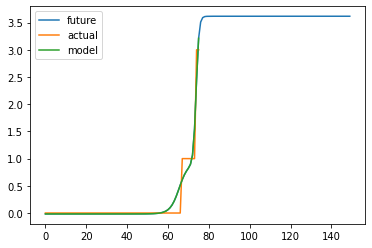

Cote d'Ivoire average accuracy: 97.7%


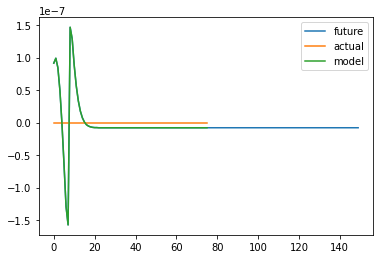

Tibet average accuracy: 1e+02%


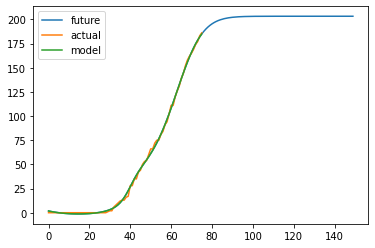

Korea, South average accuracy: 99.3%


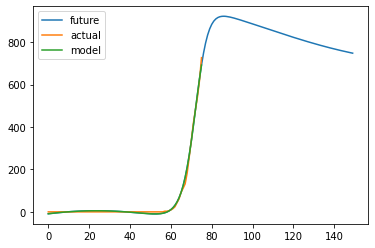

Michigan average accuracy: 99.2%


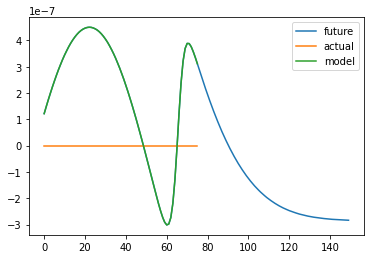

Yukon average accuracy: 1e+02%


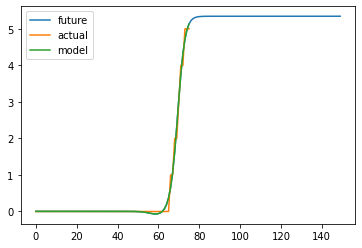

Sri Lanka average accuracy: 99.1%


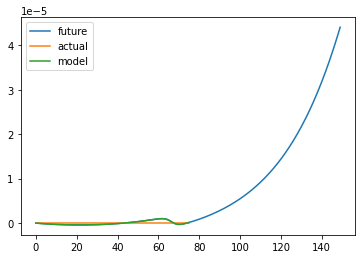

Prince Edward Island average accuracy: 1e+02%


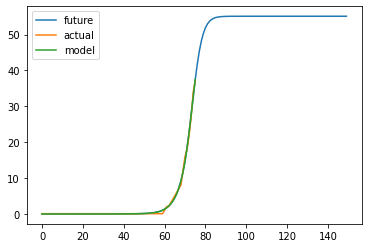

Chile average accuracy: 99.5%


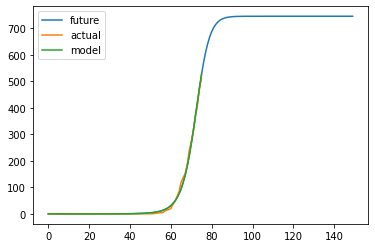

Louisiana average accuracy: 99.4%


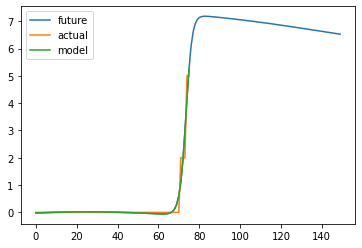

Congo (Brazzaville) average accuracy: 98.6%


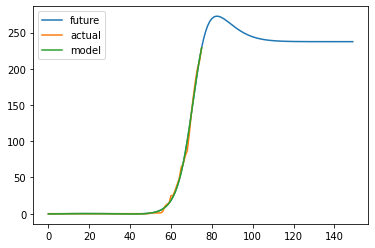

Georgia average accuracy: 99.5%


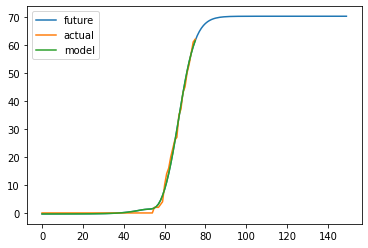

Malaysia average accuracy: 98.9%


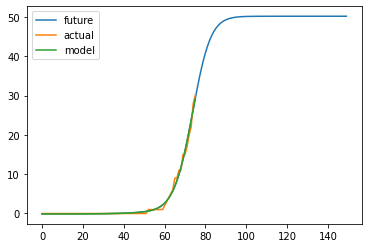

Slovenia average accuracy: 98.9%


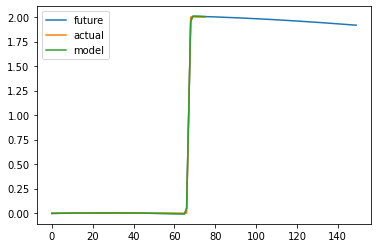

Syria average accuracy: 99.8%


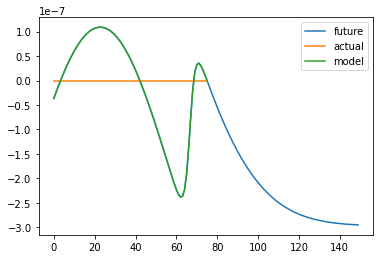

Anguilla average accuracy: 1e+02%


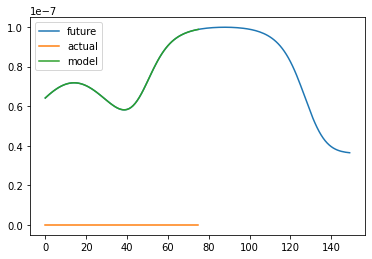

Maldives average accuracy: 1e+02%


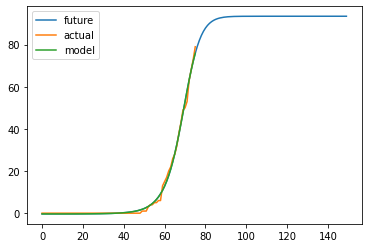

Greece average accuracy: 99.1%


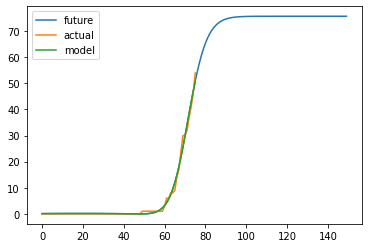

Panama average accuracy: 99.1%


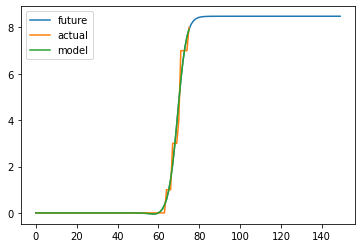

Armenia average accuracy: 98.8%


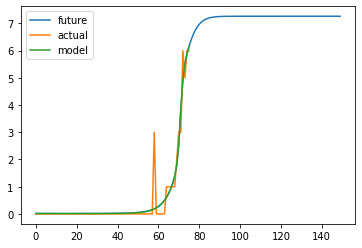

Kazakhstan average accuracy: 97.7%


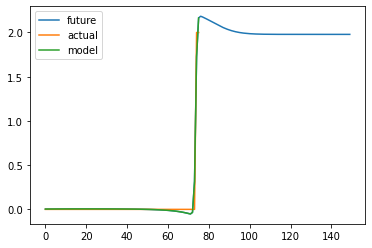

Ethiopia average accuracy: 99.1%


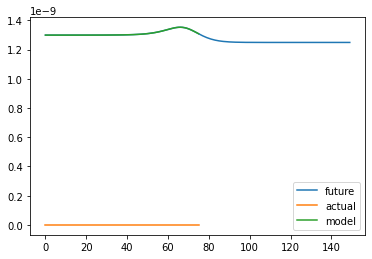

Guinea-Bissau average accuracy: 1e+02%


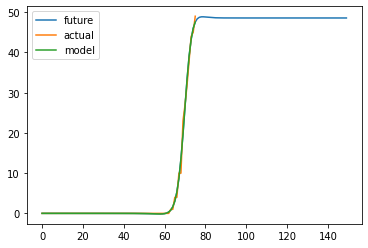

Alabama average accuracy: 99.5%


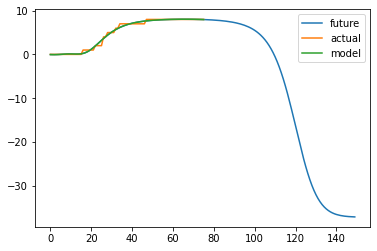

Guangdong average accuracy: 97.5%


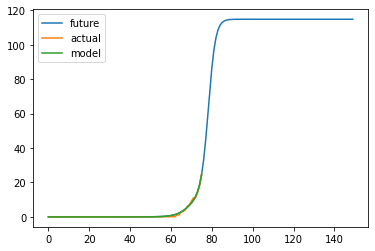

Iowa average accuracy: 99.1%


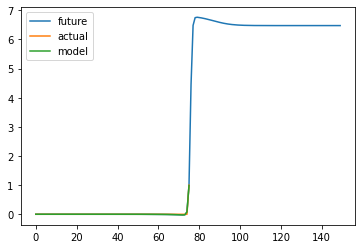

Benin average accuracy: 99.6%


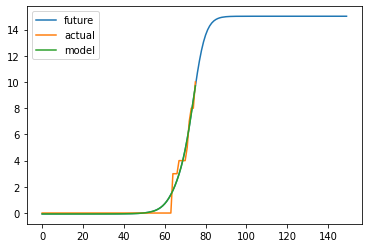

Victoria average accuracy: 97.8%


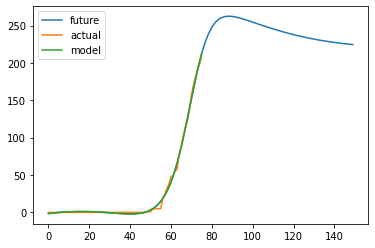

Indonesia average accuracy: 99.2%


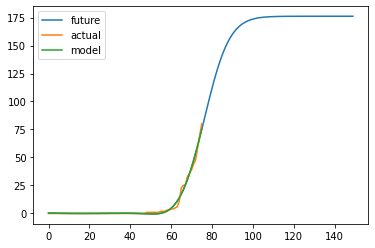

Morocco average accuracy: 98.9%


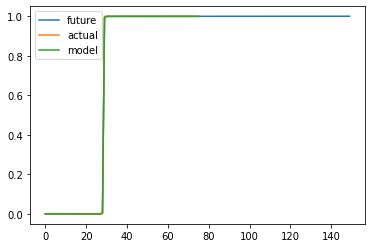

Zhejiang average accuracy: 1e+02%


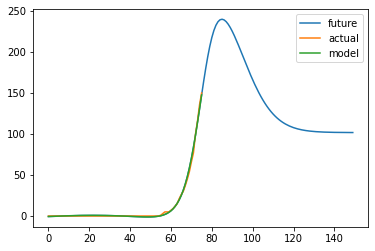

Texas average accuracy: 99.3%


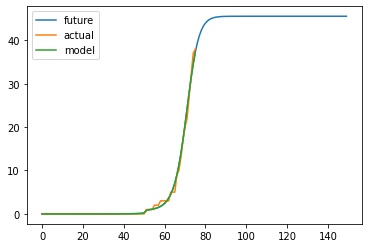

Ukraine average accuracy: 99.3%


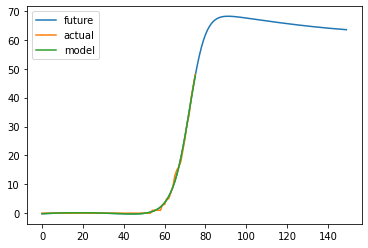

South Carolina average accuracy: 99.4%


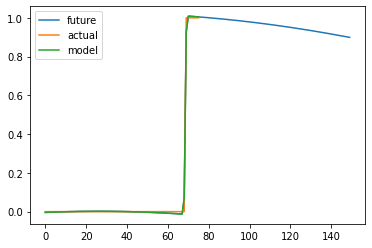

Botswana average accuracy: 99.5%


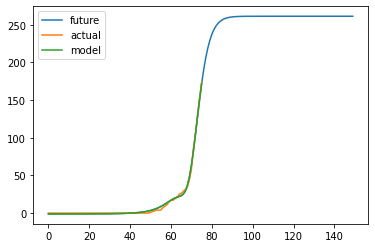

Algeria average accuracy: 99.2%


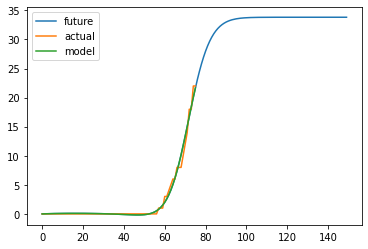

Tunisia average accuracy: 98.7%


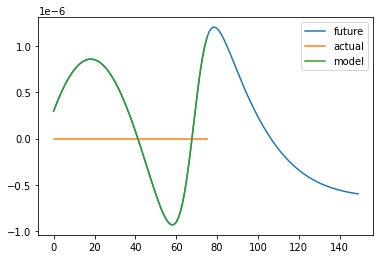

Northern Territory average accuracy: 99.9%


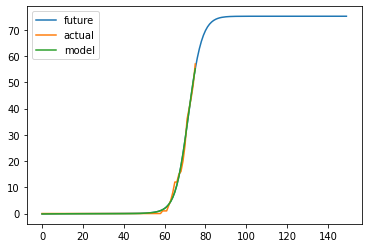

Israel average accuracy: 99.2%


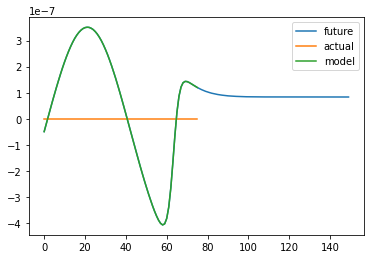

Mozambique average accuracy: 1e+02%


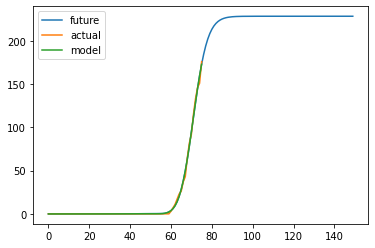

Romania average accuracy: 99.6%


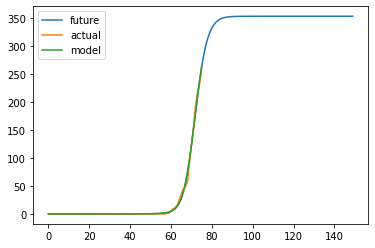

Massachusetts average accuracy: 99.5%


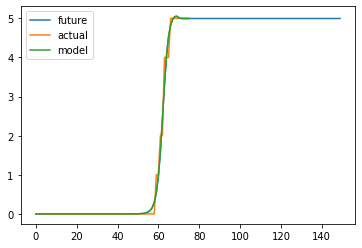

Ghana average accuracy: 99.0%


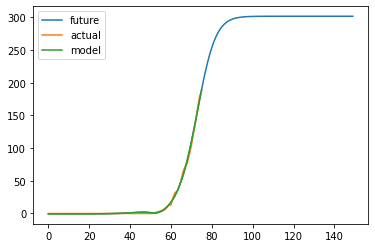

Denmark average accuracy: 99.3%


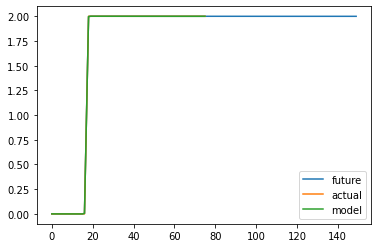

Gansu average accuracy: 1e+02%


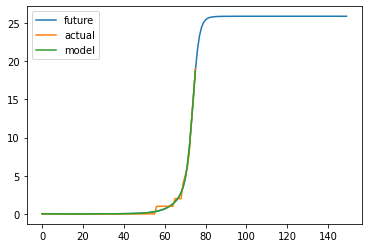

Moldova average accuracy: 99.3%


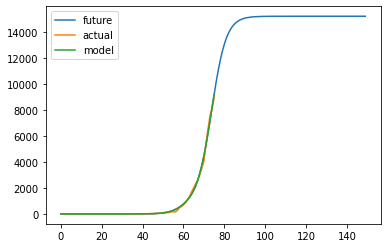

France average accuracy: 99.4%


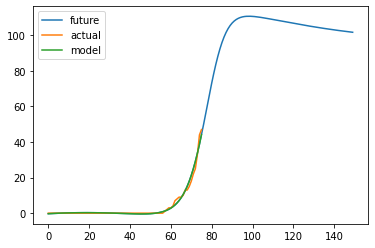

Missouri average accuracy: 98.7%


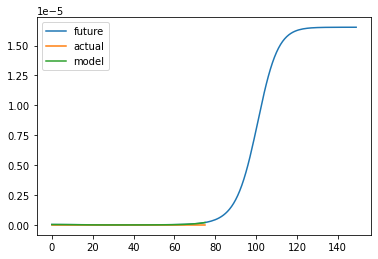

Jiangsu average accuracy: 1e+02%


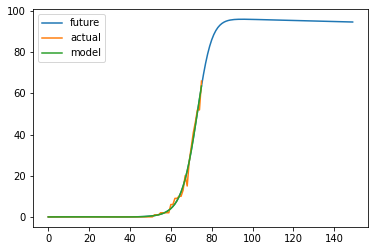

Virginia average accuracy: 99.2%


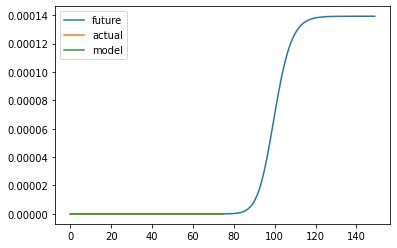

Fiji average accuracy: 1e+02%


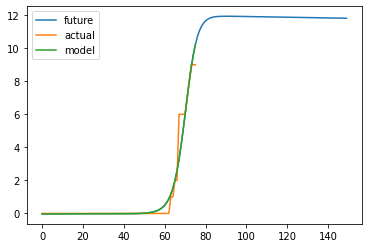

Cameroon average accuracy: 98.1%


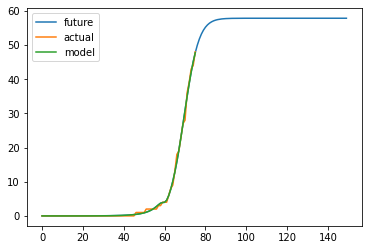

Argentina average accuracy: 99.5%


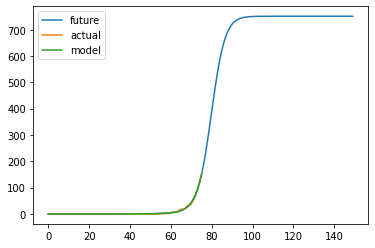

Ontario average accuracy: 99.6%


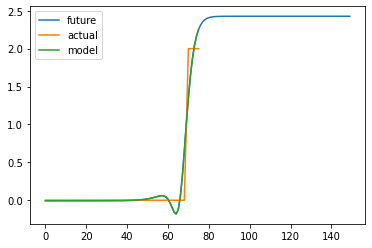

Tasmania average accuracy: 97.4%


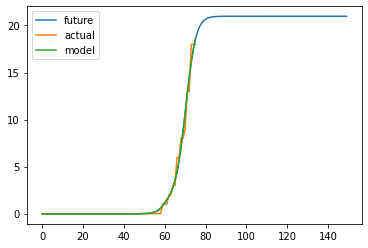

Congo (Kinshasa) average accuracy: 98.9%


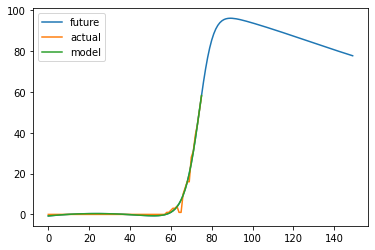

Serbia average accuracy: 99.0%


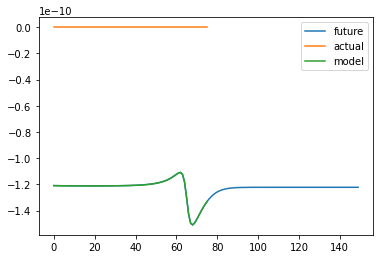

New Brunswick average accuracy: 1e+02%


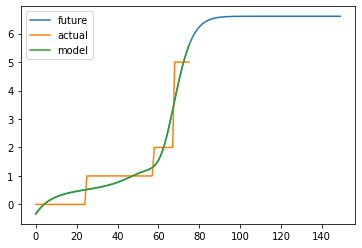

Taiwan* average accuracy: 93.2%


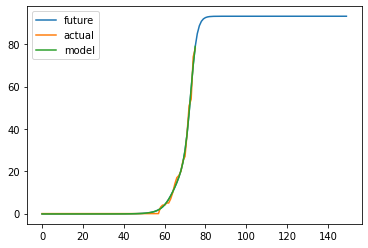

Wisconsin average accuracy: 99.3%


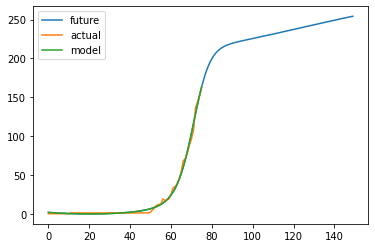

Philippines average accuracy: 98.9%


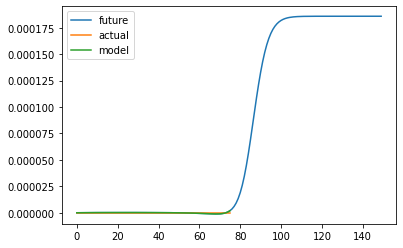

Northwest Territories average accuracy: 1e+02%


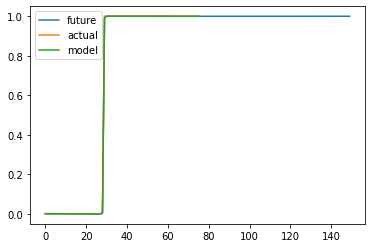

Fujian average accuracy: 1e+02%


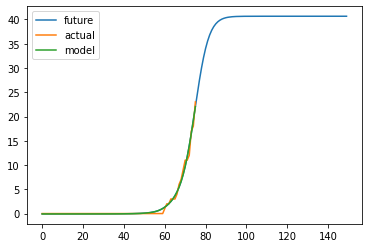

North Macedonia average accuracy: 99.0%


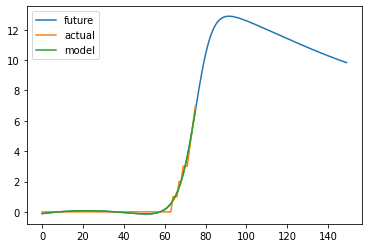

Channel Islands average accuracy: 98.5%


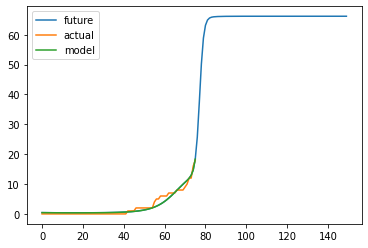

New South Wales average accuracy: 96.2%


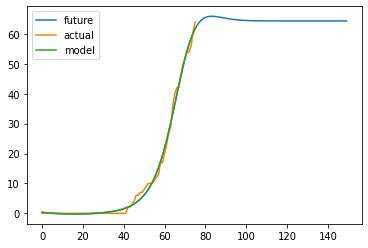

Iraq average accuracy: 98.7%


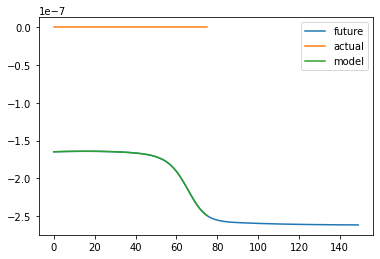

Rwanda average accuracy: 1e+02%


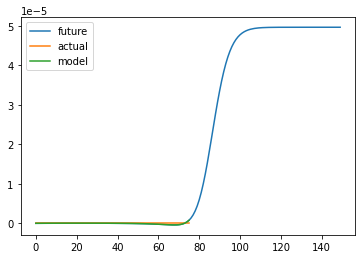

Sierra Leone average accuracy: 1e+02%


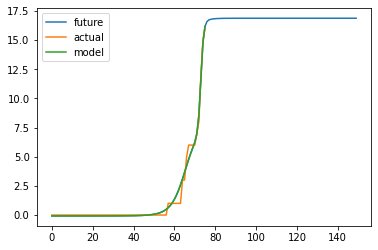

Croatia average accuracy: 98.8%


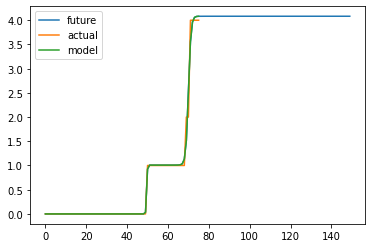

Guyana average accuracy: 99.3%


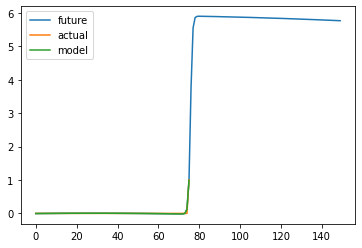

Belize average accuracy: 99.4%


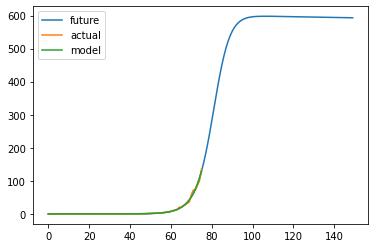

India average accuracy: 99.3%


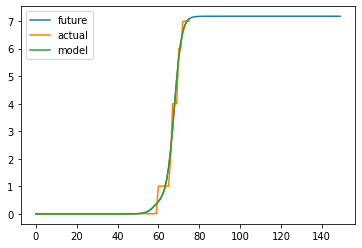

Guadeloupe average accuracy: 98.6%


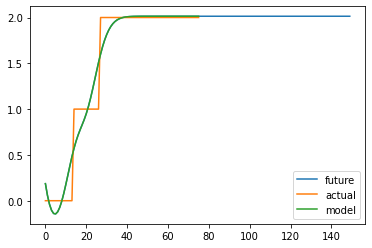

Guizhou average accuracy: 95.1%


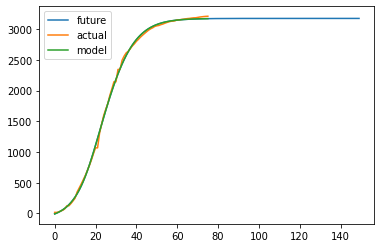

Hubei average accuracy: 99.3%


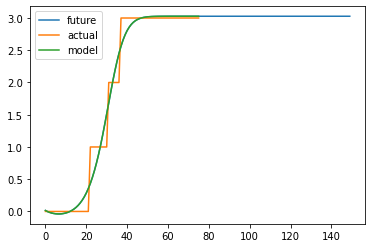

Xinjiang average accuracy: 96.4%


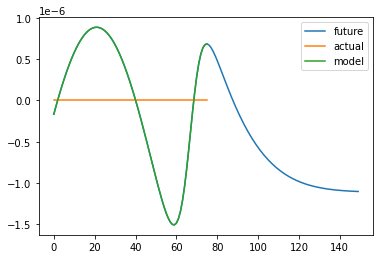

Gibraltar average accuracy: 99.9%


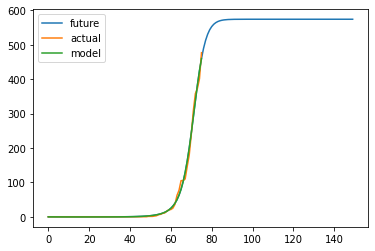

Sweden average accuracy: 99.3%


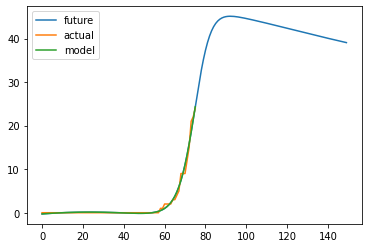

District of Columbia average accuracy: 98.9%


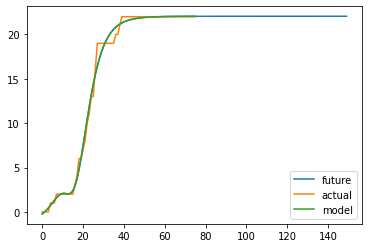

Henan average accuracy: 98.5%


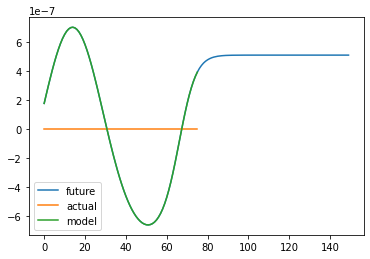

Namibia average accuracy: 1e+02%


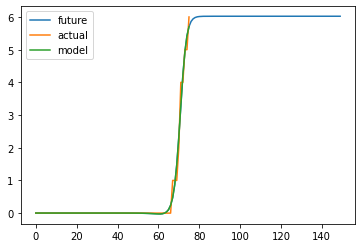

Uruguay average accuracy: 99.2%


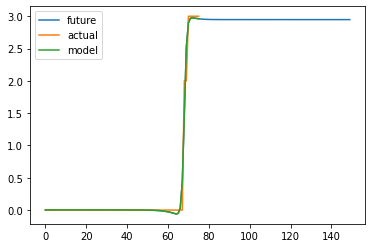

Saskatchewan average accuracy: 99.0%


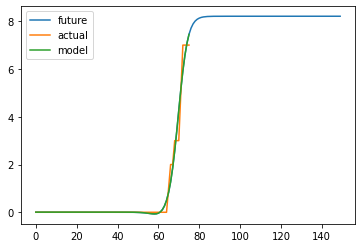

Venezuela average accuracy: 98.7%


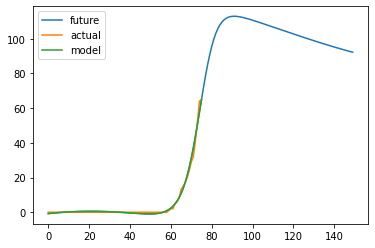

Arizona average accuracy: 98.9%


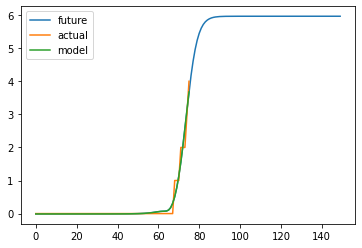

West Virginia average accuracy: 98.7%


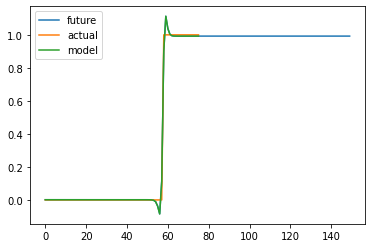

Gabon average accuracy: 99.1%


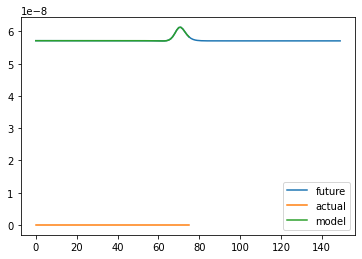

Guinea average accuracy: 1e+02%


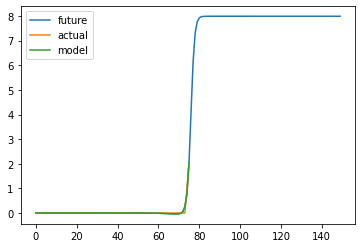

Barbados average accuracy: 99.4%


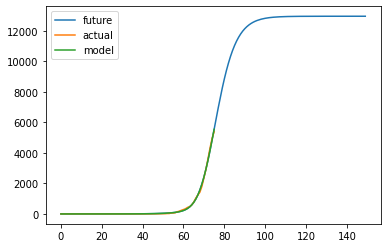

United Kingdom average accuracy: 99.6%


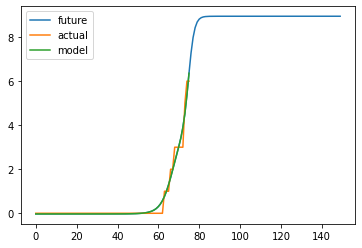

Alaska average accuracy: 98.2%


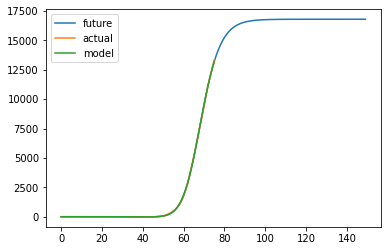

Spain average accuracy: 99.8%


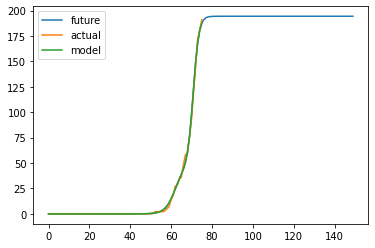

Ecuador average accuracy: 99.6%


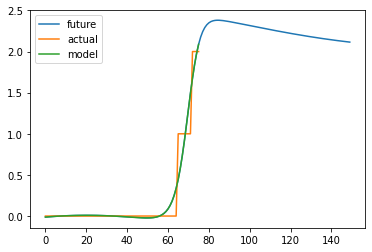

Manitoba average accuracy: 97.1%


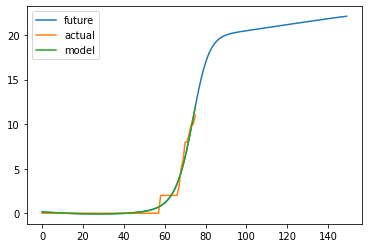

United Arab Emirates average accuracy: 97.6%


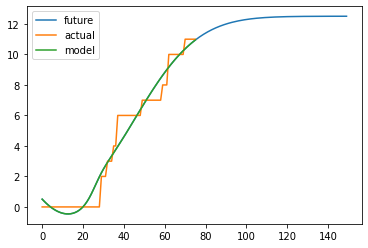

Diamond Princess average accuracy: 95.0%


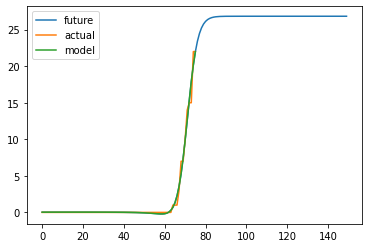

Honduras average accuracy: 99.1%


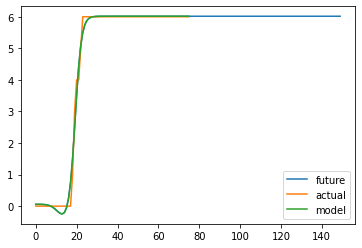

Anhui average accuracy: 98.7%


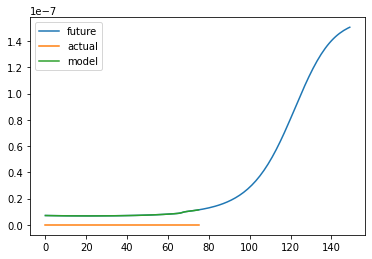

Saint Lucia average accuracy: 1e+02%


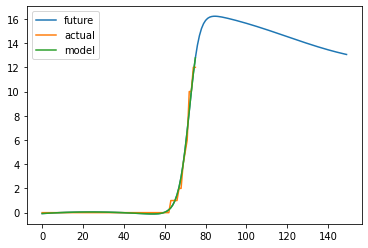

New Mexico average accuracy: 99.0%


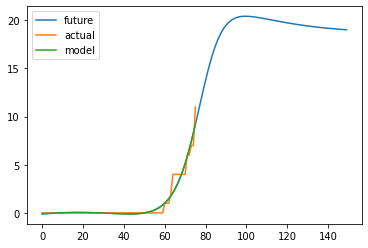

Afghanistan average accuracy: 97.9%


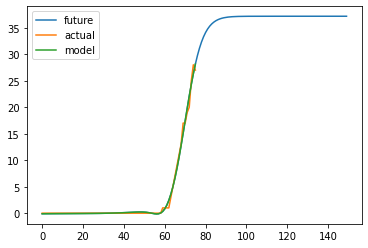

Finland average accuracy: 99.1%


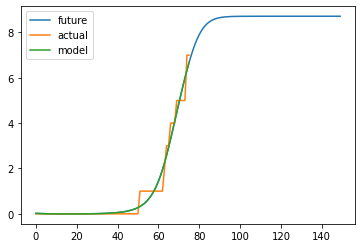

Azerbaijan average accuracy: 97.6%


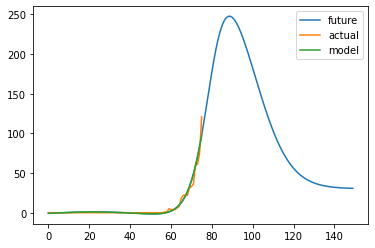

Quebec average accuracy: 98.5%


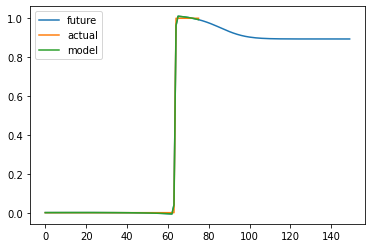

West Bank and Gaza average accuracy: 99.7%


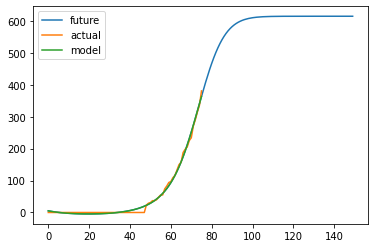

Washington average accuracy: 98.8%


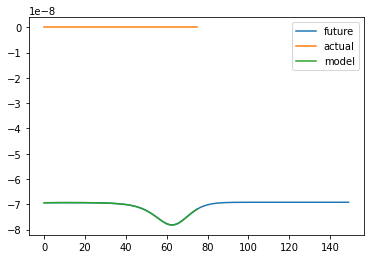

Madagascar average accuracy: 1e+02%


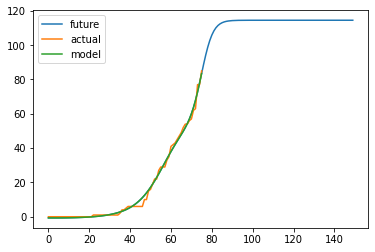

Japan average accuracy: 98.6%


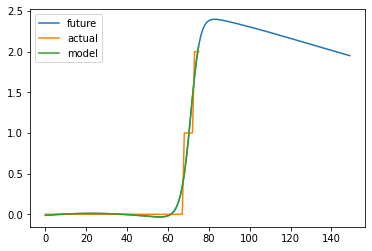

St Martin average accuracy: 97.7%


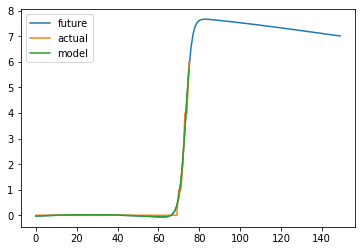

Sint Maarten average accuracy: 99.1%


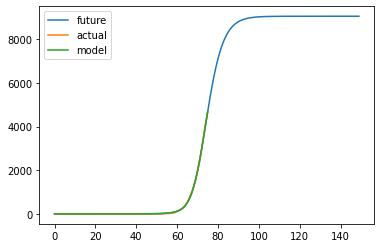

New York average accuracy: 99.8%


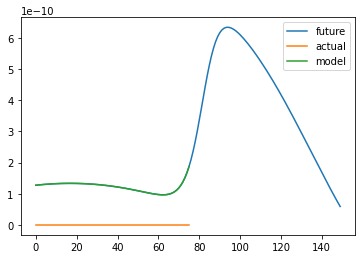

Djibouti average accuracy: 1e+02%


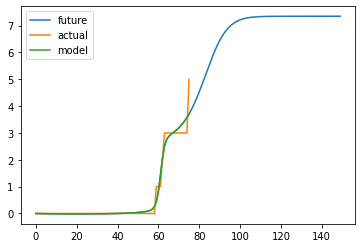

Paraguay average accuracy: 98.2%


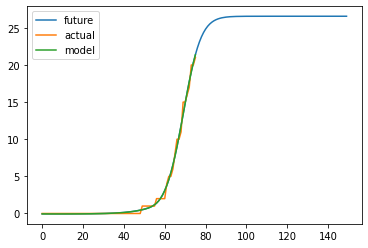

Albania average accuracy: 98.9%


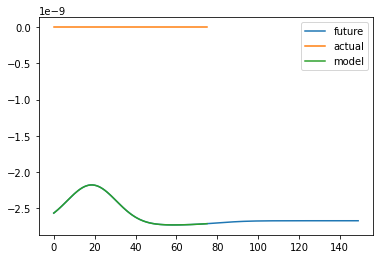

French Guiana average accuracy: 1e+02%


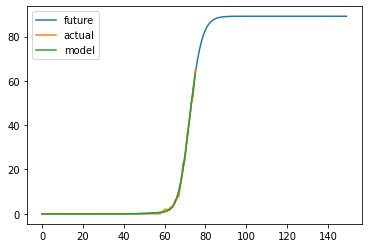

Tennessee average accuracy: 99.4%


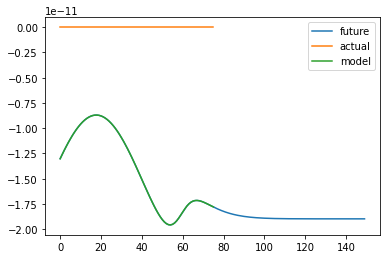

Faroe Islands average accuracy: 1e+02%


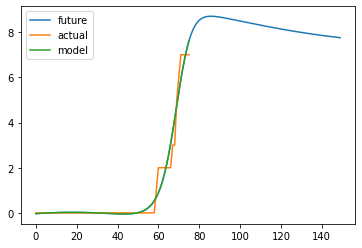

Mauritius average accuracy: 97.5%


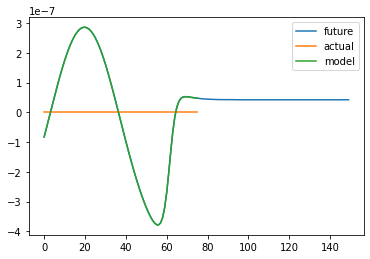

New Caledonia average accuracy: 1e+02%


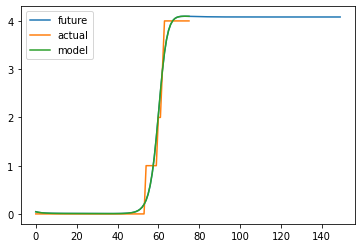

Bahrain average accuracy: 97.9%


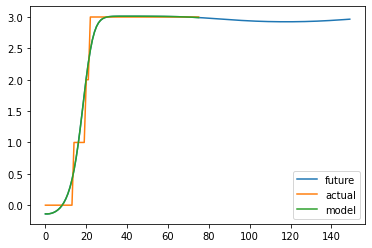

Tianjin average accuracy: 97.3%


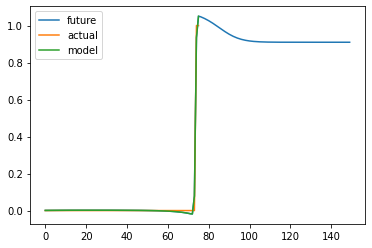

Haiti average accuracy: 99.5%


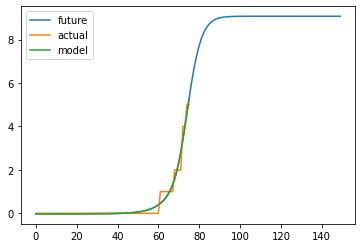

Nigeria average accuracy: 97.9%


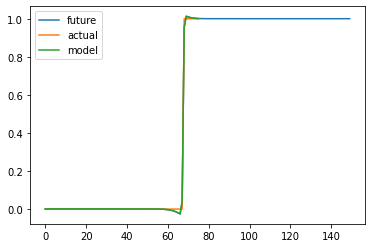

Newfoundland and Labrador average accuracy: 99.7%


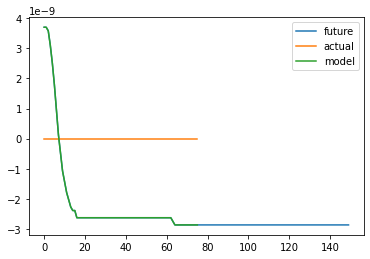

Dominica average accuracy: 1e+02%


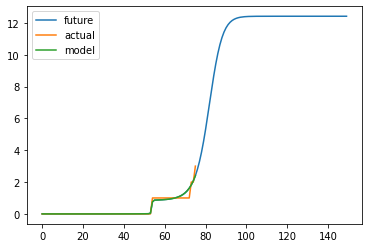

Guatemala average accuracy: 98.2%


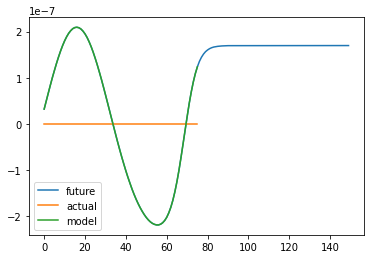

Chad average accuracy: 1e+02%


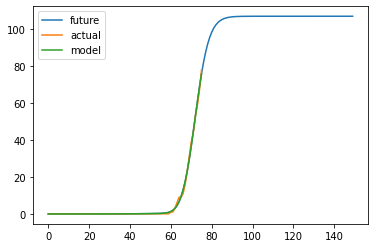

Czechia average accuracy: 99.6%


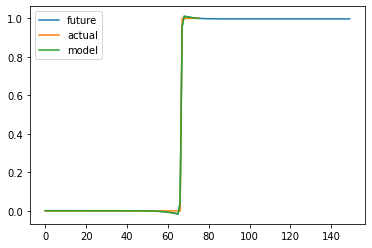

Monaco average accuracy: 99.7%


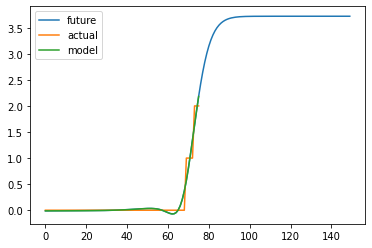

Oman average accuracy: 97.8%


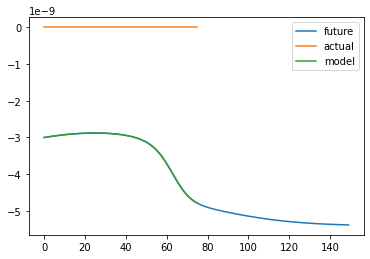

Macau average accuracy: 1e+02%


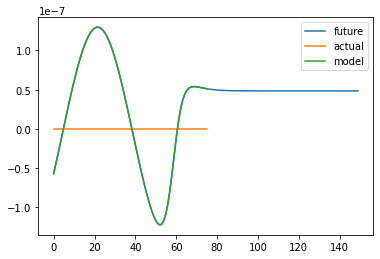

Cambodia average accuracy: 1e+02%


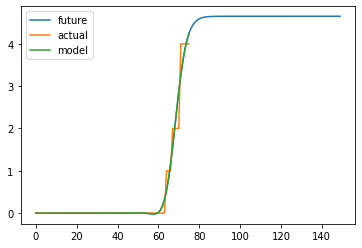

Queensland average accuracy: 98.4%


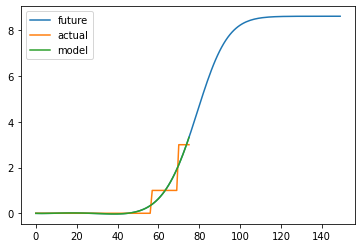

Jamaica average accuracy: 95.7%


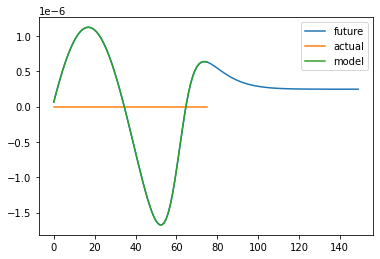

Equatorial Guinea average accuracy: 99.9%


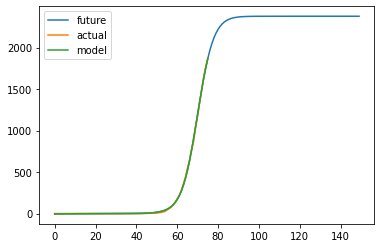

Netherlands average accuracy: 99.7%


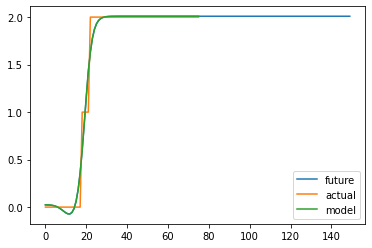

Guangxi average accuracy: 97.7%


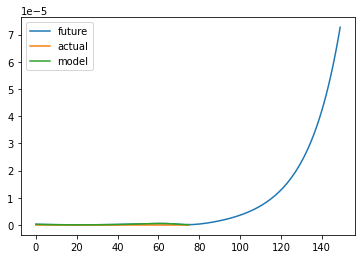

Somalia average accuracy: 1e+02%


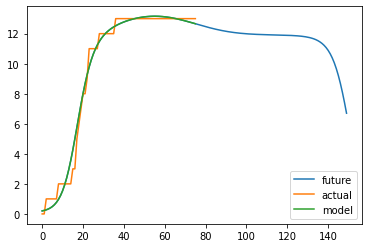

Heilongjiang average accuracy: 97.4%


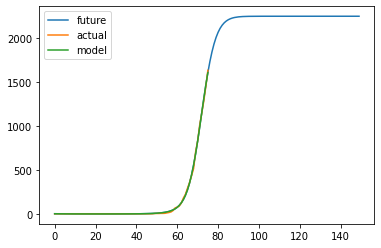

Belgium average accuracy: 99.7%


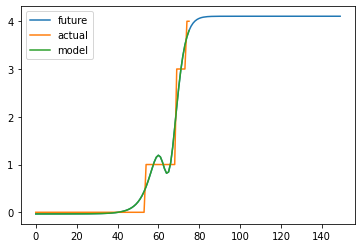

Martinique average accuracy: 97.1%


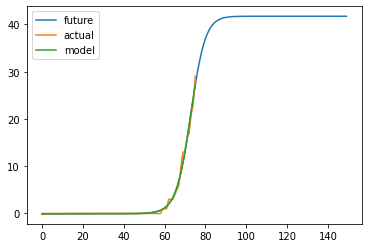

Bosnia and Herzegovina average accuracy: 99.2%


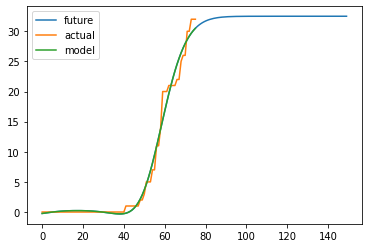

San Marino average accuracy: 97.8%


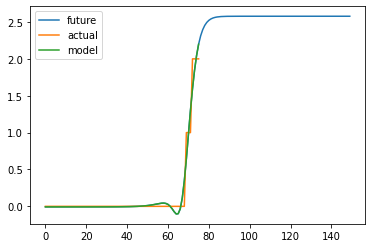

Mayotte average accuracy: 98.1%


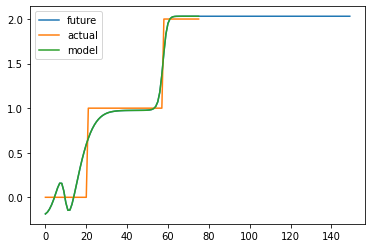

Liaoning average accuracy: 94.9%


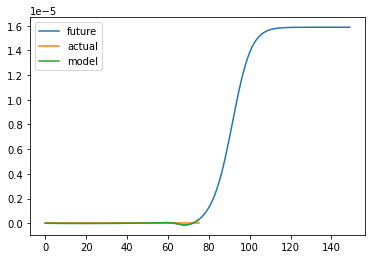

Saint Vincent and the Grenadines average accuracy: 1e+02%


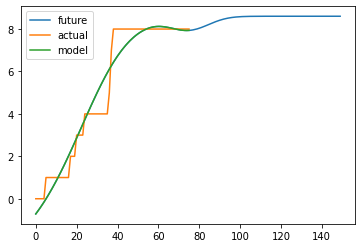

Beijing average accuracy: 94.0%


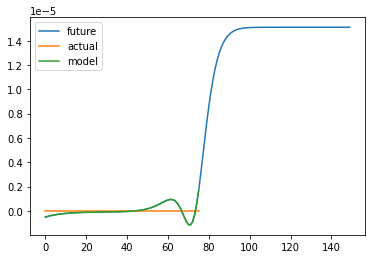

Wyoming average accuracy: 1e+02%


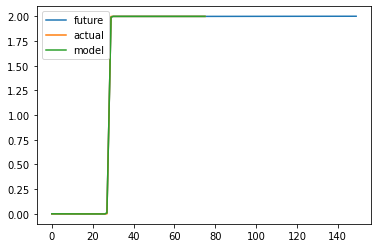

Yunnan average accuracy: 1e+02%


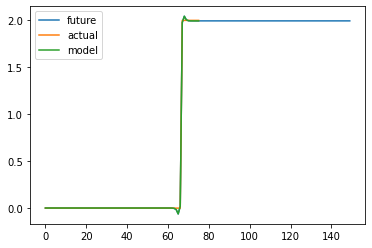

Angola average accuracy: 99.8%


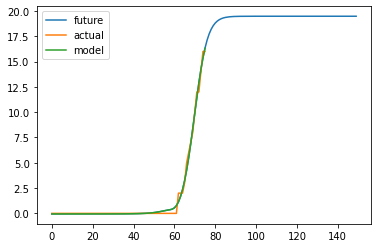

Arkansas average accuracy: 99.0%


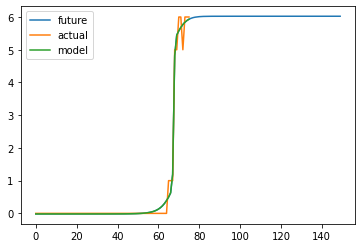

Montana average accuracy: 98.7%


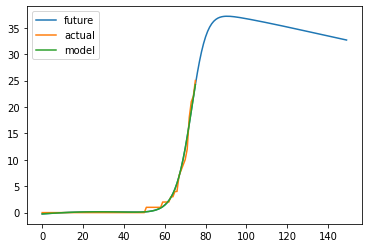

Kansas average accuracy: 98.7%


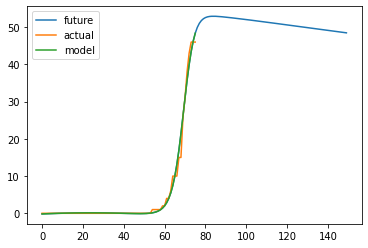

Nevada average accuracy: 99.0%


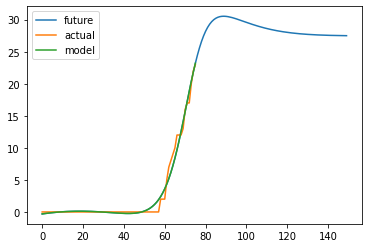

Vermont average accuracy: 98.2%


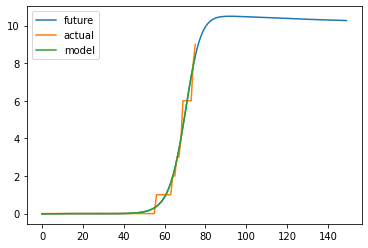

Cuba average accuracy: 98.5%


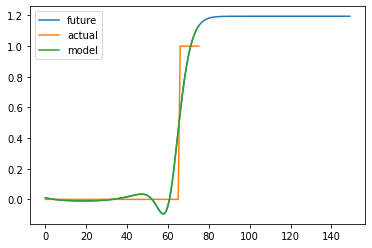

Brunei average accuracy: 95.1%


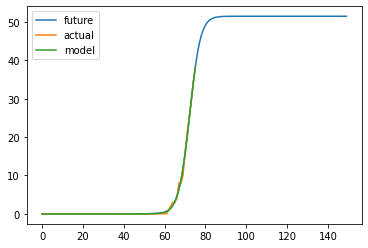

Saudi Arabia average accuracy: 99.6%


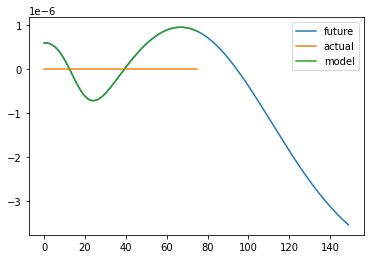

Ningxia average accuracy: 99.9%


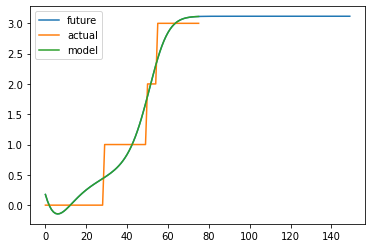

Shaanxi average accuracy: 92.8%


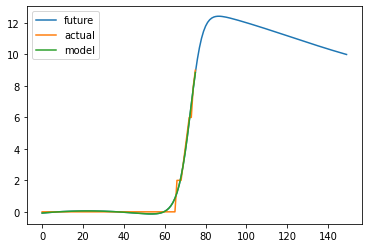

Nebraska average accuracy: 98.7%


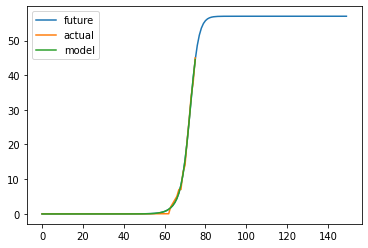

North Carolina average accuracy: 99.5%


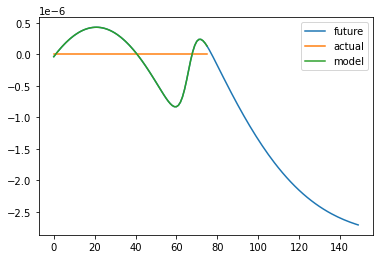

Uganda average accuracy: 1e+02%


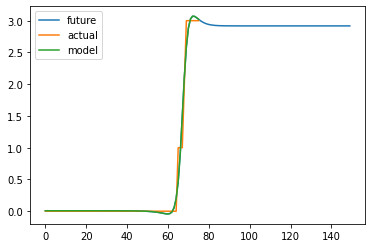

North Dakota average accuracy: 98.8%


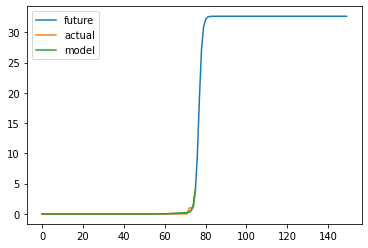

Kyrgyzstan average accuracy: 99.0%


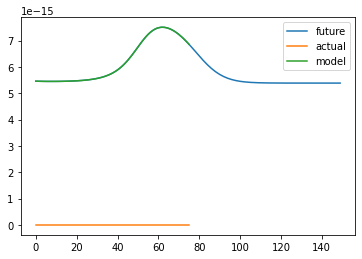

Nova Scotia average accuracy: 1e+02%


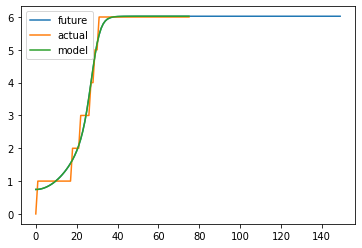

Hebei average accuracy: 97.8%


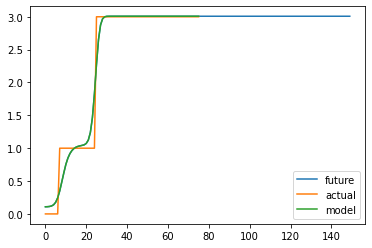

Sichuan average accuracy: 97.1%


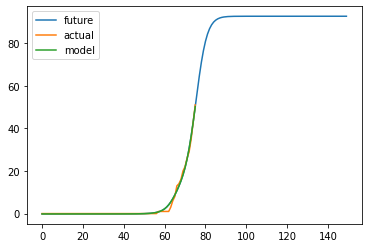

Mississippi average accuracy: 99.2%


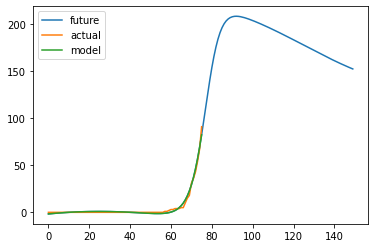

Maryland average accuracy: 98.7%


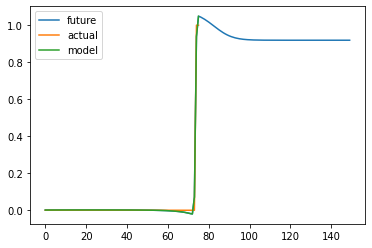

Virgin Islands average accuracy: 99.5%


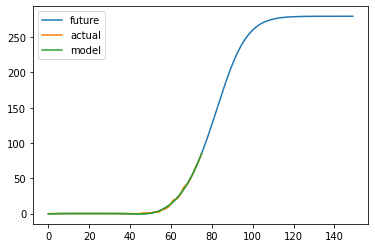

Egypt average accuracy: 99.4%


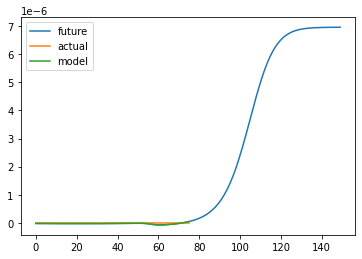

Mongolia average accuracy: 1e+02%


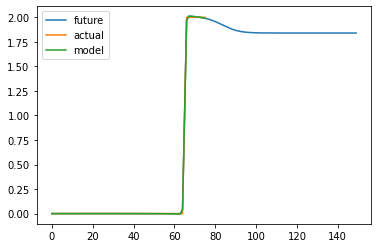

Uzbekistan average accuracy: 99.9%


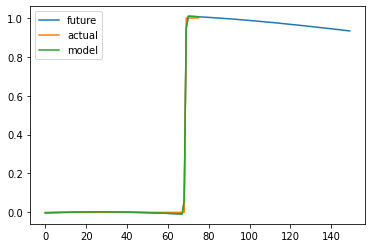

Burma average accuracy: 99.6%


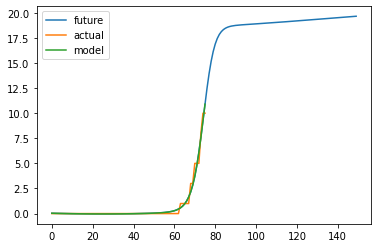

Niger average accuracy: 98.6%


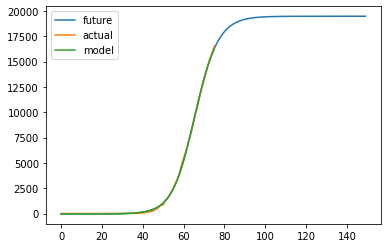

Italy average accuracy: 99.6%


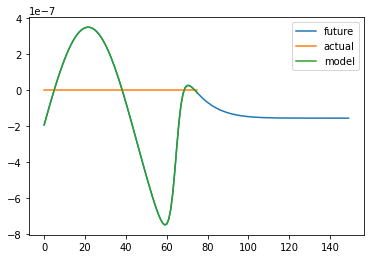

Laos average accuracy: 1e+02%


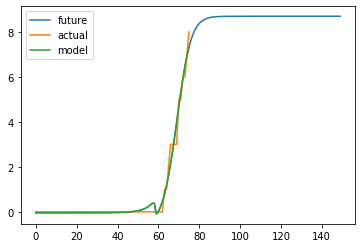

Trinidad and Tobago average accuracy: 98.4%


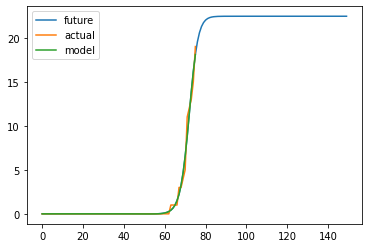

Estonia average accuracy: 99.2%


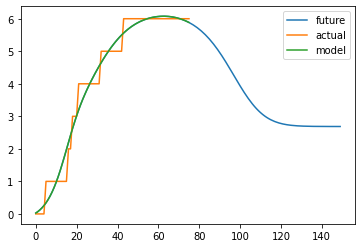

Hainan average accuracy: 96.3%


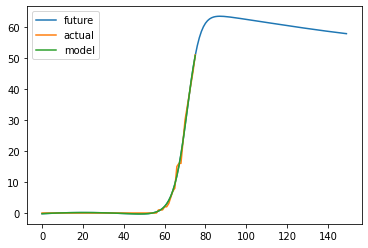

Oklahoma average accuracy: 99.4%


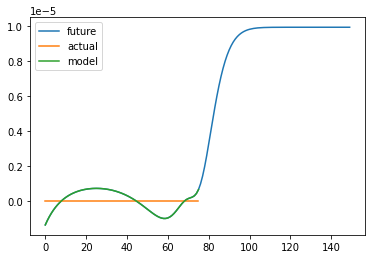

Nepal average accuracy: 99.9%


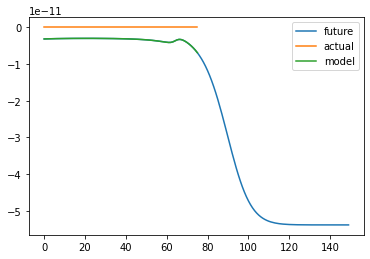

Aruba average accuracy: 1e+02%


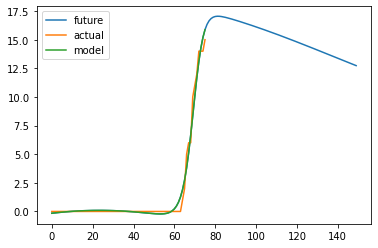

Delaware average accuracy: 98.4%


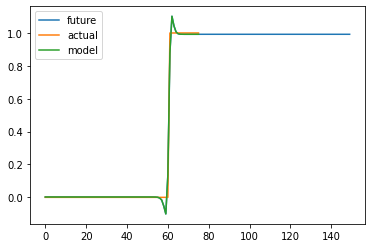

Gambia average accuracy: 99.0%


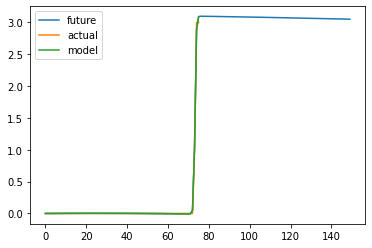

Liberia average accuracy: 99.8%


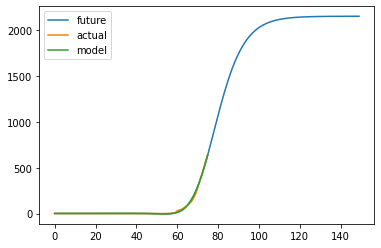

Turkey average accuracy: 99.4%


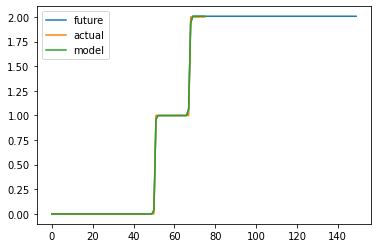

Sudan average accuracy: 99.8%


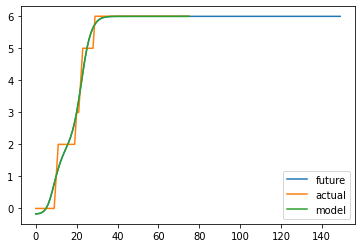

Chongqing average accuracy: 97.9%


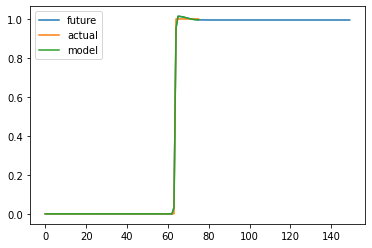

Kosovo average accuracy: 99.8%


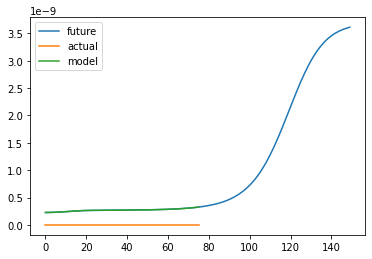

Shanxi average accuracy: 1e+02%


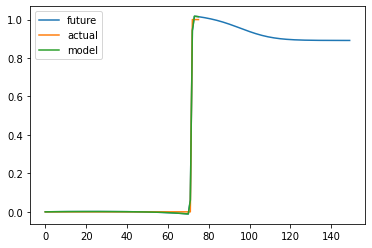

Suriname average accuracy: 99.6%


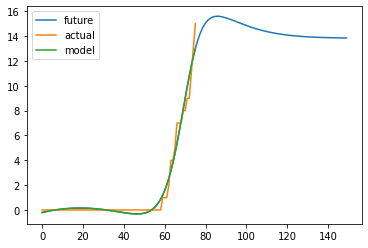

Lithuania average accuracy: 98.0%


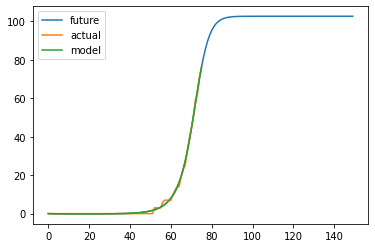

Norway average accuracy: 99.4%


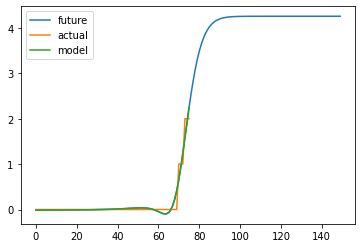

Senegal average accuracy: 97.8%


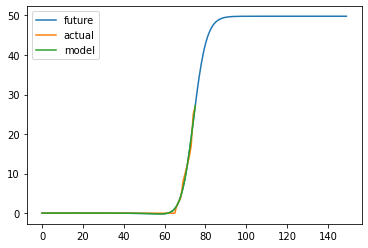

Rhode Island average accuracy: 99.3%


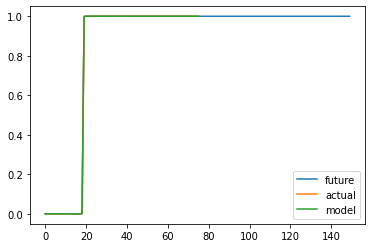

Jiangxi average accuracy: 1e+02%


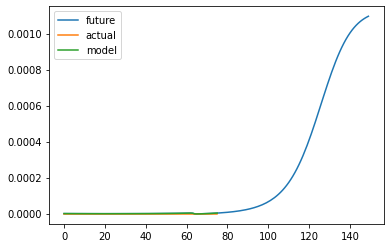

Montserrat average accuracy: 99.9%


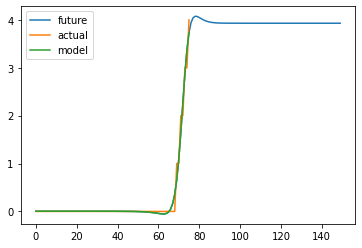

El Salvador average accuracy: 99.0%


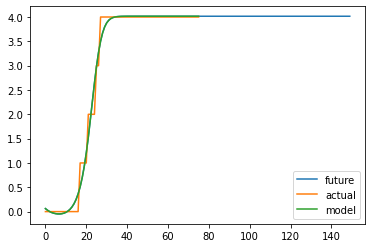

Hunan average accuracy: 98.0%


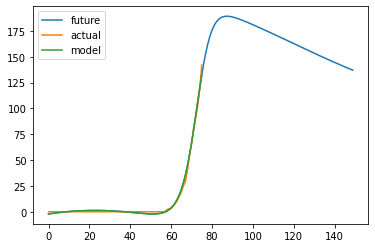

Ohio average accuracy: 99.1%


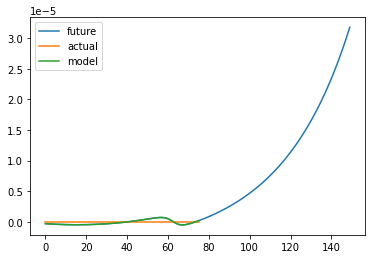

Eswatini average accuracy: 1e+02%


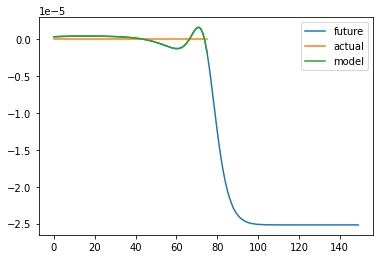

Saint Kitts and Nevis average accuracy: 99.9%


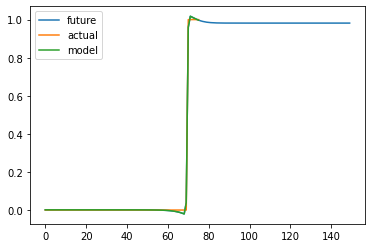

Isle of Man average accuracy: 99.7%


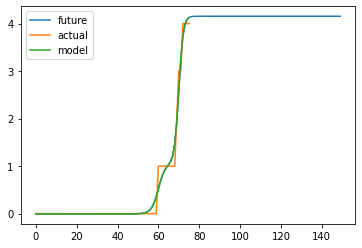

Guam average accuracy: 98.5%


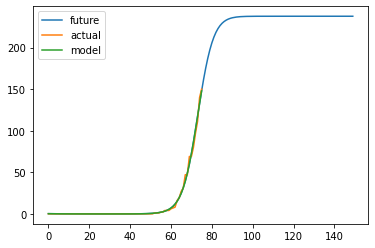

Colorado average accuracy: 99.4%


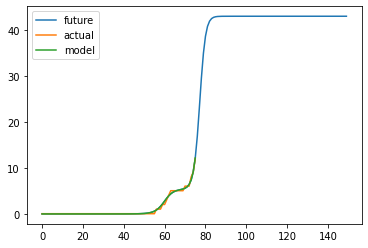

Bangladesh average accuracy: 98.9%


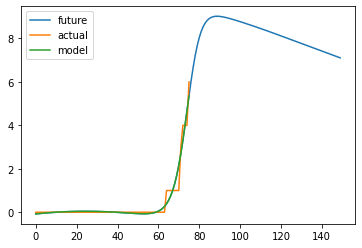

Kenya average accuracy: 98.1%


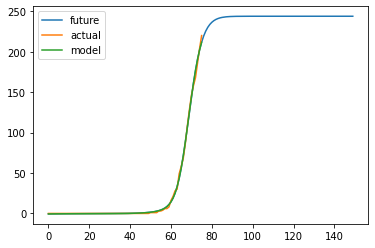

Austria average accuracy: 99.5%


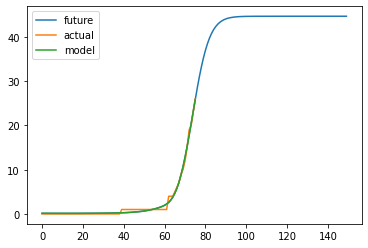

Thailand average accuracy: 98.8%


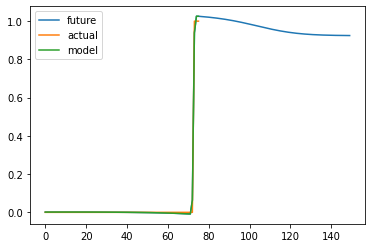

Kuwait average accuracy: 99.6%


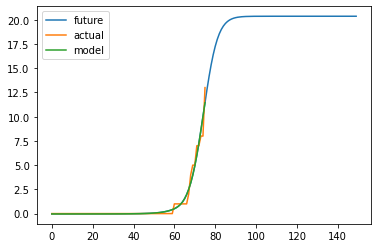

Utah average accuracy: 98.6%


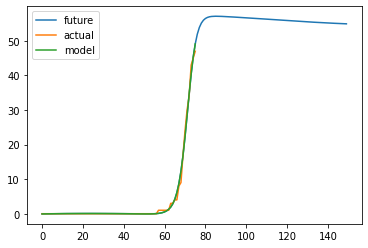

Russia average accuracy: 99.4%


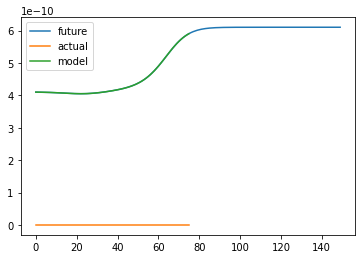

Vietnam average accuracy: 1e+02%


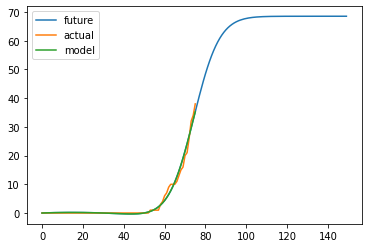

Hungary average accuracy: 98.6%


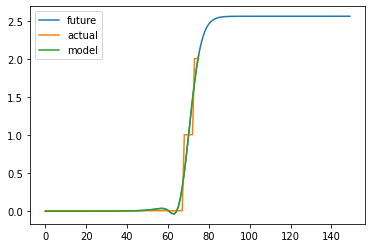

Australian Capital Territory average accuracy: 98.0%


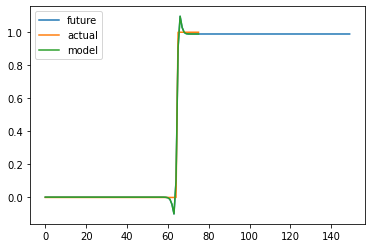

Nicaragua average accuracy: 99.2%


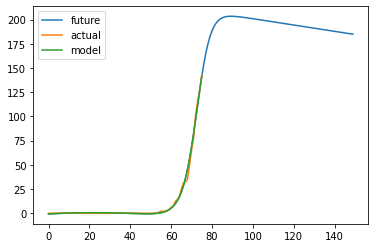

Indiana average accuracy: 99.3%


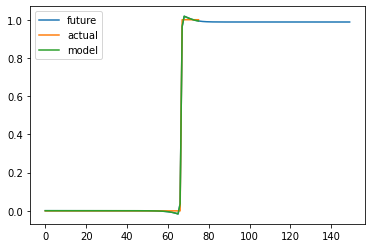

New Zealand average accuracy: 99.7%


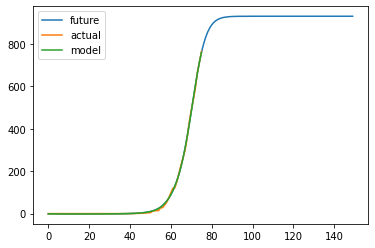

Switzerland average accuracy: 99.6%


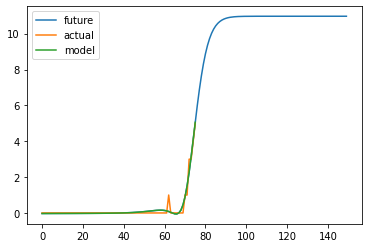

Hawaii average accuracy: 98.4%


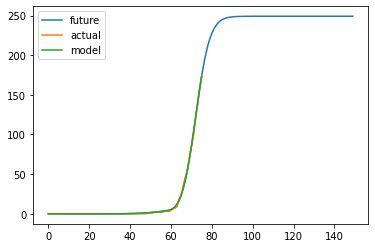

Ireland average accuracy: 99.6%


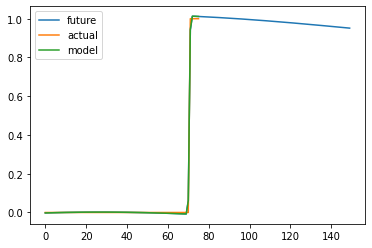

Libya average accuracy: 99.6%


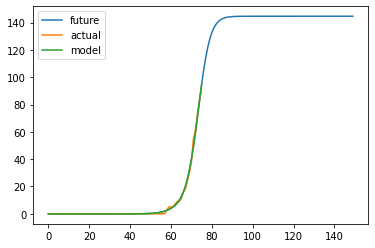

Peru average accuracy: 99.5%


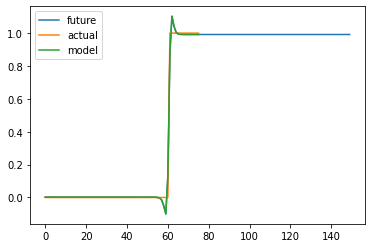

Zimbabwe average accuracy: 99.0%


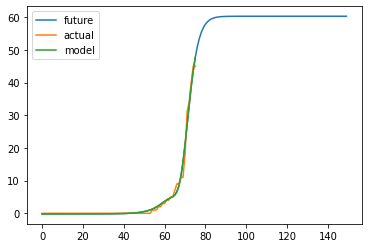

Kentucky average accuracy: 98.9%


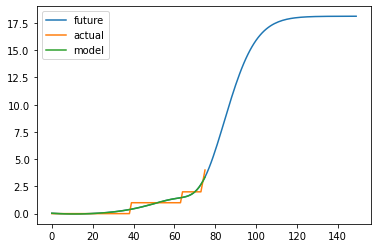

Western Australia average accuracy: 95.1%


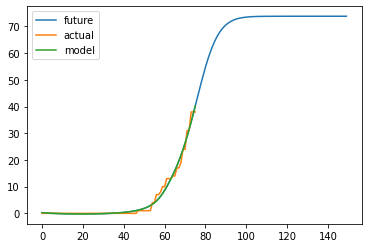

British Columbia average accuracy: 98.2%


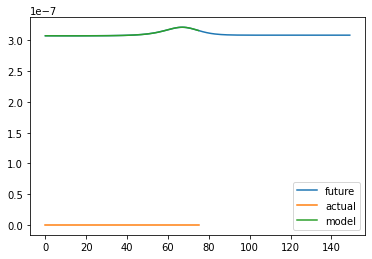

Eritrea average accuracy: 1e+02%


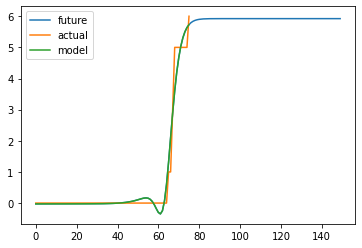

Jordan average accuracy: 97.8%


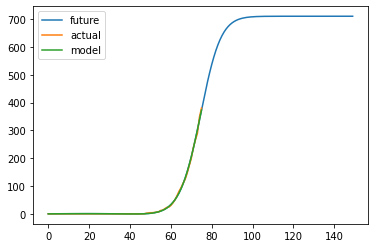

California average accuracy: 99.6%


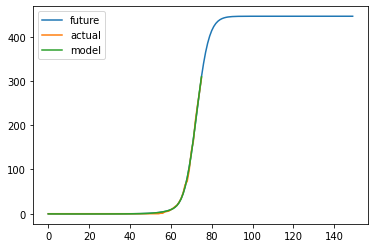

Illinois average accuracy: 99.6%


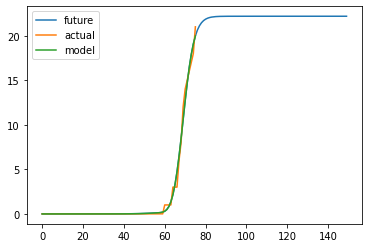

Andorra average accuracy: 99.2%


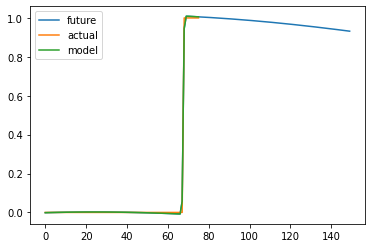

Mauritania average accuracy: 99.6%


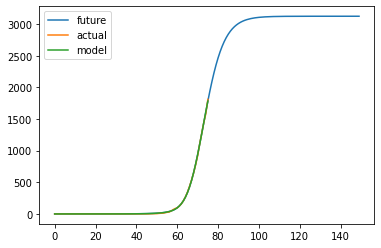

Germany average accuracy: 99.8%


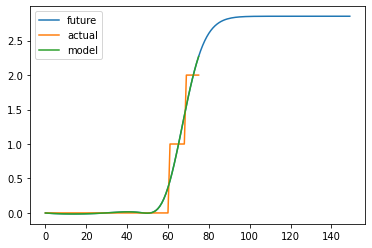

Montenegro average accuracy: 96.5%


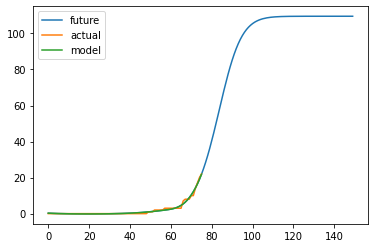

Bulgaria average accuracy: 98.4%


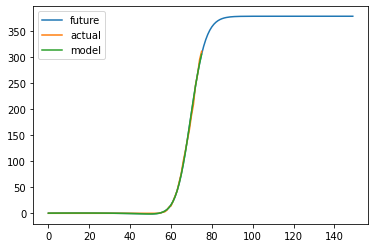

Portugal average accuracy: 99.6%


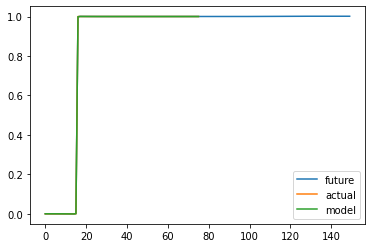

Jilin average accuracy: 1e+02%


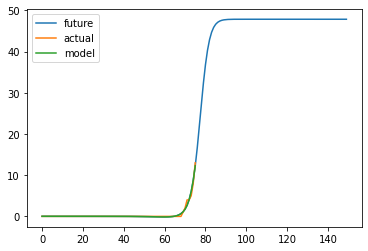

Belarus average accuracy: 99.2%


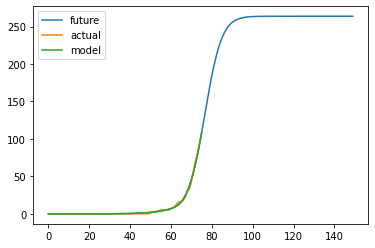

Poland average accuracy: 99.4%


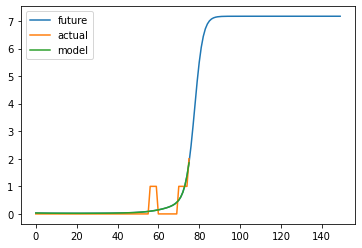

Slovakia average accuracy: 93.7%


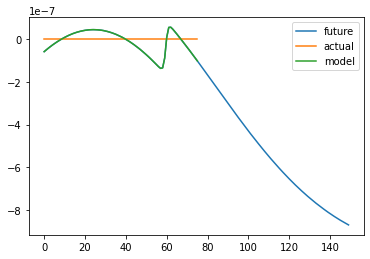

Timor-Leste average accuracy: 1e+02%


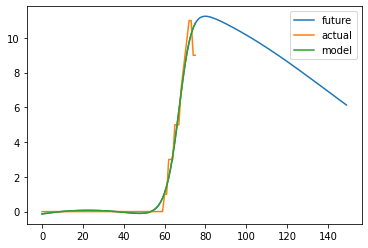

Cyprus average accuracy: 98.0%


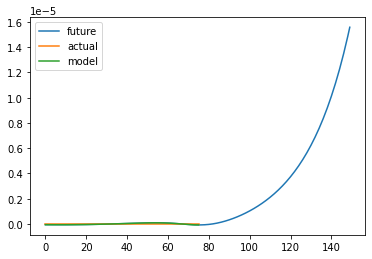

Bhutan average accuracy: 1e+02%


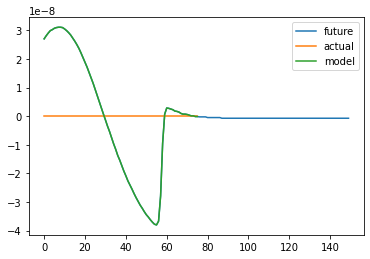

Papua New Guinea average accuracy: 1e+02%


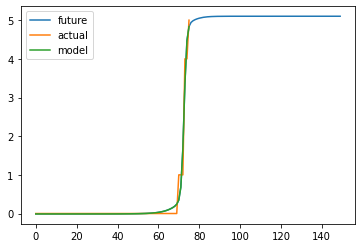

Bahamas average accuracy: 98.8%


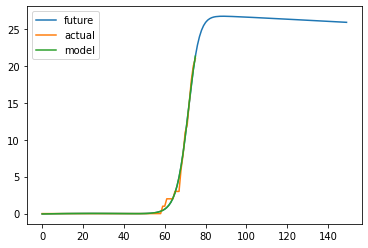

Puerto Rico average accuracy: 99.3%


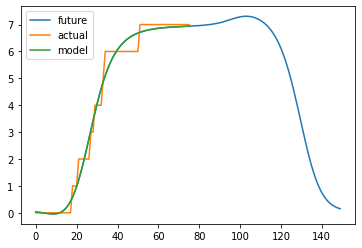

Shandong average accuracy: 96.7%


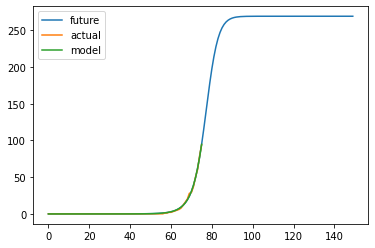

Mexico average accuracy: 99.6%


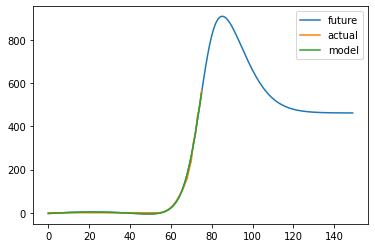

Brazil average accuracy: 99.3%


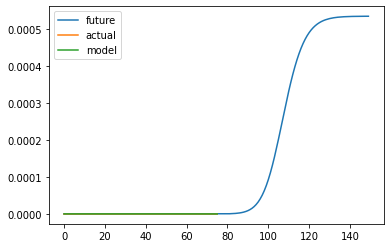

Central African Republic average accuracy: 1e+02%


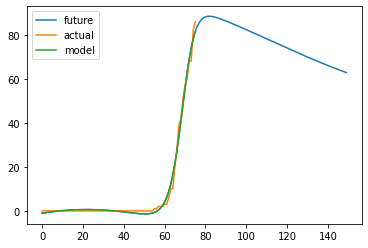

Dominican Republic average accuracy: 98.7%


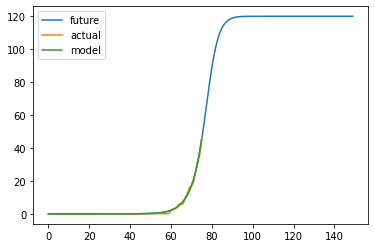

Colombia average accuracy: 99.2%


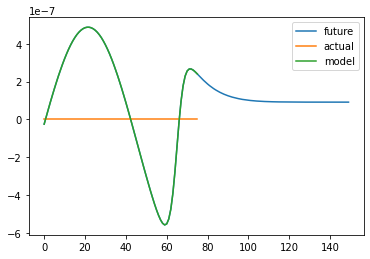

Grenada average accuracy: 1e+02%


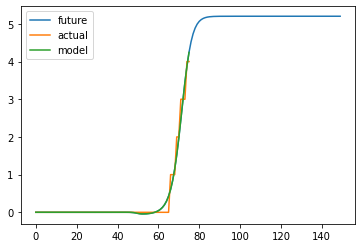

Qatar average accuracy: 98.6%


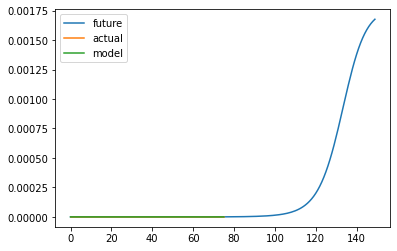

Greenland average accuracy: 1e+02%


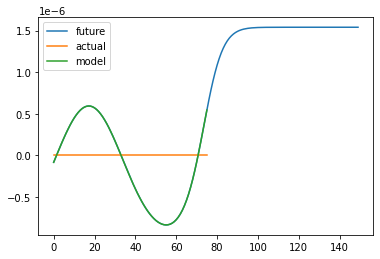

Antigua and Barbuda average accuracy: 1e+02%


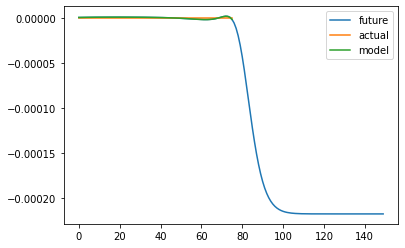

Burundi average accuracy: 99.9%


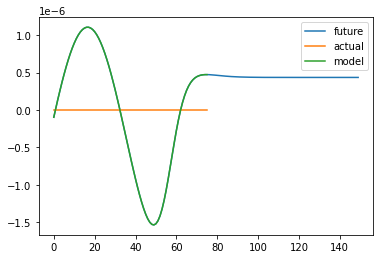

Seychelles average accuracy: 99.9%


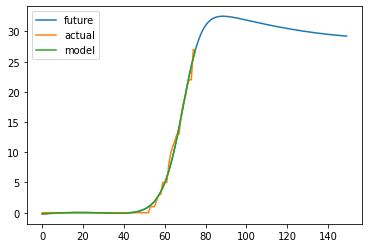

Oregon average accuracy: 98.9%


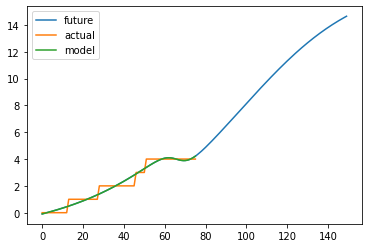

Hong Kong average accuracy: 94.3%


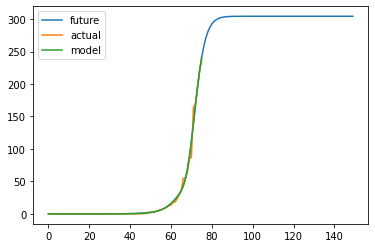

Florida average accuracy: 99.4%


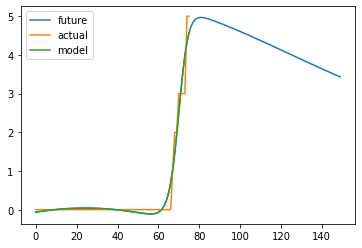

Mali average accuracy: 97.9%


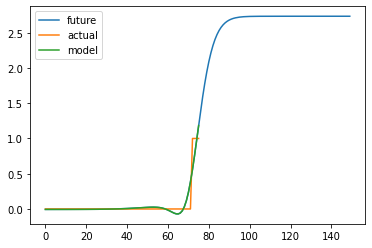

Latvia average accuracy: 96.6%


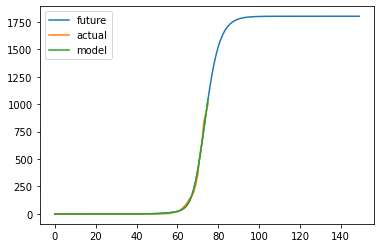

New Jersey average accuracy: 99.5%


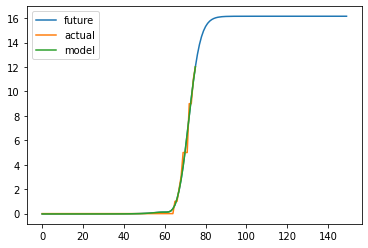

South Africa average accuracy: 99.1%


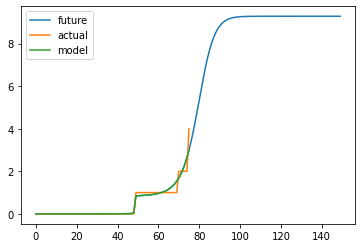

South Dakota average accuracy: 98.1%


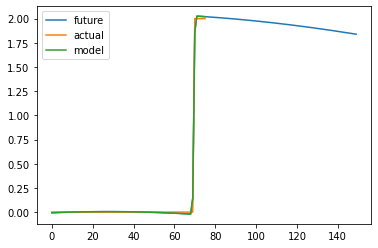

MS Zaandam average accuracy: 99.5%


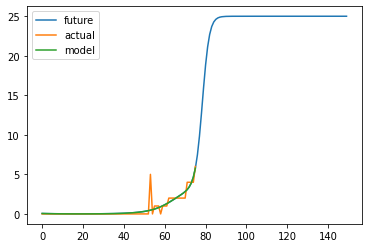

Iceland average accuracy: 96.3%


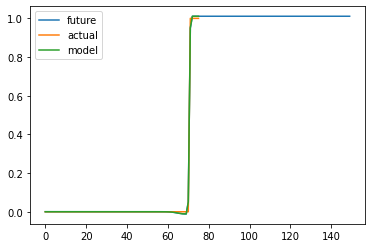

Zambia average accuracy: 99.7%


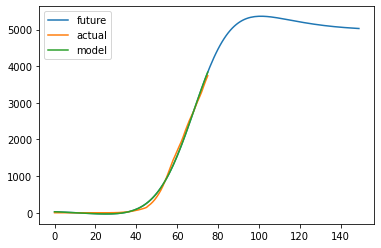

Iran average accuracy: 98.7%


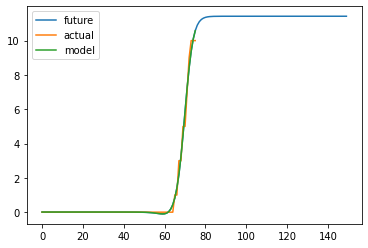

Maine average accuracy: 99.1%


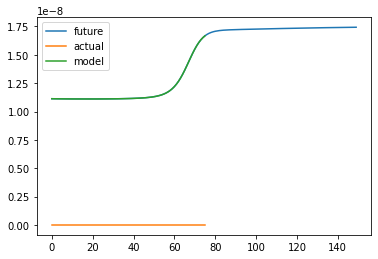

Reunion average accuracy: 1e+02%


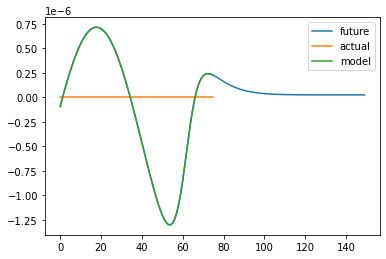

French Polynesia average accuracy: 99.9%


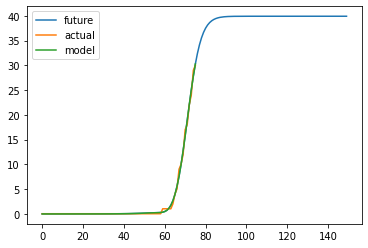

Minnesota average accuracy: 99.4%


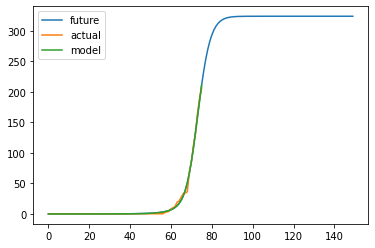

Connecticut average accuracy: 99.4%


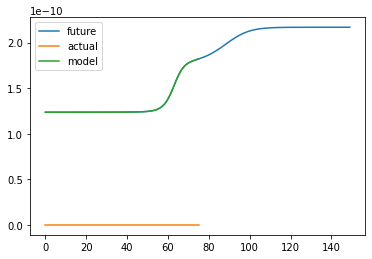

South Australia average accuracy: 1e+02%


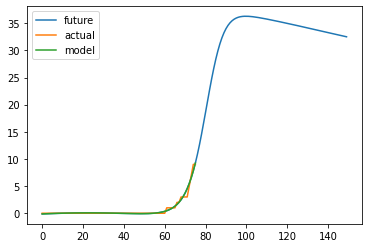

New Hampshire average accuracy: 98.5%


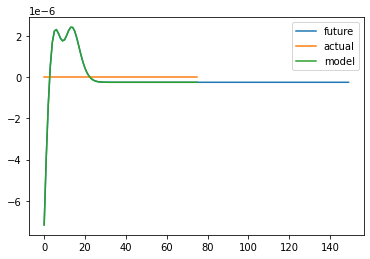

Qinghai average accuracy: 99.9%


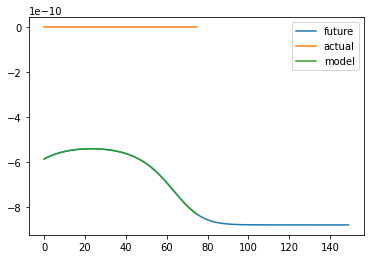

Malta average accuracy: 1e+02%


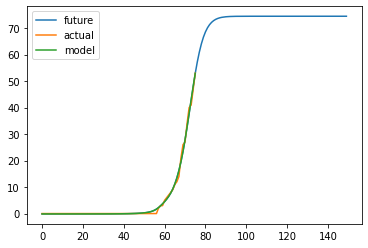

Pakistan average accuracy: 99.3%


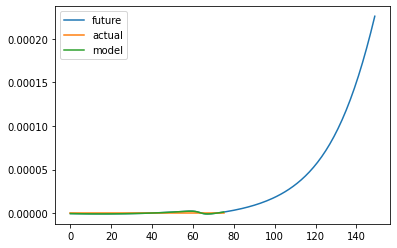

Holy See average accuracy: 99.9%


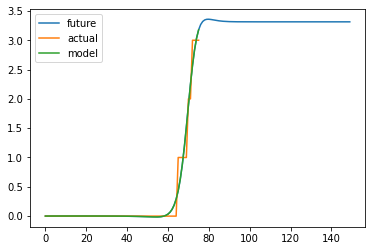

Togo average accuracy: 98.3%


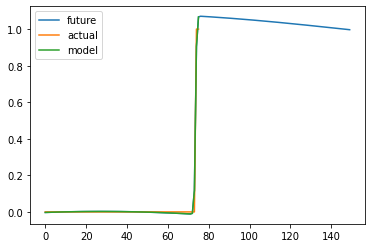

Turks and Caicos Islands average accuracy: 99.4%


In [12]:
# Fatality
for cname in cnames:
    if cname == "Canada":
        continue
    model, powers, casenorm, fatnorm = deepcopy(models[cname])

    import matplotlib.pyplot as plt

    raw = model(torch.Tensor([[pow(xval, i) for i in powers] for xval in list(xbycountry[cname])])).detach()
    predictions = np.array([j.numpy()[1]*fatnorm for j in raw])
    plt.plot(np.array(list(range(150))), np.array([j.numpy()[1]*fatnorm for j in model(torch.Tensor([[pow(xval, i) for i in powers] for xval in list(range(150))])).detach()]), label="future")
    plt.plot(xbycountry[cname], [i[1] for i in ybycountry[cname]], label="actual")
    plt.plot(xbycountry[cname], predictions, label="model")
    # plt.plot(np.array([140 for i in range(200000)]), np.array(list(range(200000))), label="day 70")
    # plt.plot(np.array(list(range(200))), np.array([390000 for i in range(200)]), label="growth slows down")
    plt.xlabel = "Days since 20-01-22"
    plt.ylabel = "Cases"
    plt.legend()
    plt.show()
    # print(f"Will max out at {model(torch.Tensor([[102, 102**2]])).detach().numpy()[0][1]*8e4} infected around May 26 2020")
    print(f"{cname} average accuracy: {100*(1 - np.mean(abs(predictions - [i[1] for i in ybycountry[cname]]))/fatnorm):.3}%")
    del plt

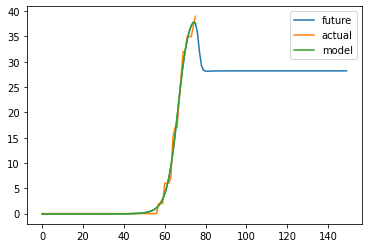

Bermuda average accuracy: 99.6%


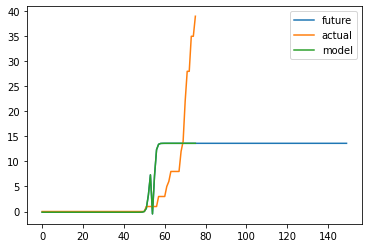

Cayman Islands average accuracy: 97.0%


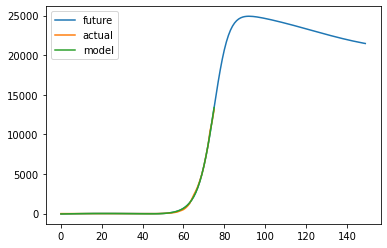

Pennsylvania average accuracy: 99.7%


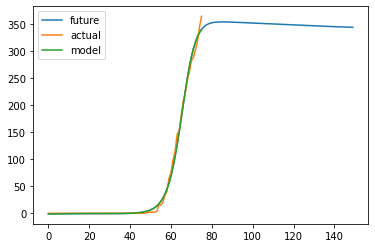

Burkina Faso average accuracy: 99.1%


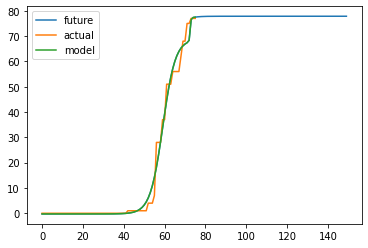

Liechtenstein average accuracy: 98.5%


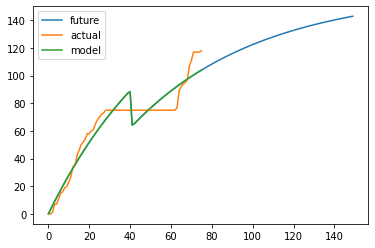

Inner Mongolia average accuracy: 94.3%


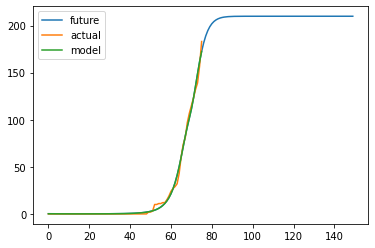

Bolivia average accuracy: 99.2%


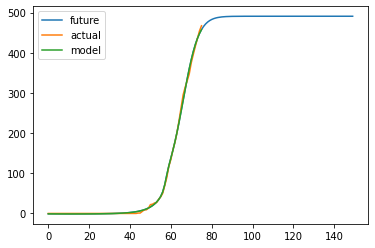

Costa Rica average accuracy: 99.5%


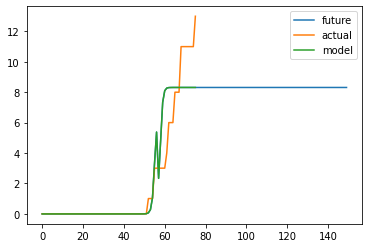

Curacao average accuracy: 99.3%


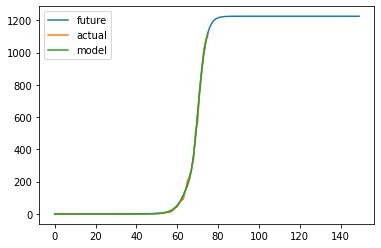

Idaho average accuracy: 99.6%


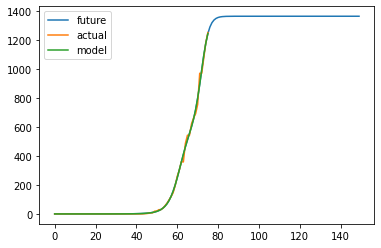

Alberta average accuracy: 99.5%


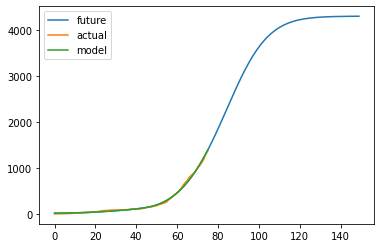

Singapore average accuracy: 99.0%


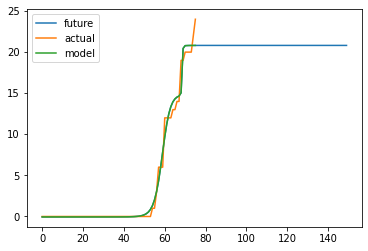

Tanzania average accuracy: 99.6%


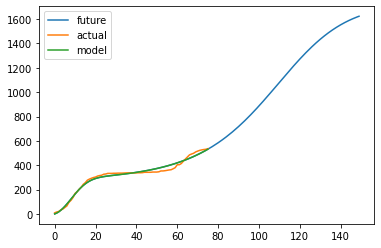

Shanghai average accuracy: 97.1%


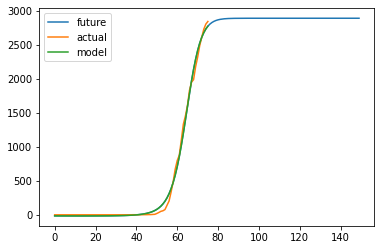

Luxembourg average accuracy: 98.8%


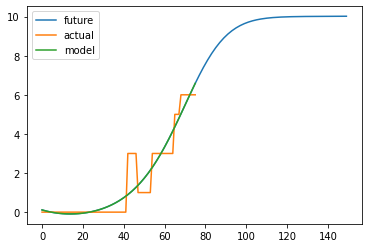

Saint Barthelemy average accuracy: 99.6%


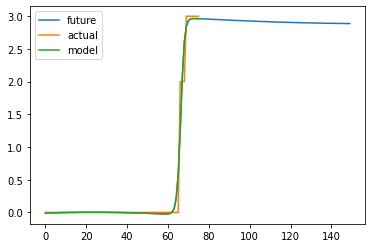

British Virgin Islands average accuracy: 1e+02%


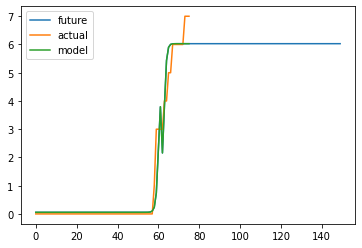

Cabo Verde average accuracy: 99.8%


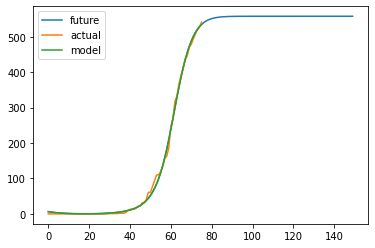

Lebanon average accuracy: 99.2%


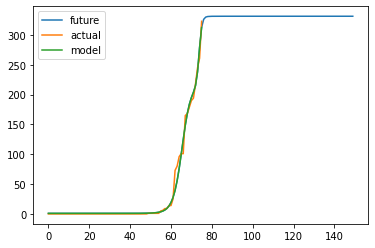

Cote d'Ivoire average accuracy: 99.0%


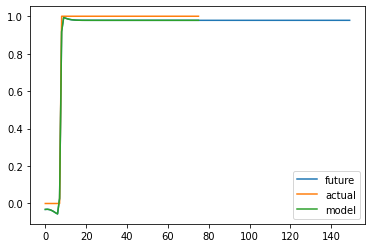

Tibet average accuracy: 1e+02%


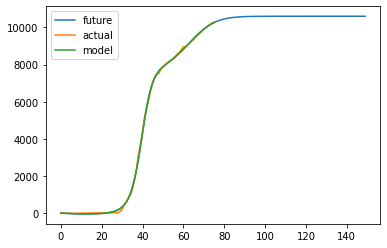

Korea, South average accuracy: 99.5%


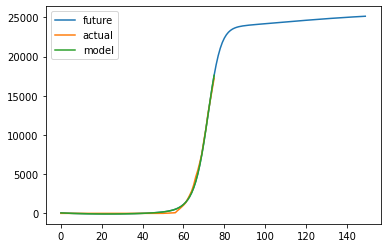

Michigan average accuracy: 99.3%


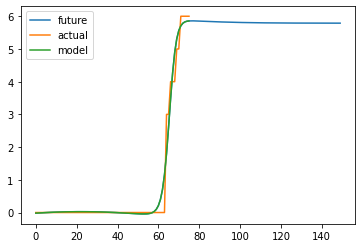

Yukon average accuracy: 99.9%


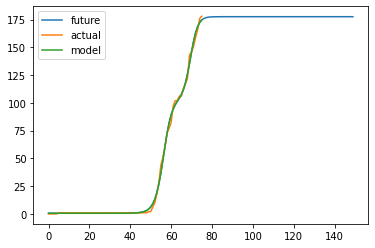

Sri Lanka average accuracy: 99.2%


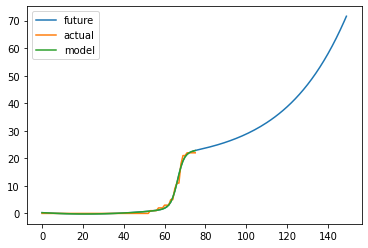

Prince Edward Island average accuracy: 99.7%


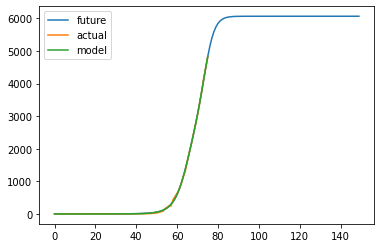

Chile average accuracy: 99.8%


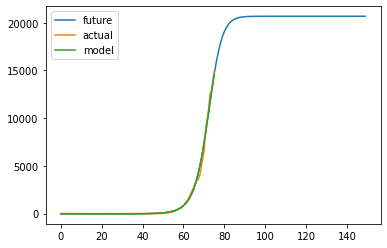

Louisiana average accuracy: 99.3%


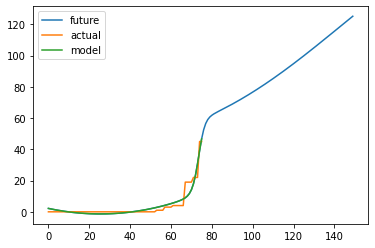

Congo (Brazzaville) average accuracy: 98.2%


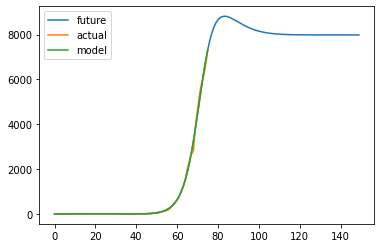

Georgia average accuracy: 99.6%


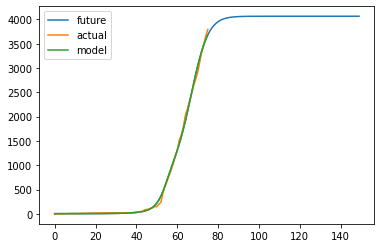

Malaysia average accuracy: 99.4%


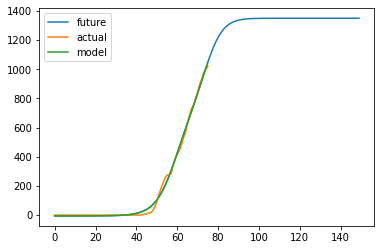

Slovenia average accuracy: 98.8%


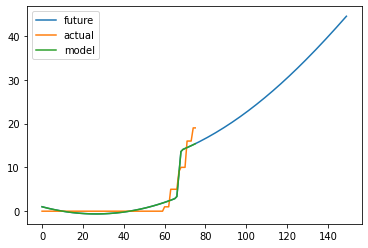

Syria average accuracy: 99.1%


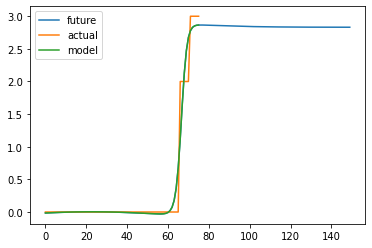

Anguilla average accuracy: 99.9%


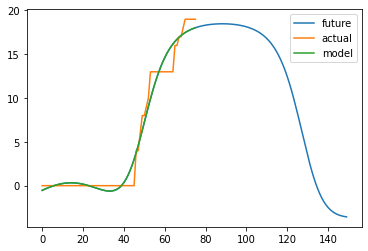

Maldives average accuracy: 99.2%


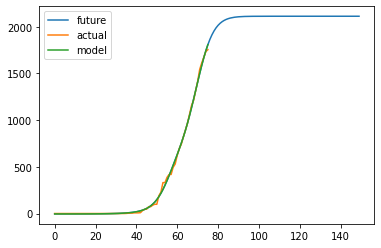

Greece average accuracy: 99.4%


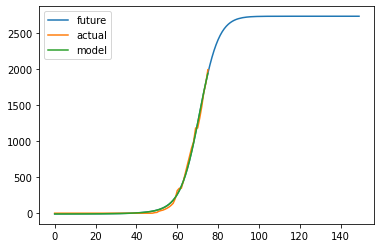

Panama average accuracy: 99.1%


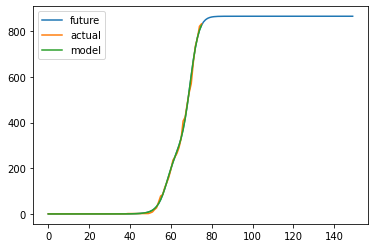

Armenia average accuracy: 99.5%


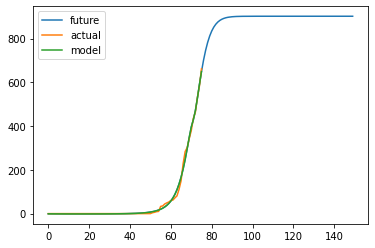

Kazakhstan average accuracy: 99.3%


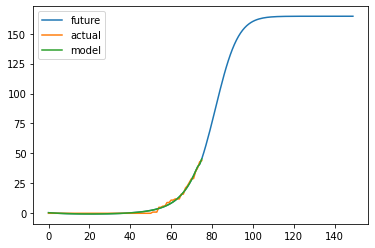

Ethiopia average accuracy: 99.2%


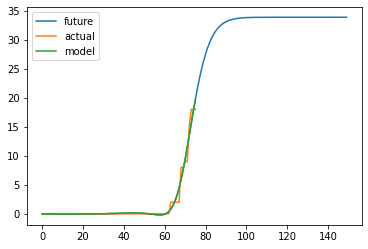

Guinea-Bissau average accuracy: 99.7%


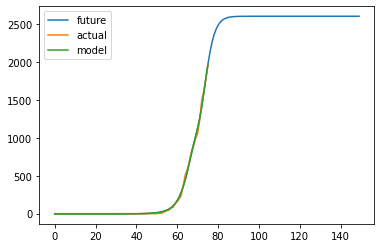

Alabama average accuracy: 99.5%


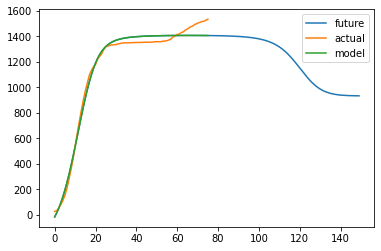

Guangdong average accuracy: 97.3%


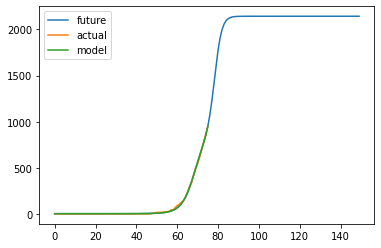

Iowa average accuracy: 99.4%


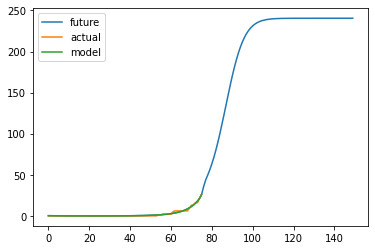

Benin average accuracy: 99.6%


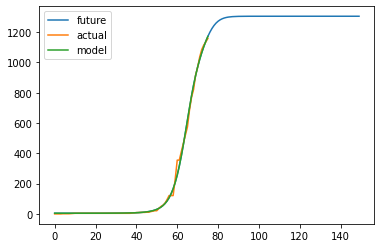

Victoria average accuracy: 99.4%


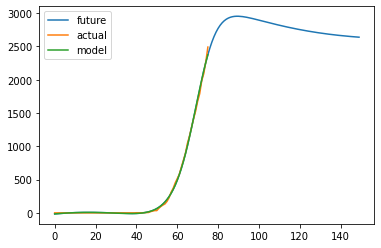

Indonesia average accuracy: 99.5%


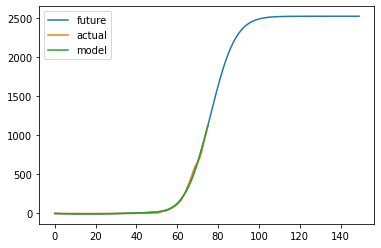

Morocco average accuracy: 99.2%


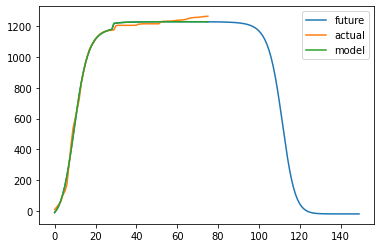

Zhejiang average accuracy: 98.8%


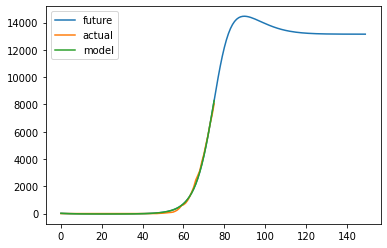

Texas average accuracy: 99.3%


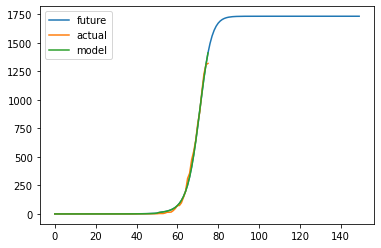

Ukraine average accuracy: 99.4%


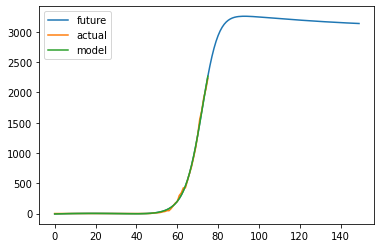

South Carolina average accuracy: 99.6%


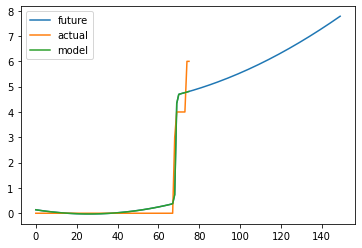

Botswana average accuracy: 99.8%


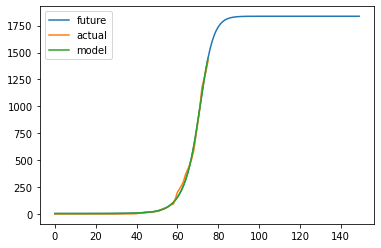

Algeria average accuracy: 99.3%


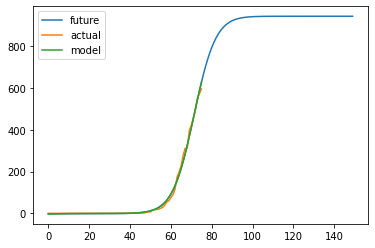

Tunisia average accuracy: 99.1%


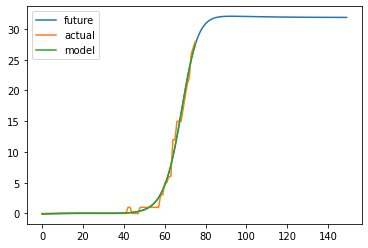

Northern Territory average accuracy: 99.6%


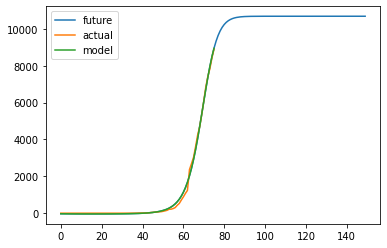

Israel average accuracy: 99.2%


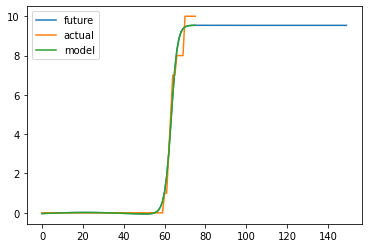

Mozambique average accuracy: 99.8%


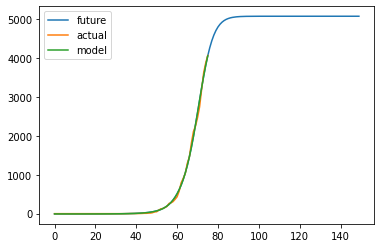

Romania average accuracy: 99.5%


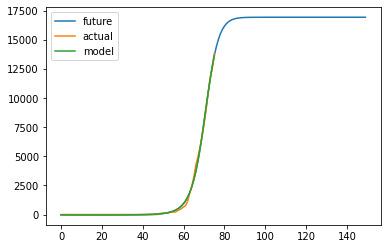

Massachusetts average accuracy: 99.5%


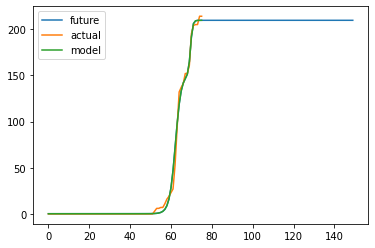

Ghana average accuracy: 99.1%


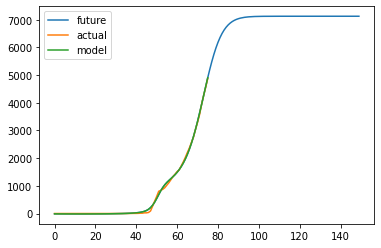

Denmark average accuracy: 99.4%


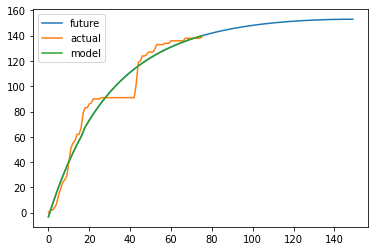

Gansu average accuracy: 95.2%


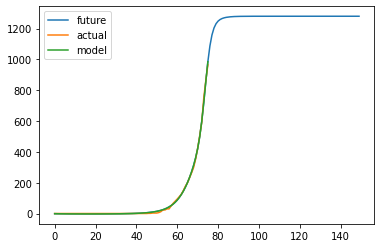

Moldova average accuracy: 99.6%


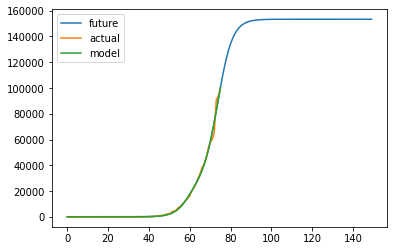

France average accuracy: 99.4%


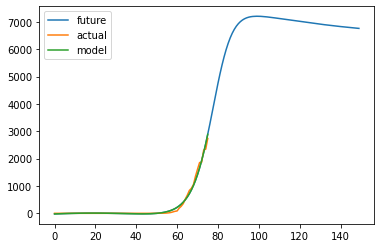

Missouri average accuracy: 98.8%


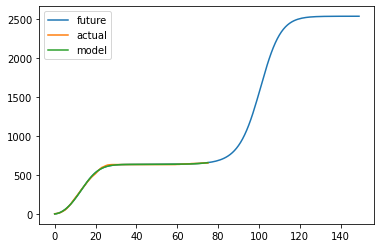

Jiangsu average accuracy: 99.4%


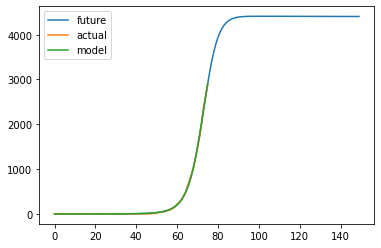

Virginia average accuracy: 99.7%


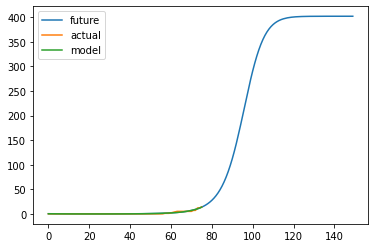

Fiji average accuracy: 99.6%


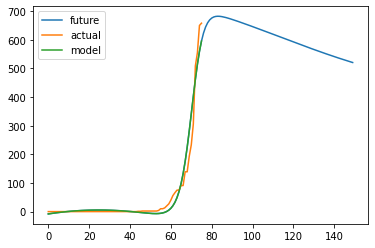

Cameroon average accuracy: 97.7%


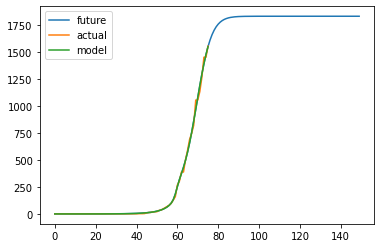

Argentina average accuracy: 99.5%


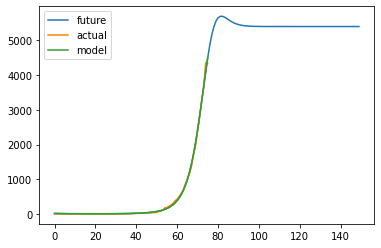

Ontario average accuracy: 99.6%


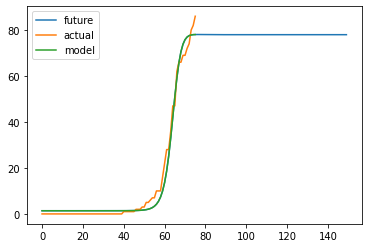

Tasmania average accuracy: 97.7%


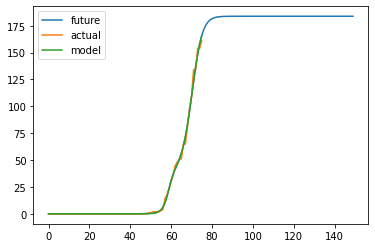

Congo (Kinshasa) average accuracy: 99.4%


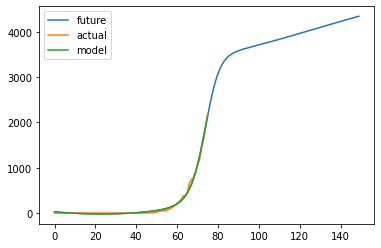

Serbia average accuracy: 99.0%


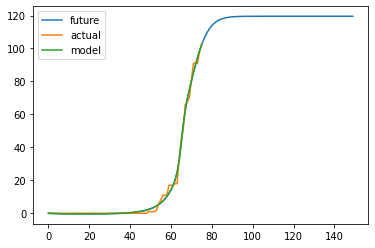

New Brunswick average accuracy: 98.9%


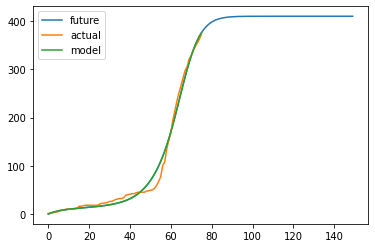

Taiwan* average accuracy: 97.9%


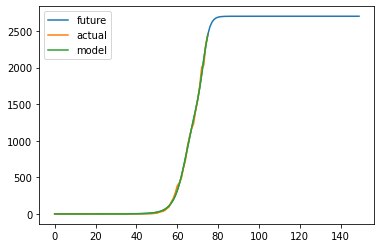

Wisconsin average accuracy: 99.6%


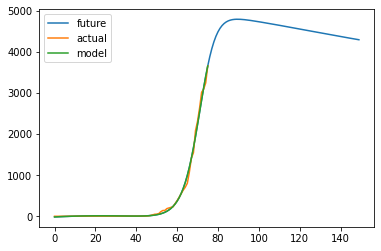

Philippines average accuracy: 99.3%


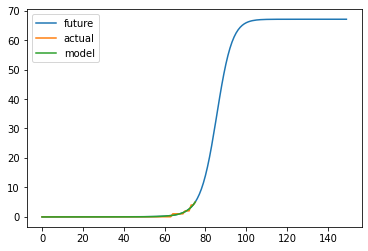

Northwest Territories average accuracy: 99.9%


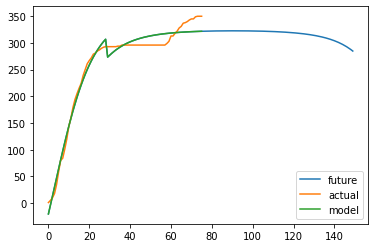

Fujian average accuracy: 96.7%


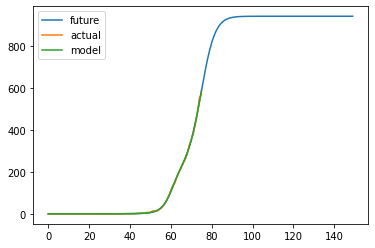

North Macedonia average accuracy: 99.7%


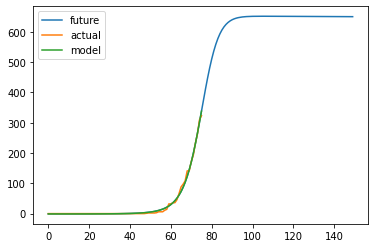

Channel Islands average accuracy: 99.1%


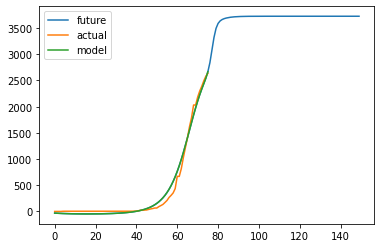

New South Wales average accuracy: 97.6%


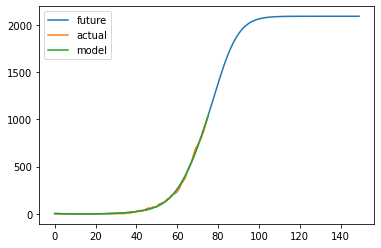

Iraq average accuracy: 99.4%


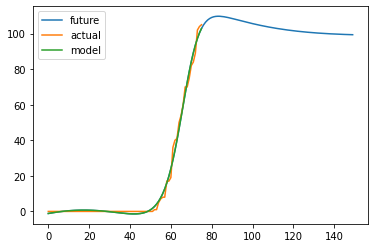

Rwanda average accuracy: 98.6%


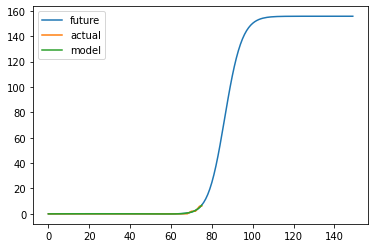

Sierra Leone average accuracy: 99.9%


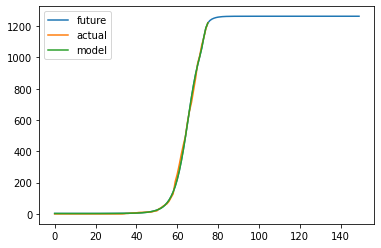

Croatia average accuracy: 99.5%


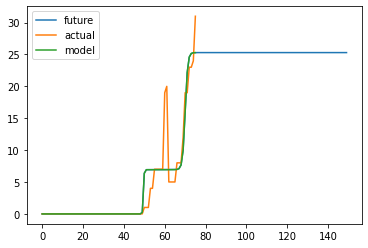

Guyana average accuracy: 99.0%


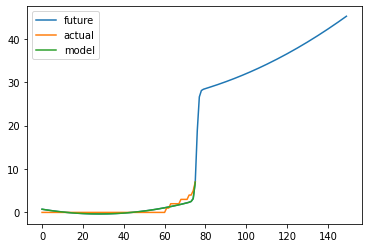

Belize average accuracy: 99.6%


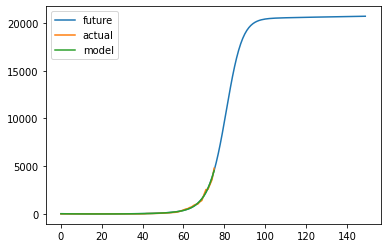

India average accuracy: 99.3%


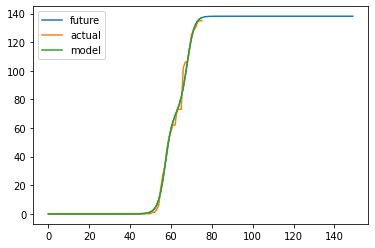

Guadeloupe average accuracy: 99.2%


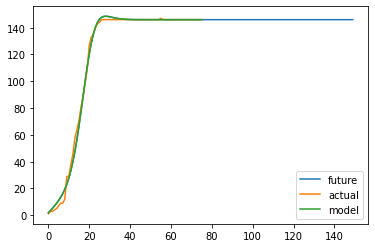

Guizhou average accuracy: 99.0%


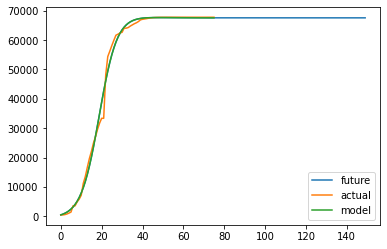

Hubei average accuracy: 98.6%


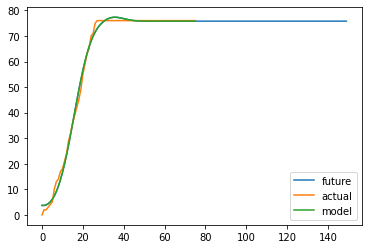

Xinjiang average accuracy: 99.0%


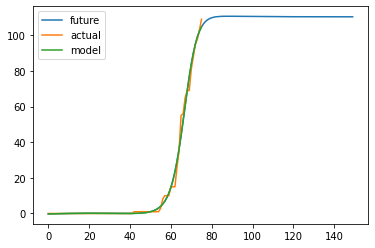

Gibraltar average accuracy: 99.0%


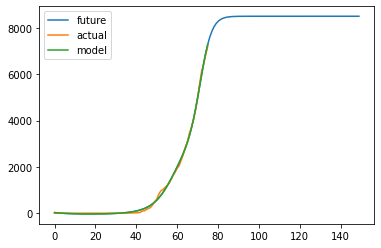

Sweden average accuracy: 99.4%


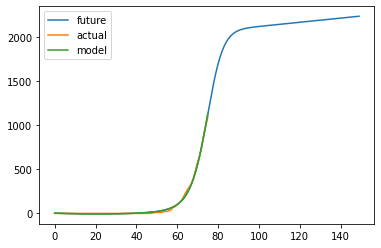

District of Columbia average accuracy: 99.3%


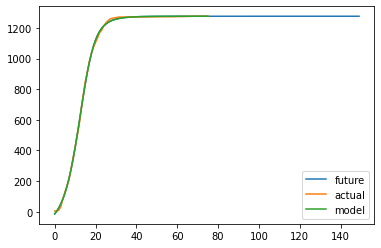

Henan average accuracy: 99.6%


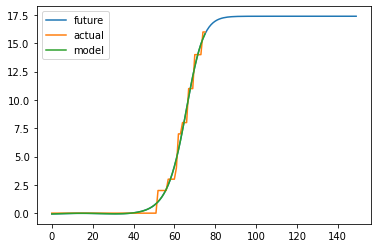

Namibia average accuracy: 99.7%


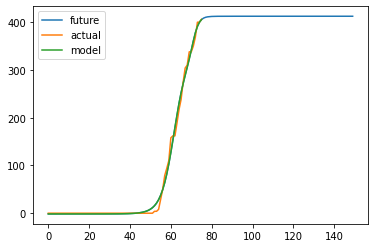

Uruguay average accuracy: 98.8%


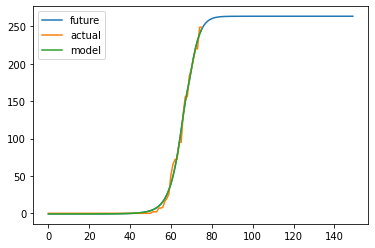

Saskatchewan average accuracy: 99.0%


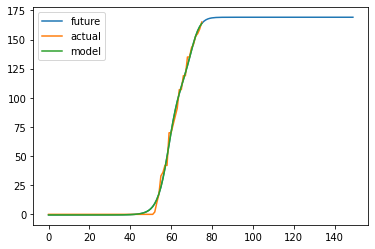

Venezuela average accuracy: 99.0%


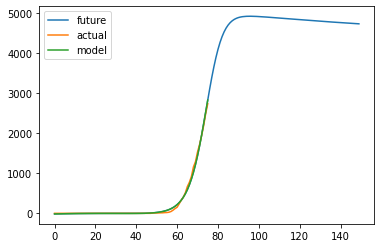

Arizona average accuracy: 99.3%


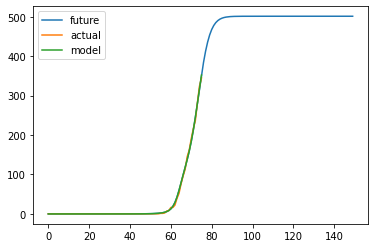

West Virginia average accuracy: 99.6%


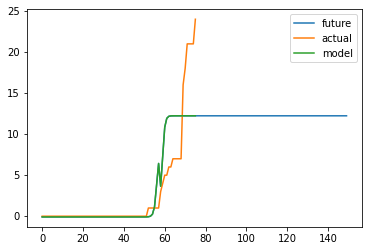

Gabon average accuracy: 98.3%


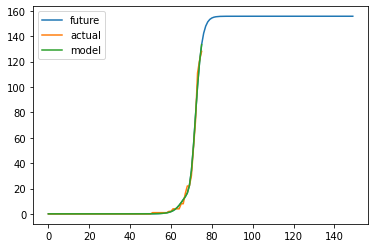

Guinea average accuracy: 99.4%


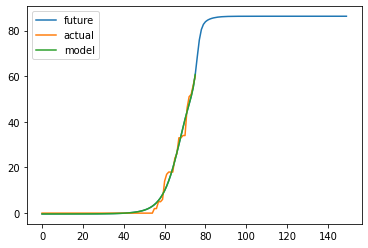

Barbados average accuracy: 99.0%


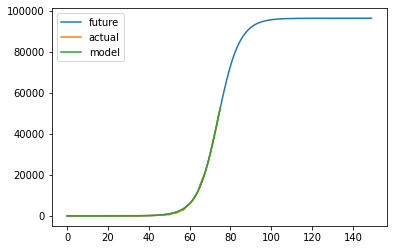

United Kingdom average accuracy: 99.7%


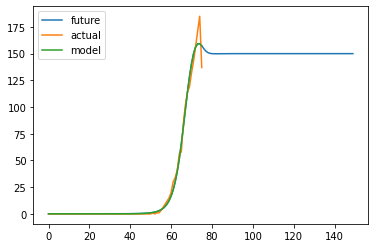

Alaska average accuracy: 99.0%


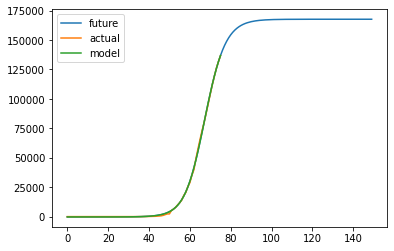

Spain average accuracy: 99.7%


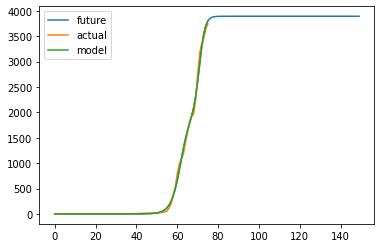

Ecuador average accuracy: 99.4%


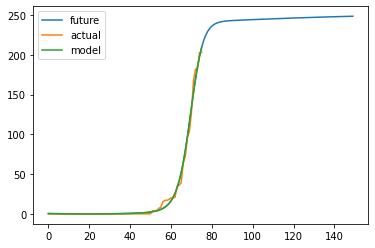

Manitoba average accuracy: 99.0%


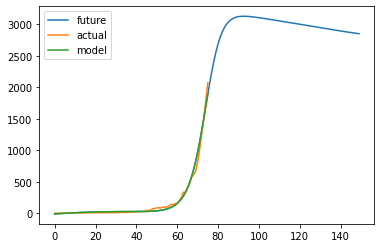

United Arab Emirates average accuracy: 98.8%


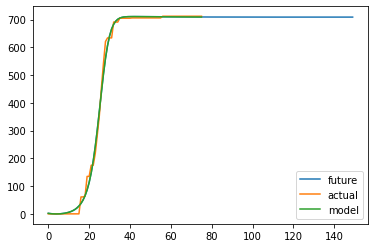

Diamond Princess average accuracy: 98.8%


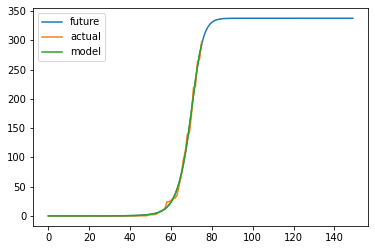

Honduras average accuracy: 99.3%


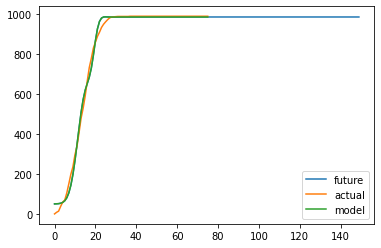

Anhui average accuracy: 98.7%


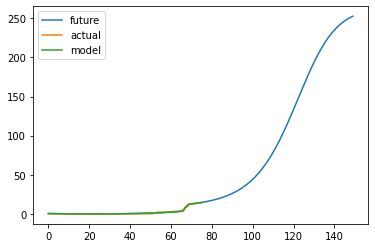

Saint Lucia average accuracy: 99.7%


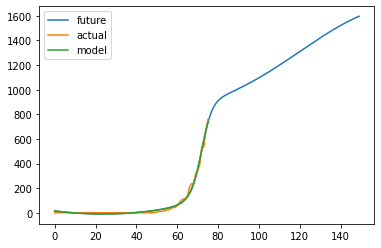

New Mexico average accuracy: 98.5%


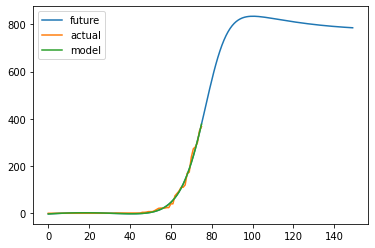

Afghanistan average accuracy: 98.8%


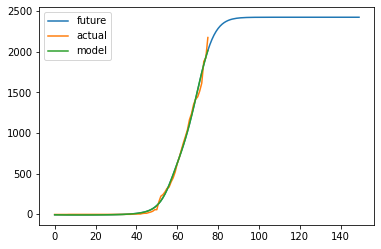

Finland average accuracy: 99.1%


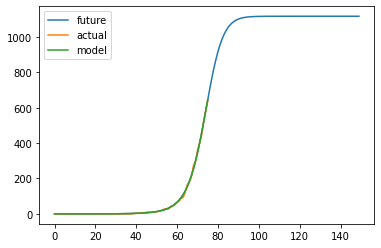

Azerbaijan average accuracy: 99.6%


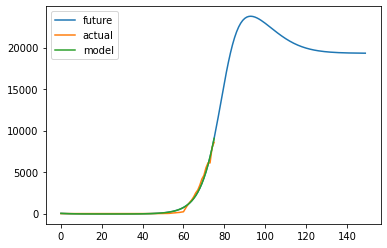

Quebec average accuracy: 98.7%


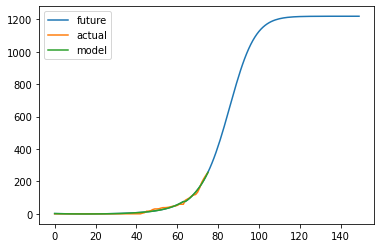

West Bank and Gaza average accuracy: 98.5%


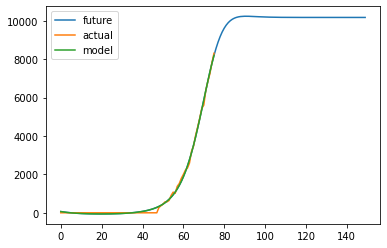

Washington average accuracy: 99.2%


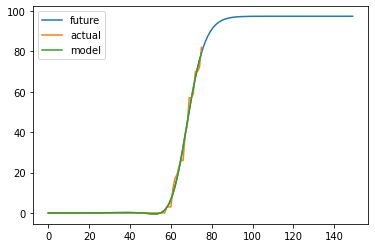

Madagascar average accuracy: 99.3%


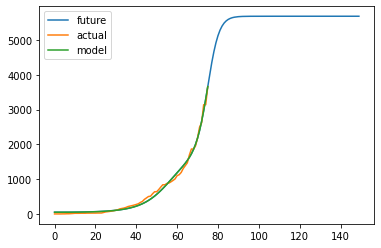

Japan average accuracy: 98.4%


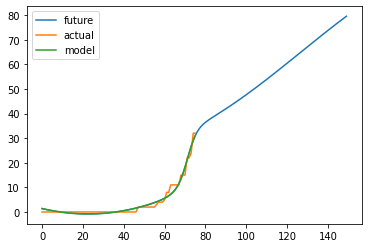

St Martin average accuracy: 99.1%


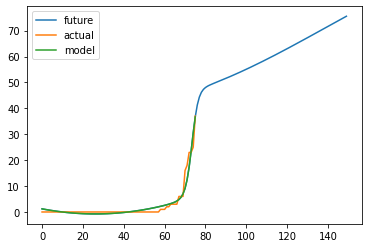

Sint Maarten average accuracy: 99.0%


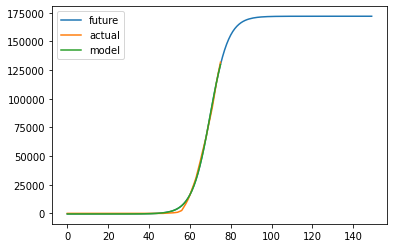

New York average accuracy: 99.3%


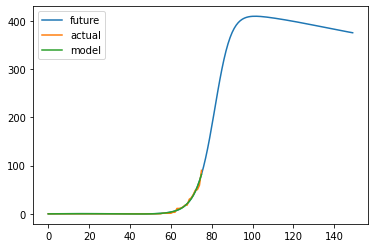

Djibouti average accuracy: 99.2%


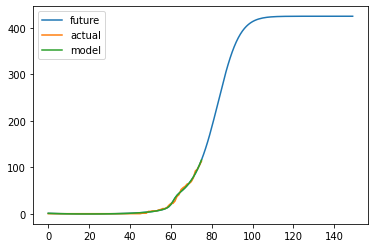

Paraguay average accuracy: 98.9%


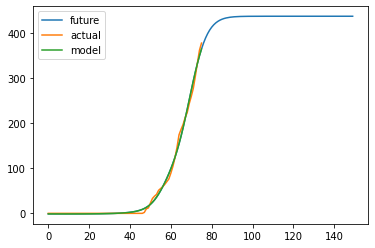

Albania average accuracy: 98.9%


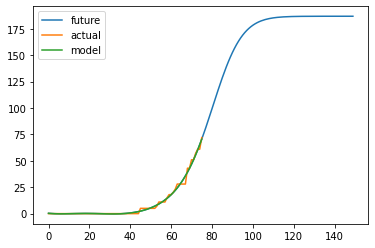

French Guiana average accuracy: 99.1%


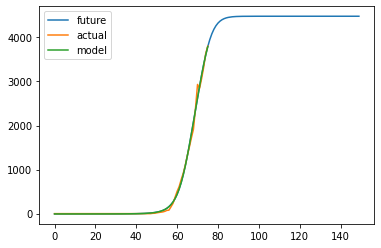

Tennessee average accuracy: 99.4%


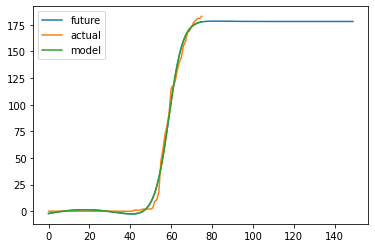

Faroe Islands average accuracy: 98.4%


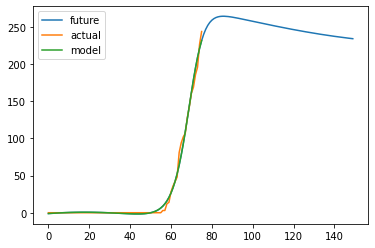

Mauritius average accuracy: 99.0%


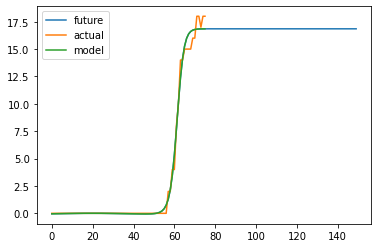

New Caledonia average accuracy: 99.8%


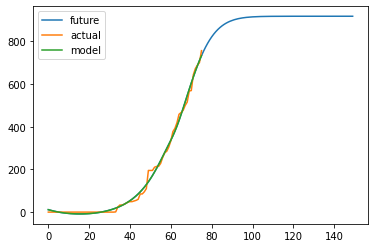

Bahrain average accuracy: 98.6%


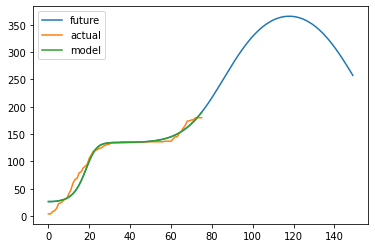

Tianjin average accuracy: 96.9%


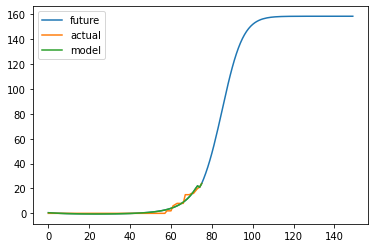

Haiti average accuracy: 99.2%


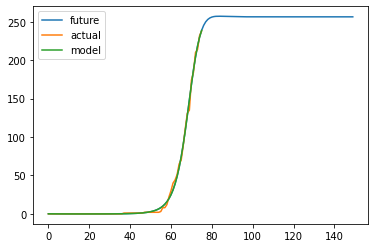

Nigeria average accuracy: 99.4%


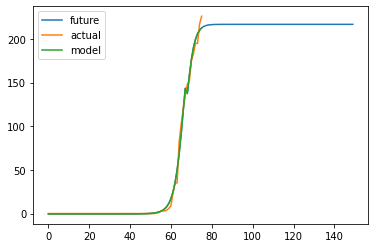

Newfoundland and Labrador average accuracy: 99.1%


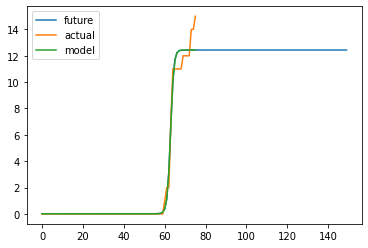

Dominica average accuracy: 99.8%


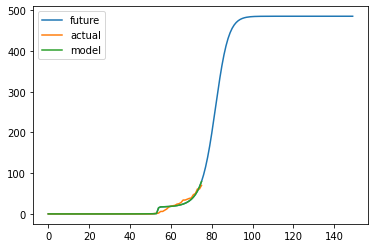

Guatemala average accuracy: 98.2%


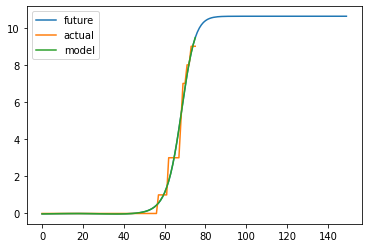

Chad average accuracy: 99.8%


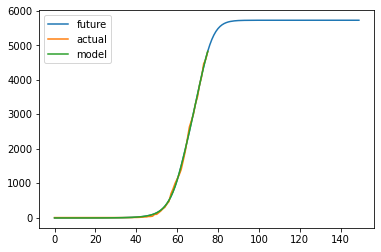

Czechia average accuracy: 99.5%


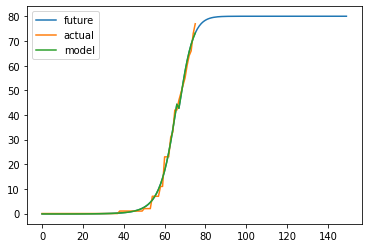

Monaco average accuracy: 99.2%


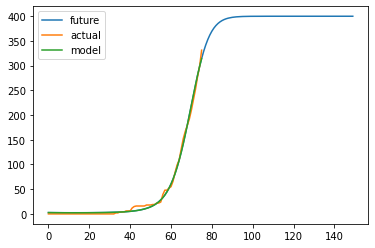

Oman average accuracy: 98.8%


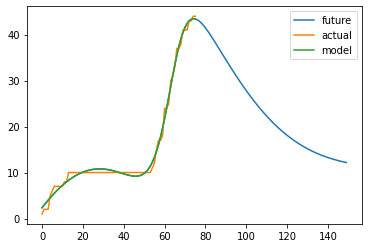

Macau average accuracy: 99.3%


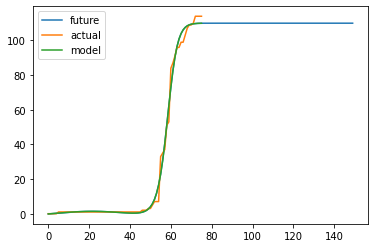

Cambodia average accuracy: 98.6%


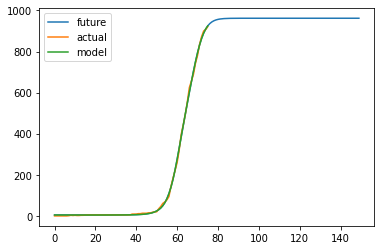

Queensland average accuracy: 99.6%


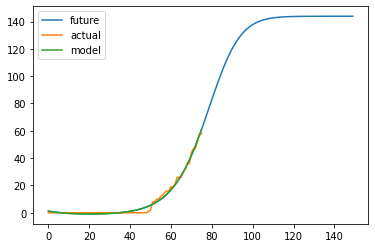

Jamaica average accuracy: 98.8%


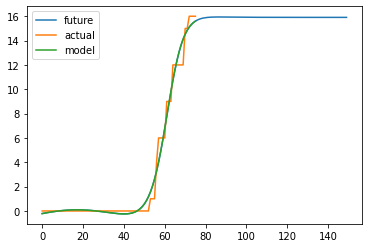

Equatorial Guinea average accuracy: 99.6%


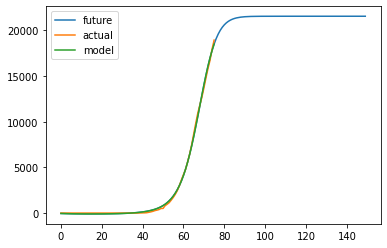

Netherlands average accuracy: 99.4%


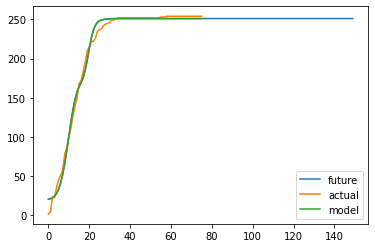

Guangxi average accuracy: 98.3%


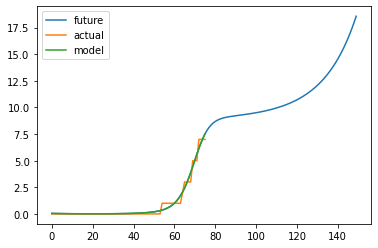

Somalia average accuracy: 99.8%


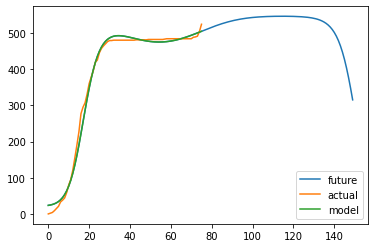

Heilongjiang average accuracy: 98.2%


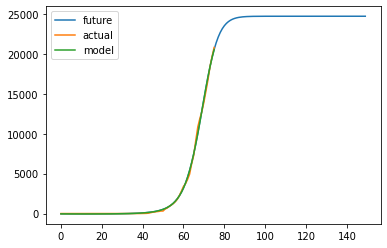

Belgium average accuracy: 99.5%


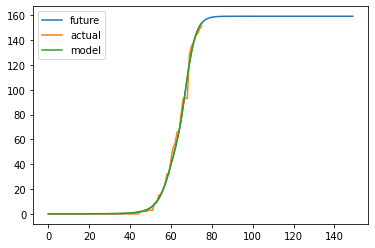

Martinique average accuracy: 99.0%


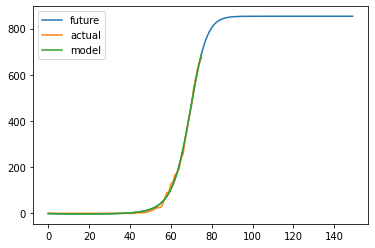

Bosnia and Herzegovina average accuracy: 99.3%


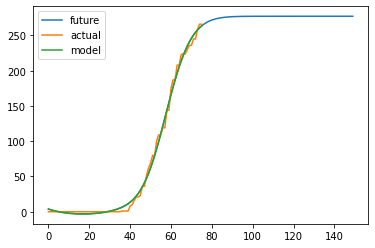

San Marino average accuracy: 98.5%


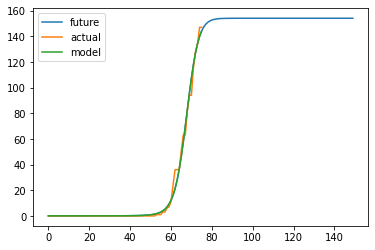

Mayotte average accuracy: 99.1%


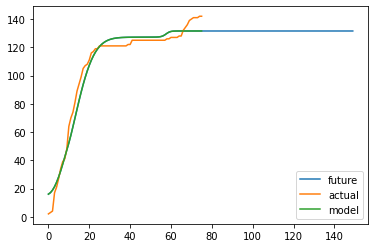

Liaoning average accuracy: 96.3%


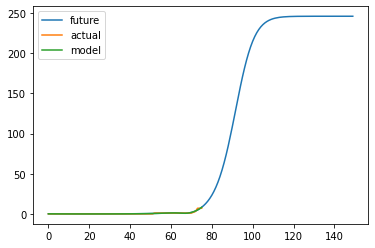

Saint Vincent and the Grenadines average accuracy: 99.8%


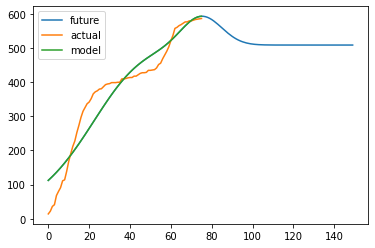

Beijing average accuracy: 93.7%


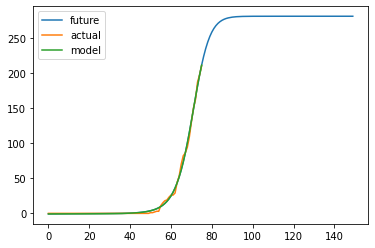

Wyoming average accuracy: 99.2%


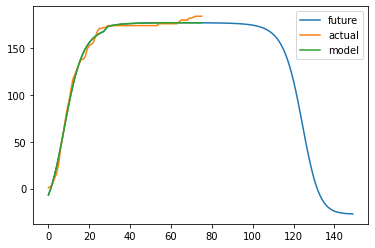

Yunnan average accuracy: 98.4%


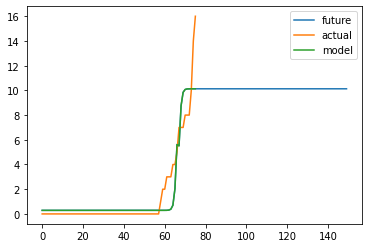

Angola average accuracy: 99.3%


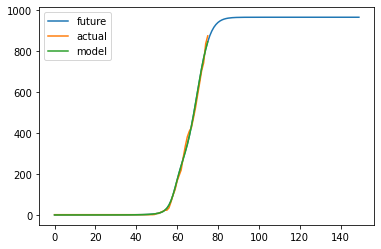

Arkansas average accuracy: 99.4%


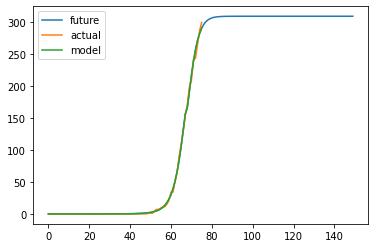

Montana average accuracy: 99.5%


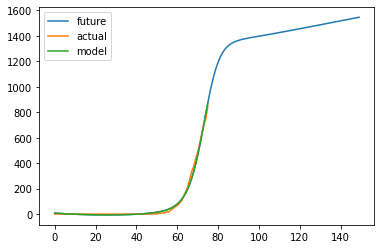

Kansas average accuracy: 98.9%


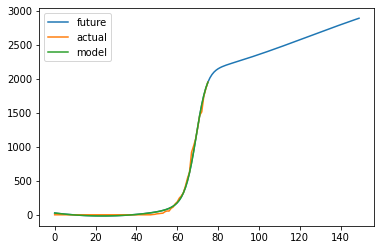

Nevada average accuracy: 99.0%


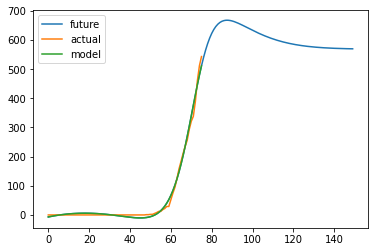

Vermont average accuracy: 98.6%


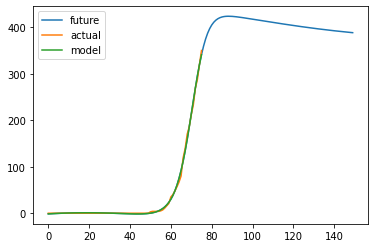

Cuba average accuracy: 99.5%


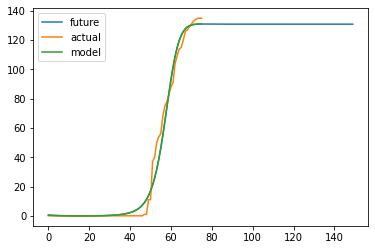

Brunei average accuracy: 97.7%


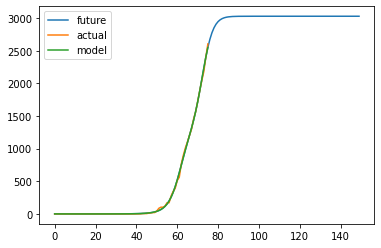

Saudi Arabia average accuracy: 99.7%


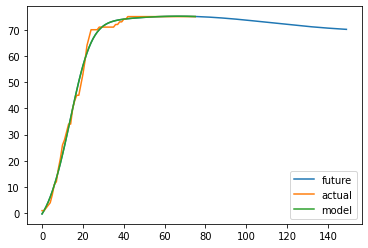

Ningxia average accuracy: 99.0%


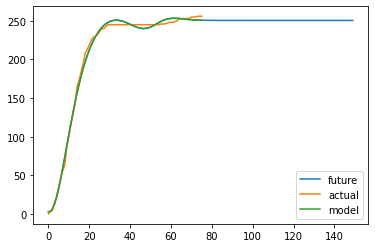

Shaanxi average accuracy: 98.6%


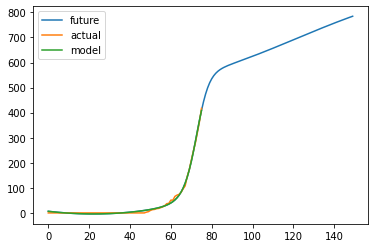

Nebraska average accuracy: 99.1%


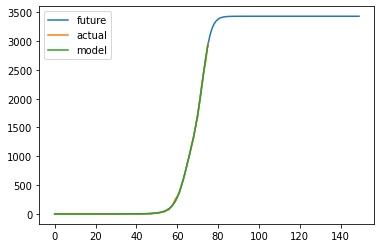

North Carolina average accuracy: 99.8%


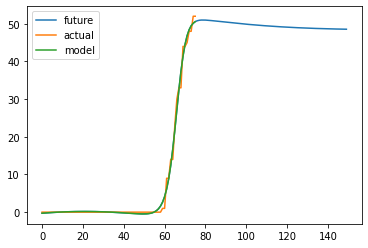

Uganda average accuracy: 99.4%


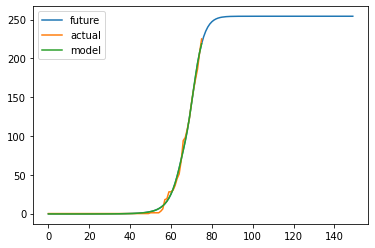

North Dakota average accuracy: 99.3%


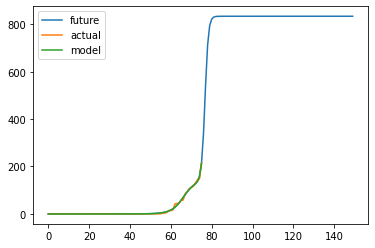

Kyrgyzstan average accuracy: 99.3%


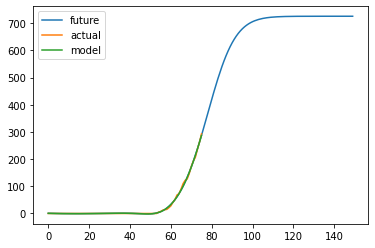

Nova Scotia average accuracy: 99.5%


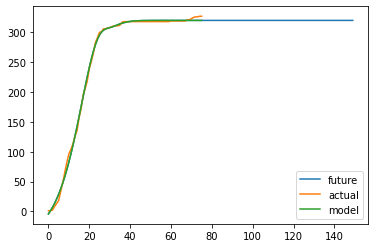

Hebei average accuracy: 99.1%


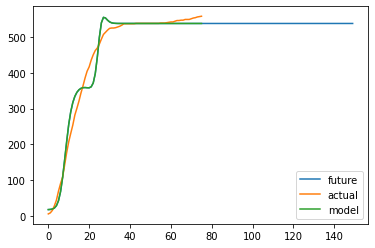

Sichuan average accuracy: 96.9%


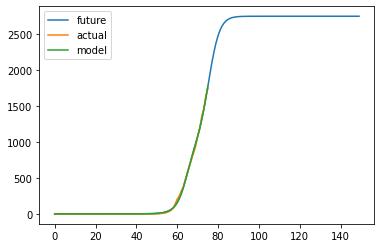

Mississippi average accuracy: 99.6%


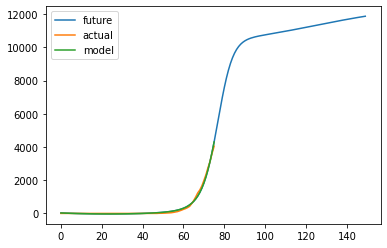

Maryland average accuracy: 98.9%


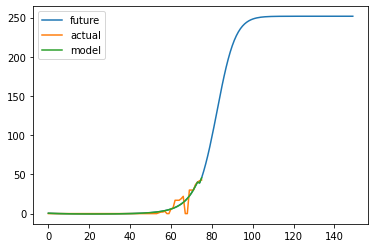

Virgin Islands average accuracy: 98.3%


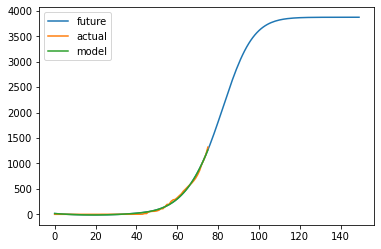

Egypt average accuracy: 98.8%


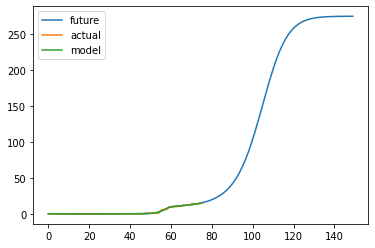

Mongolia average accuracy: 99.7%


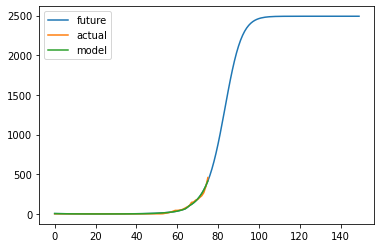

Uzbekistan average accuracy: 98.9%


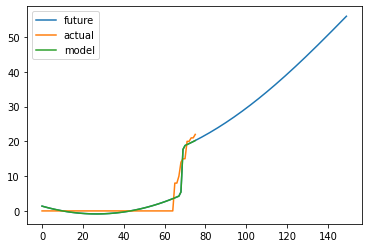

Burma average accuracy: 98.8%


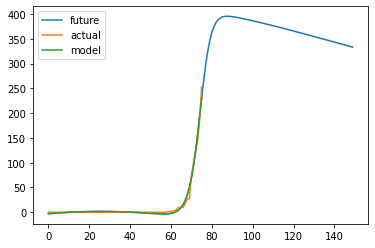

Niger average accuracy: 98.9%


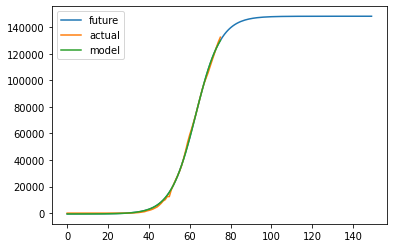

Italy average accuracy: 99.4%


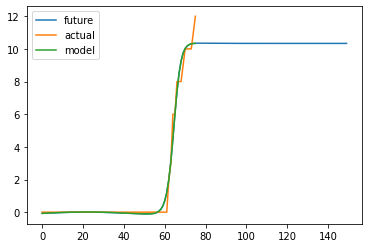

Laos average accuracy: 99.8%


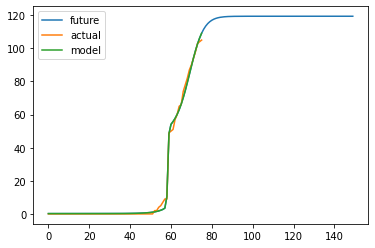

Trinidad and Tobago average accuracy: 99.2%


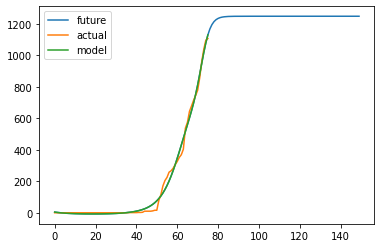

Estonia average accuracy: 98.6%


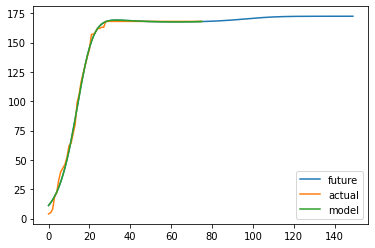

Hainan average accuracy: 99.1%


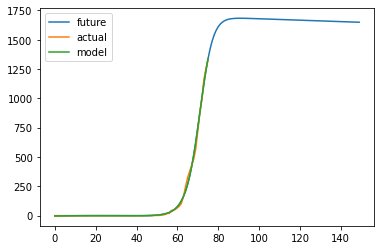

Oklahoma average accuracy: 99.5%


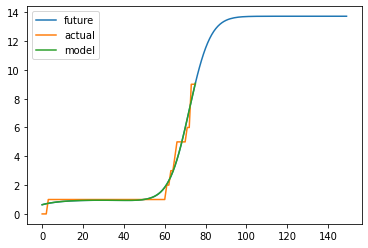

Nepal average accuracy: 99.8%


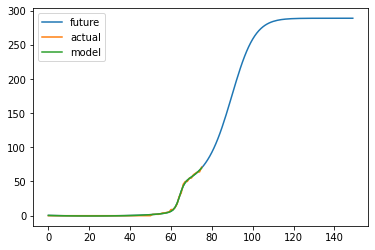

Aruba average accuracy: 99.4%


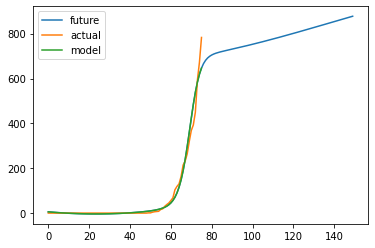

Delaware average accuracy: 98.6%


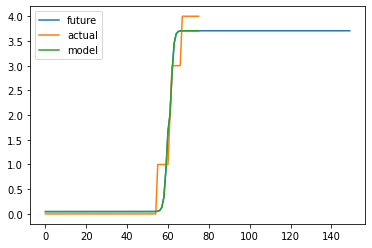

Gambia average accuracy: 99.8%


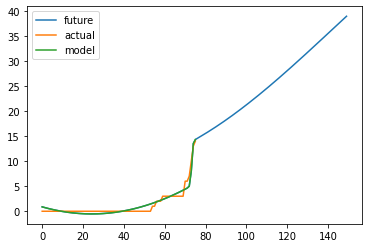

Liberia average accuracy: 99.5%


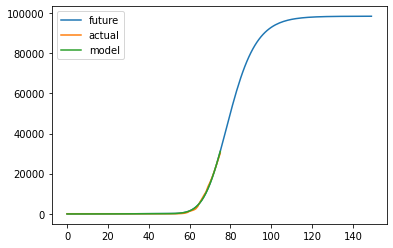

Turkey average accuracy: 99.4%


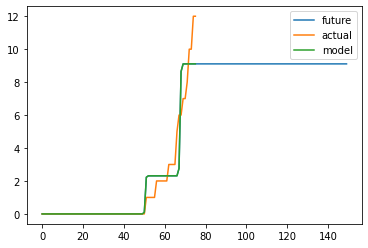

Sudan average accuracy: 99.6%


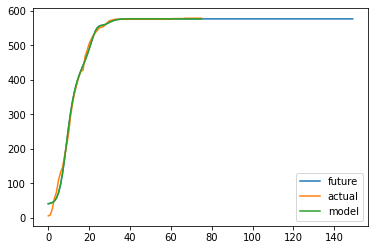

Chongqing average accuracy: 99.0%


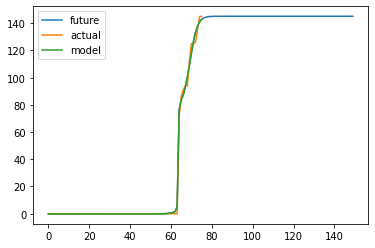

Kosovo average accuracy: 99.4%


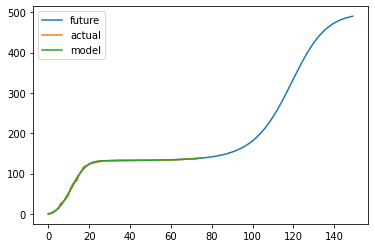

Shanxi average accuracy: 99.2%


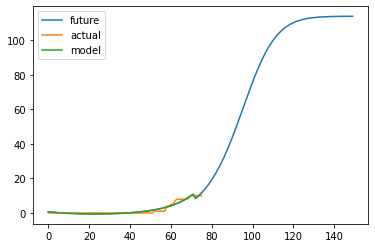

Suriname average accuracy: 99.4%


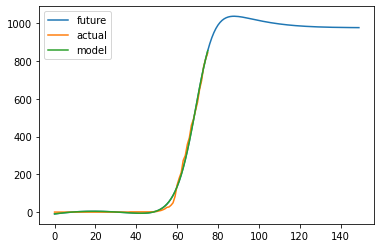

Lithuania average accuracy: 99.0%


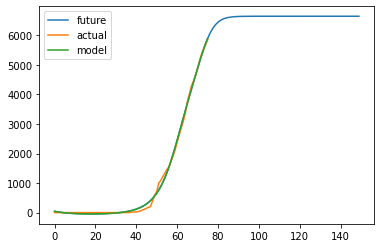

Norway average accuracy: 99.0%


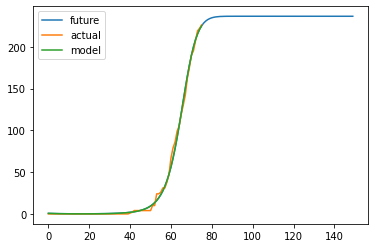

Senegal average accuracy: 99.2%


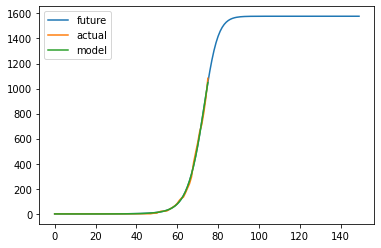

Rhode Island average accuracy: 99.5%


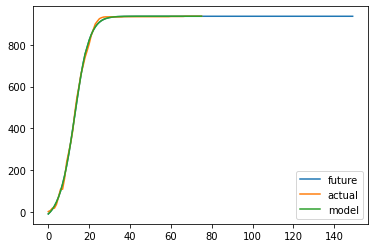

Jiangxi average accuracy: 99.5%


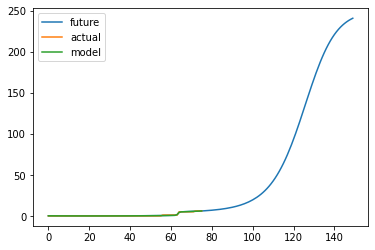

Montserrat average accuracy: 99.9%


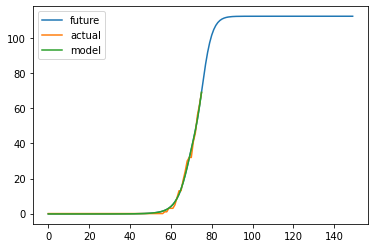

El Salvador average accuracy: 99.5%


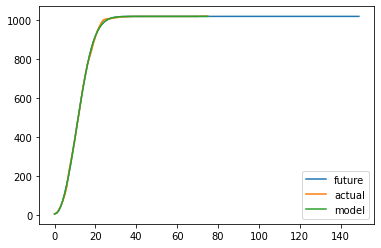

Hunan average accuracy: 99.7%


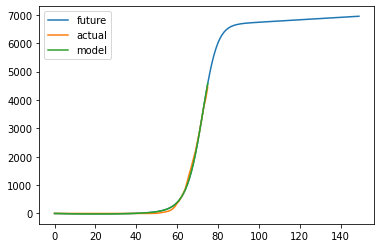

Ohio average accuracy: 99.2%


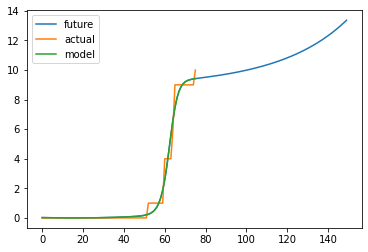

Eswatini average accuracy: 99.8%


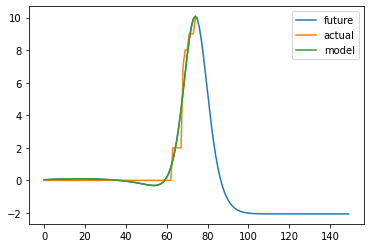

Saint Kitts and Nevis average accuracy: 99.8%


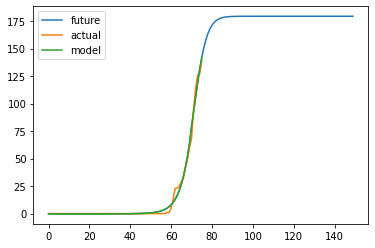

Isle of Man average accuracy: 99.0%


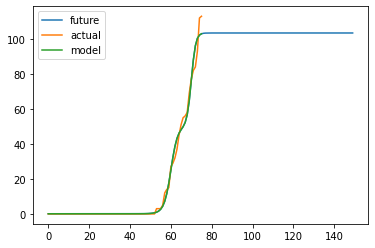

Guam average accuracy: 98.8%


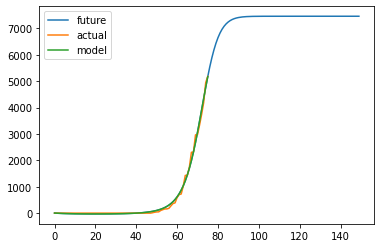

Colorado average accuracy: 99.0%


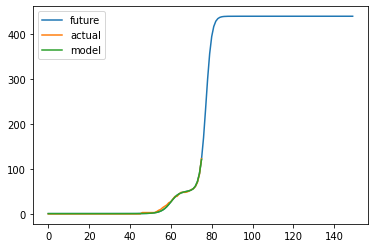

Bangladesh average accuracy: 99.1%


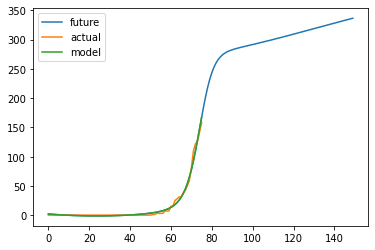

Kenya average accuracy: 98.6%


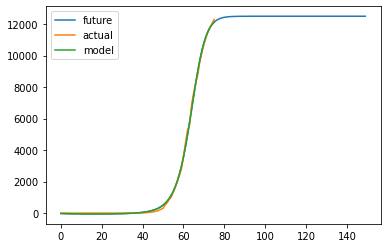

Austria average accuracy: 99.4%


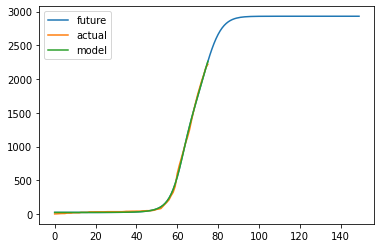

Thailand average accuracy: 99.3%


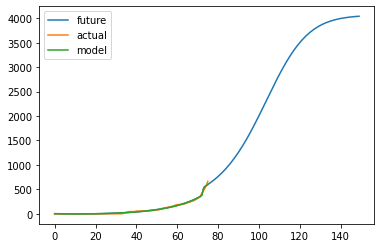

Kuwait average accuracy: 98.6%


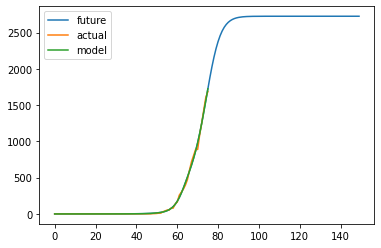

Utah average accuracy: 99.5%


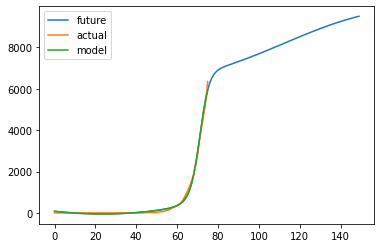

Russia average accuracy: 99.1%


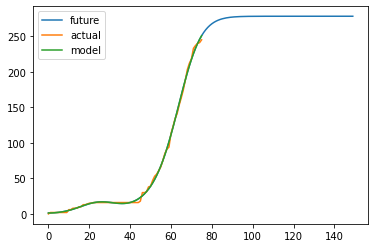

Vietnam average accuracy: 99.3%


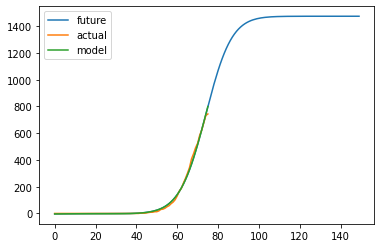

Hungary average accuracy: 99.1%


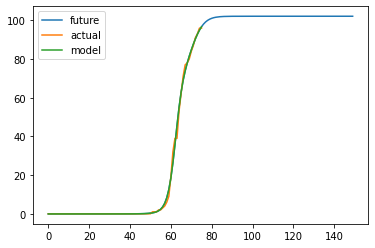

Australian Capital Territory average accuracy: 99.4%


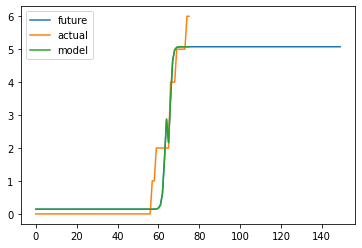

Nicaragua average accuracy: 99.7%


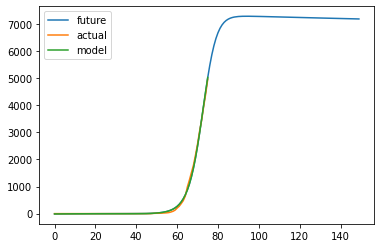

Indiana average accuracy: 99.5%


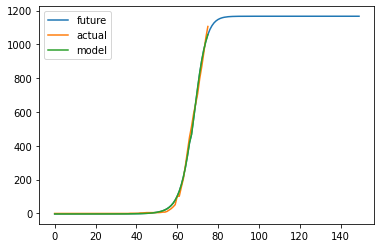

New Zealand average accuracy: 99.2%


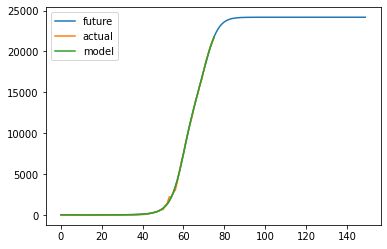

Switzerland average accuracy: 99.8%


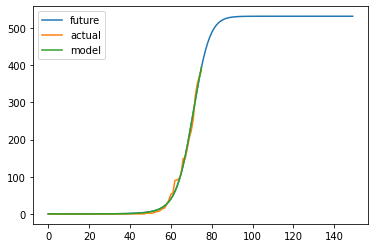

Hawaii average accuracy: 99.1%


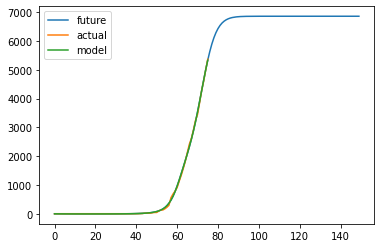

Ireland average accuracy: 99.7%


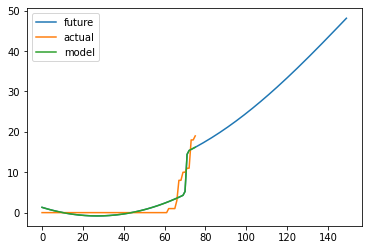

Libya average accuracy: 98.8%


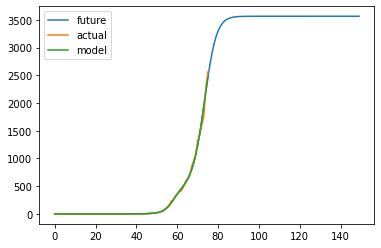

Peru average accuracy: 99.5%


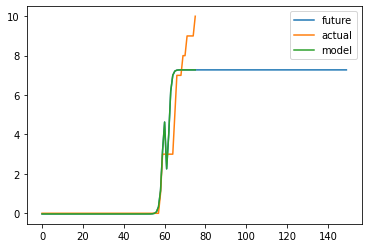

Zimbabwe average accuracy: 99.6%


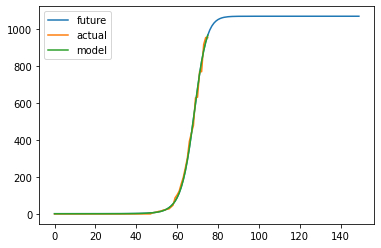

Kentucky average accuracy: 99.3%


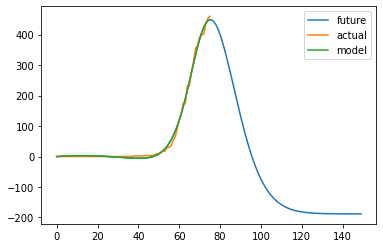

Western Australia average accuracy: 98.9%


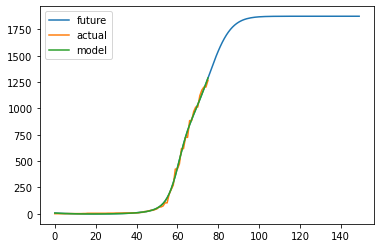

British Columbia average accuracy: 99.1%


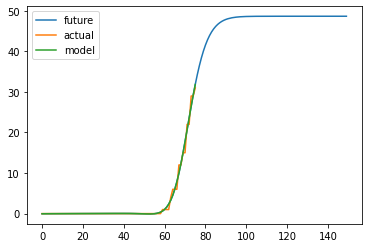

Eritrea average accuracy: 99.7%


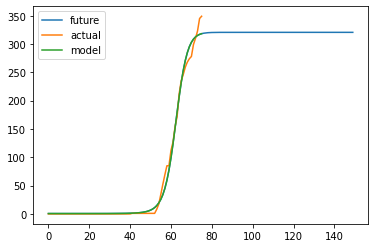

Jordan average accuracy: 98.7%


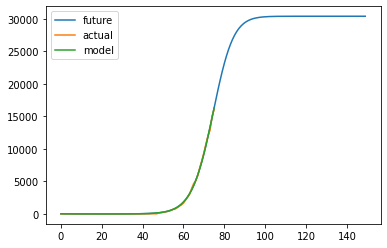

California average accuracy: 99.6%


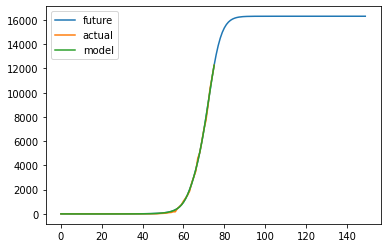

Illinois average accuracy: 99.7%


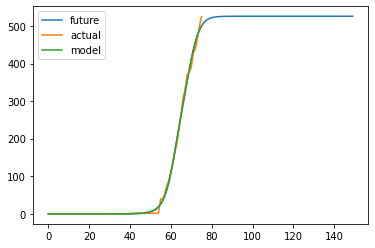

Andorra average accuracy: 99.3%


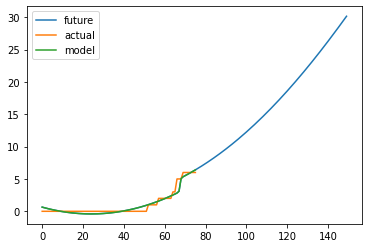

Mauritania average accuracy: 99.6%


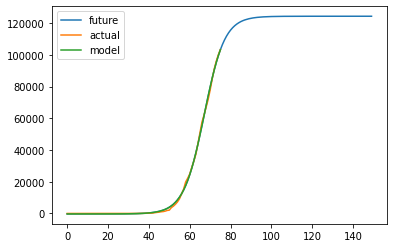

Germany average accuracy: 99.5%


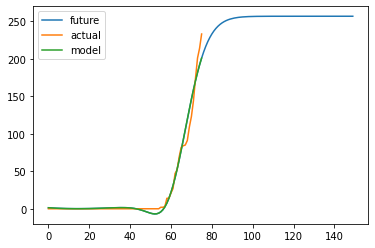

Montenegro average accuracy: 98.2%


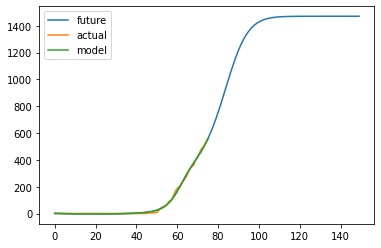

Bulgaria average accuracy: 99.1%


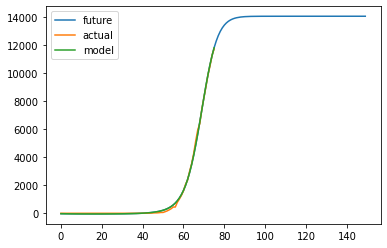

Portugal average accuracy: 99.5%


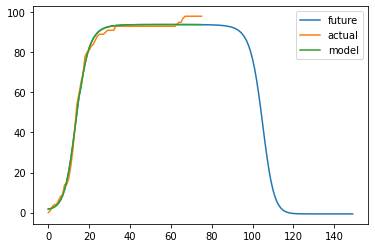

Jilin average accuracy: 98.3%


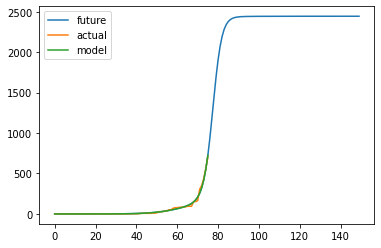

Belarus average accuracy: 99.2%


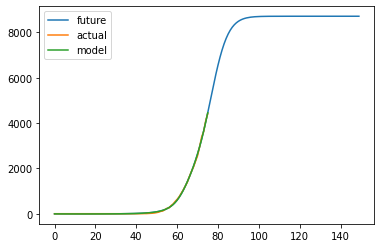

Poland average accuracy: 99.6%


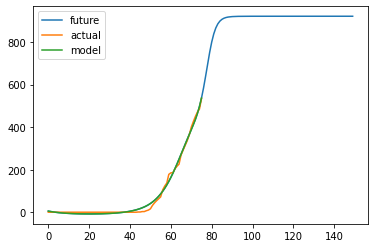

Slovakia average accuracy: 98.4%


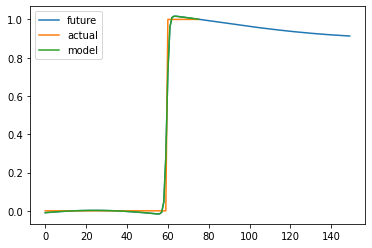

Timor-Leste average accuracy: 1e+02%


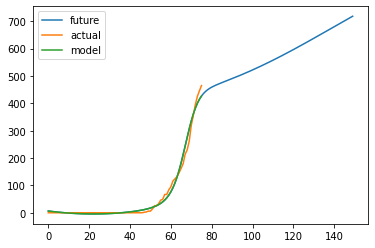

Cyprus average accuracy: 98.2%


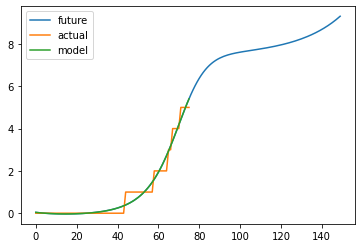

Bhutan average accuracy: 99.8%


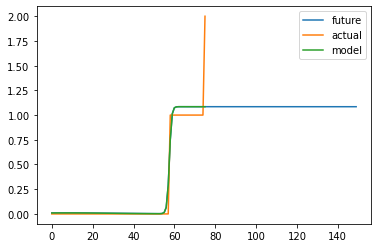

Papua New Guinea average accuracy: 1e+02%


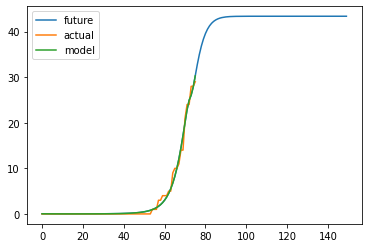

Bahamas average accuracy: 99.6%


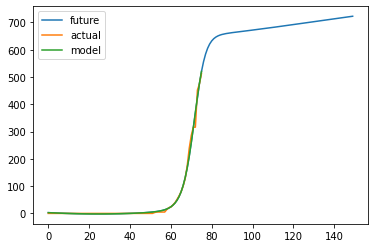

Puerto Rico average accuracy: 99.3%


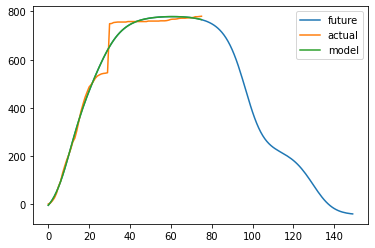

Shandong average accuracy: 97.7%


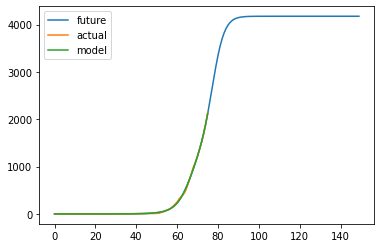

Mexico average accuracy: 99.7%


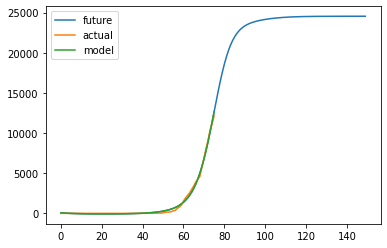

Brazil average accuracy: 99.0%


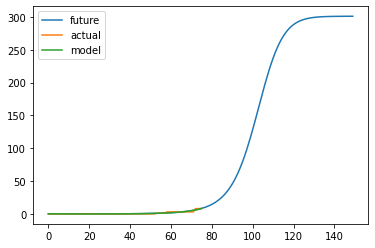

Central African Republic average accuracy: 99.6%


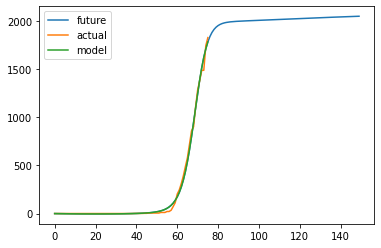

Dominican Republic average accuracy: 99.2%


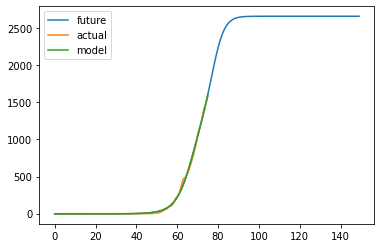

Colombia average accuracy: 99.3%


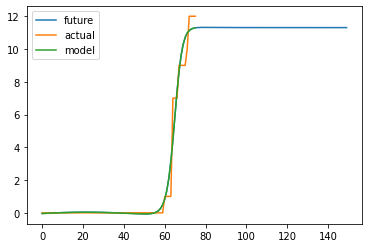

Grenada average accuracy: 99.8%


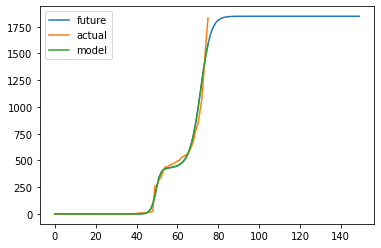

Qatar average accuracy: 98.8%


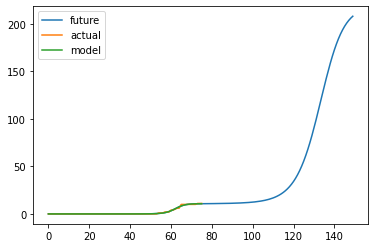

Greenland average accuracy: 99.8%


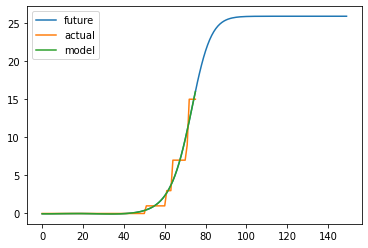

Antigua and Barbuda average accuracy: 99.6%


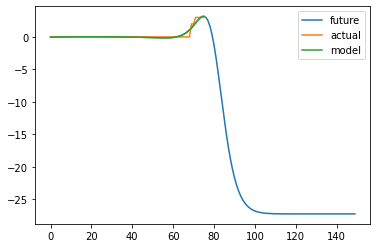

Burundi average accuracy: 99.9%


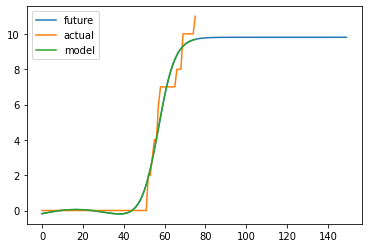

Seychelles average accuracy: 99.7%


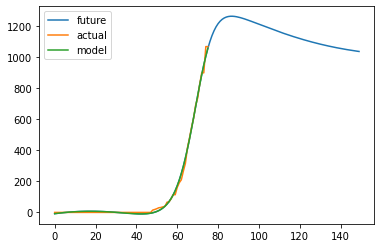

Oregon average accuracy: 99.1%


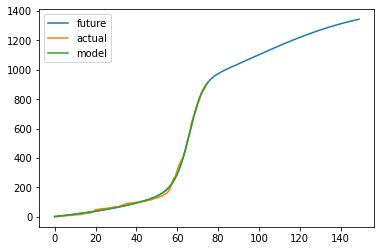

Hong Kong average accuracy: 99.1%


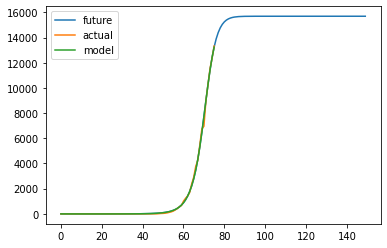

Florida average accuracy: 99.7%


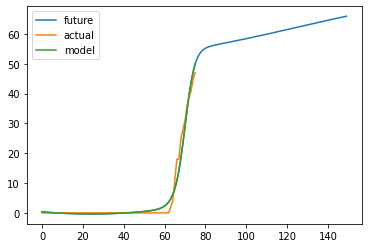

Mali average accuracy: 99.1%


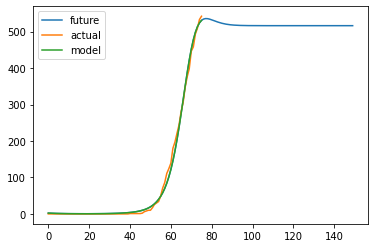

Latvia average accuracy: 99.0%


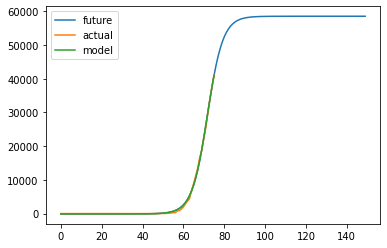

New Jersey average accuracy: 99.5%


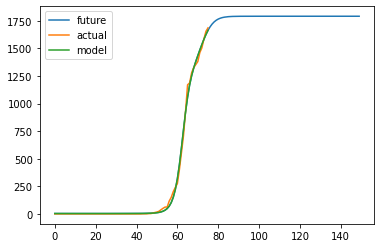

South Africa average accuracy: 99.2%


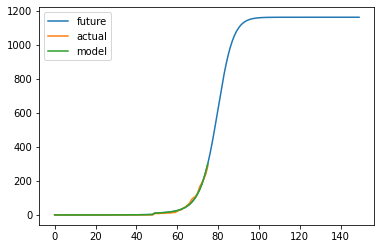

South Dakota average accuracy: 99.1%


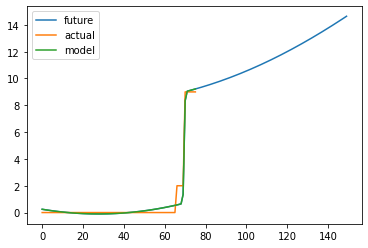

MS Zaandam average accuracy: 99.8%


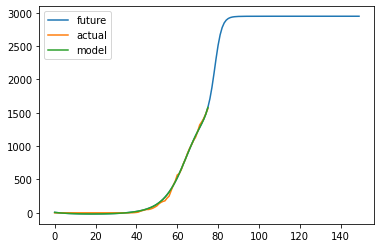

Iceland average accuracy: 99.1%


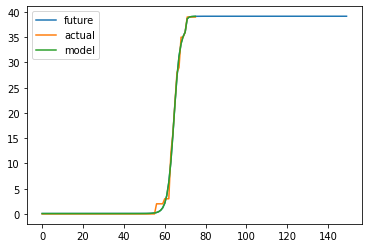

Zambia average accuracy: 99.7%


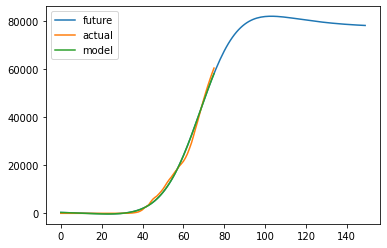

Iran average accuracy: 98.7%


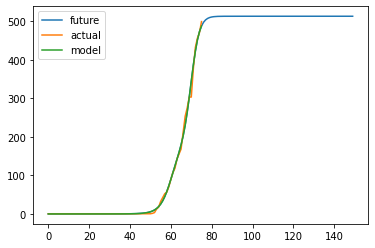

Maine average accuracy: 99.4%


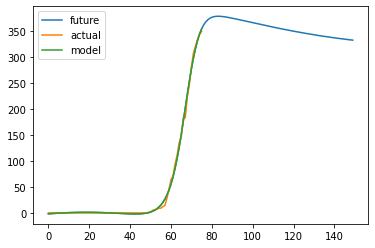

Reunion average accuracy: 99.3%


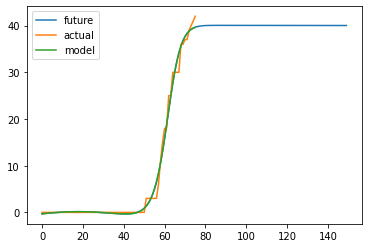

French Polynesia average accuracy: 99.4%


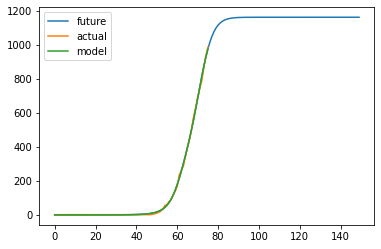

Minnesota average accuracy: 99.6%


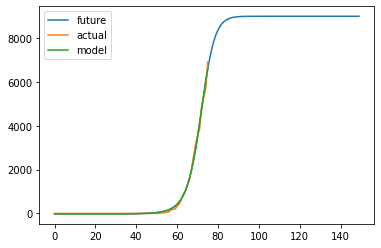

Connecticut average accuracy: 99.3%


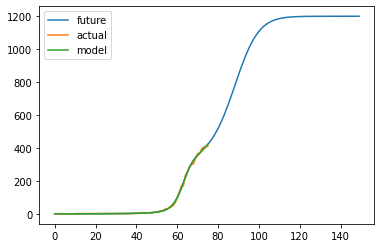

South Australia average accuracy: 99.3%


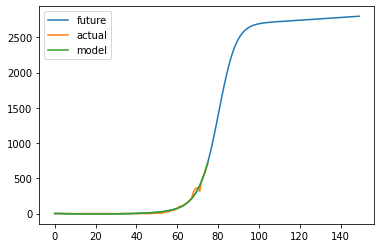

New Hampshire average accuracy: 98.8%


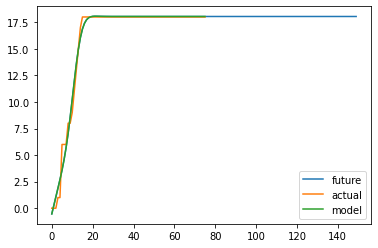

Qinghai average accuracy: 99.8%


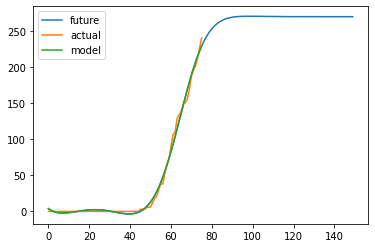

Malta average accuracy: 98.7%


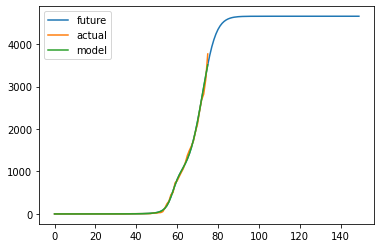

Pakistan average accuracy: 99.5%


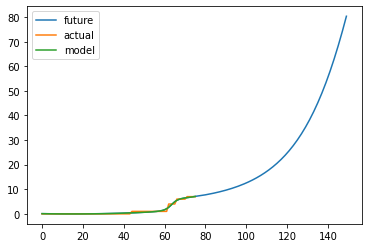

Holy See average accuracy: 99.8%


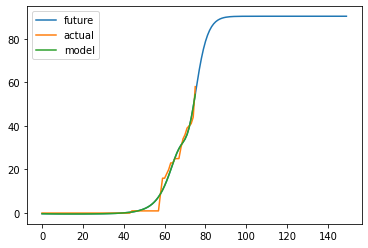

Togo average accuracy: 98.9%


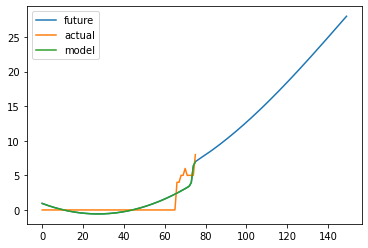

Turks and Caicos Islands average accuracy: 99.3%


In [13]:
# Cases

for cname in cnames:
    if "Canada" == cname:
        continue
    model, powers, casenorm, fatnorm = deepcopy(models[cname])

    
    import matplotlib.pyplot as plt
    
    predictions = np.array([j.numpy()[0]*casenorm for j in model(torch.Tensor([[pow(xval, i) for i in powers] for xval in list(xbycountry[cname])])).detach()])
    plt.plot(np.array(list(range(150))), np.array([j.numpy()[0]*casenorm for j in model(torch.Tensor([[pow(xval, i) for i in powers] for xval in list(range(150))])).detach()]), label="future")
    plt.plot(xbycountry[cname], [i[0] for i in ybycountry[cname]], label="actual")
    plt.plot(xbycountry[cname], predictions, label="model")
#     plt.plot(np.array([73 for i in range(int(casenorm) * 2)]), np.array(list(range(int(casenorm) * 2))), label="day 70")
    # plt.plot(np.array(list(range(200))), np.array([390000 for i in range(200)]), label="growth slows down")
    plt.xlabel = "Days Since 2020-01-22"
    plt.ylabel = "Cases"
    plt.legend()
    plt.show()
    # print(f"Will max out at {model(torch.Tensor([[[102]]])).item()*8e4} infected around May 26 2020")
    print(f"{cname} average accuracy: {100*(1-np.mean(abs(predictions - [i[0] for i in ybycountry[cname]]))/casenorm):.3}%")
    del plt

In [14]:
!rm /kaggle/working/submission.csv
stuff = []
with open("/kaggle/working/submission.csv", 'a+') as fout:
    fout.write("ForecastId,ConfirmedCases,Fatalities\n")
    for i, p in enumerate(ptest.to_numpy()):
        cname = p[1] if type(p[1]) is str else p[2]
        model, powers, casenorm, fatnorm = deepcopy(models[cname])
        date = dateToInt(p[3])
        predictions = np.array([(j.numpy()[0]*casenorm, j.numpy()[1]*fatnorm) for j in model(torch.Tensor([[pow(xval, i) for i in powers] for xval in (date,)])).detach()])
        print(i, cname, date, tuple(predictions[0]))
        print(i + 1, int(round(predictions[0][0])), int(round(predictions[0][1])), sep=',', file=fout)
        stuff.append((i+1, predictions[0]))
print(len(stuff))

rm: cannot remove '/kaggle/working/submission.csv': No such file or directory
0 Afghanistan 64 (90.55486738483906, 2.092657413125038)
1 Afghanistan 65 (105.78413638988732, 2.466770528554916)
2 Afghanistan 66 (122.97514737691878, 2.8897799906730652)
3 Afghanistan 67 (142.27271225405931, 3.365304011106491)
4 Afghanistan 68 (163.80007426759005, 3.896424430131912)
5 Afghanistan 69 (187.64805804629324, 4.48541000676155)
6 Afghanistan 70 (213.86093840920924, 5.13337151491642)
7 Afghanistan 71 (242.42370916767118, 5.839939133763313)
8 Afghanistan 72 (273.2483894312739, 6.602917543888092)
9 Afghanistan 73 (306.16282365365026, 7.418017085909843)
10 Afghanistan 74 (340.9042941585779, 8.278680652856826)
11 Afghanistan 75 (377.1189086424827, 9.176081067323684)
12 Afghanistan 76 (414.3681188977956, 10.099277140617371)
13 Afghanistan 77 (452.1455207442879, 11.035630704760552)
14 Afghanistan 78 (489.89929768733975, 11.971370523691176)
15 Afghanistan 79 (527.0624520443797, 12.892350294828415)
16 Afgha